# Income and Wealth Inequality in Korea

- [1. 데이터 로딩](#1.-데이터-로딩)
- [2. 2022년 분석 결과 검토](#2.-2022년-분석-결과-검토)
   - [weighted mean 함수](#weighted-mean-함수)
   - [weighted_cum_prob 함수](#weighted_cum_prob()-함수)
   - [weighted_percentile 함수](#weighted_percentile-함수)
   - [sub_share 함수](#sub_share-함수)
   - [weighted_sub_share 함수](#weighted_sub_share-함수)
   - [gini_coefficient 함수](#gini_coefficient-함수)
   - [weighted_gini 함수](#weighted_gini-함수)
   - [처분가능소득 정의](#처분가능소득-정의) 
- [3. 지니 계수](#3.-지니-계수)
   - [전체 재산 지니 계수](#전체-재산-지니-계수)
   - [2030 재산 지니 계수](#2030-재산-지니-계수)
   - [전체 소득 지니 계수](#전체-소득-지니-계수)
   - [2030 재산 지니 계수](#2030-재산-지니-계수)
- [4. 분위별 재산 및 소득 점유율](#4.-분위별-재산-및-소득-점유율)
- [5. 백분위수 및 백분위수 배율](#5.-백분위수-및-백분위수-배율)
- [6. 마이너스 재산 가구 중 주택보유 비율](#6.-마이너스-재산-가구-중-주택보유-비율)
- [7. 균등화 재산 및 소득의 지니 계수](#7.-균등화-재산-및-소득의-지니-계수)
- [8. 분위별 재산 및 소득의 성장](#8.-분위별-재산-및-소득의-성장)
- [9. 재산 분위별 재산/소득 배율](#9.-재산-분위별-재산/소득-배율)
- [10. 재산의 구성](#10.-재산의-구성)

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.([Universität Bonn 자료](https://www.wiwi.uni-bonn.de/kuhn/paper/Wealthinequality_April2019.pdf))

## 1. 데이터 로딩

- 한국: **가계금융복지조사**(Survey of Household Finances and Living Conditions) 
   - [2022년 조사결과](https://kostat.go.kr/board.es?mid=a10301040300&bid=215&act=view&list_no=422053), [통계설명자료](https://www.narastat.kr/metasvc/svc/SvcMetaDcDtaPopup.do?confmNo=930001), [마이크로데이터](https://mdis.kostat.go.kr/dwnlSvc/ofrSurvSearch.do?curMenuNo=UI_POR_P9240)

- 미국: [Survey of Consumer Finances (SCF)](https://www.federalreserve.gov/econres/scfindex.htm)

#### 각주:

- 미국은 SCF가 3년 주기로 행해지는데, 2022년 SCF의 경우, [2022년 4월부터 2023년 3월까지 본 조사(main survey)가 행해졌고](https://www.aeaweb.org/forum/1850/survey-consumer-finances-invites-comments-proposed-approach), 연간 소득 등의 변수는 2021년을 기준으로 조사됐고, 자산이나 부채 등은 조사 시점을 기준으로 조사됐다. SCF 보고서는 모든 금액에 대해 CPI를 사용해 인플레이션 효과를 제거한 숫자를 사용해 분석하는 반면, (관측별 가중치를 제공하지만) 가중 평균 등은 사용하지 않는다.


- 한국은 가계금융복지조사가 매년 행해지는데, 2022년 조사의 경우, 2022년 4월에 본 조사가 행해졌고, 연간 소득 등의 변수는 2021년을 기준으로 조사됐고, 자산이나 부채 등은 2022년 3월말 시점을 기준으로 조사됐다. 가계금융복지조사 보고서는 CPI 등을 사용해 인플레이션 효과를 제거하지 않는 반면, 관측별 가중치를 사용해 가중 평균, 가중 중위값, 가중 지니 계수 등을 산출하고 있다. 


- 여기에서는 모든 금액에 대해 CPI를 사용해 인플레이션 효과를 제거할 것이며, 관측별 가중치를 사용해 가중 평균, 가중 중위값, 가중 지니 계수 등을 산출하기로 한다. 그리고 한국 통계당국이 소득 관련 분석의 경우, 가령 2022년 가계금융복지조사를 이용한 결과에 대해서는 (해당 소득 통계가 2021년을 기준으로 조사됐기 때문에) 2021년에 해당하는 결과로 보고하는데, 여기에서는 소득이나 자산 및 부채 구분하지 않고 이 경우 모두 2022년 결과로 표기하기로 한다. 동일한 맥락에서 소득이나 자산 및 부채 구분하지 않고 해당 조사연도의 CPI를 사용하여 실질금액으로 환산하기로 한다.

### 가계금융복지조사 데이터 불러들이기

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# 파일 경로와 이름의 패턴 설정
file_pattern = "..\\Data\\{year}.csv"
file_pattern = "../Data/SHF/{year}.csv"

# 데이터를 저장할 변수 초기화
dfs = []

# 2010부터 2023까지의 파일 로드
for year in range(2010, 2024):
    file_name = file_pattern.format(year=year)
    df_name = "df_{year}".format(year=year)
    df = pd.read_csv(file_name, encoding='EUC-KR')
    dfs.append((df_name, df))

# 결과를 변수에 저장
for df_name, df in dfs:
    globals()[df_name] = df

In [3]:
df_2023

조사연도  MD제공용_가구고유번호          가중값 수도권여부  가구주_성별코드  가구원수 노인가구여부 조손가구여부  \
0      2023      10000162  1077.906572    G1         2     1     G1     G2   
1      2023      10000182  1086.438541    G1         1     2     G2     G2   
2      2023      10000192  3626.894382    G1         2     1     G2     G2   
3      2023      10000212   758.167174    G2         2     1     G1     G2   
4      2023      10000222  1404.353475    G2         1     1     G2     G2   
...     ...           ...          ...   ...       ...   ...    ...    ...   
18089  2023     991300362   545.333267    G2         1     3     G2     G2   
18090  2023     991900211   465.444170    G2         1     4     G2     G2   
18091  2023     991900221   648.366811    G2         1     3     G2     G2   
18092  2023     991900301   628.892098    G2         1     4     G2     G2   
18093  2023     991900321   624.620427    G2         1     2     G1     G2   

      한부모가구여부 다문화가구여부(2012년~)  ... 원리금상환_가계지출감소항목코드  부채상환가능시기코드  가구주_은퇴여부  \
0          G2              G2  ...              NaN         NaN         1   
1          G2              G2  ...              NaN         NaN         1   
2          G2              G2  ...              NaN         NaN         1   
3          G2              G2  ...              NaN         NaN         1   
4          G2              G2  ...              NaN         2.0         1   
...       ...             ...  ...              ...         ...       ...   
18089      G2              G2  ...              NaN         NaN         1   
18090      G2              G2  ...              NaN         NaN         1   
18091      G2              G2  ...              1.0         1.0         1   
18092      G2              G2  ...              NaN         NaN         1   
18093      G2              G2  ...              NaN         NaN         1   

      가구주_미은퇴_은퇴연령  가구주_미은퇴_최소생활비 가구주_미은퇴_적정생활비 가구주_미은퇴_노후준비상황코드  가구주_은퇴_은퇴연령  \
0             77.0            100           200              5.0          NaN   
1             70.0            200           200              3.0          NaN   
2             70.0            300           400              5.0          NaN   
3             75.0            150           200              3.0          NaN   
4             65.0            200           200              3.0          NaN   
...            ...            ...           ...              ...          ...   
18089         65.0            100           150              5.0          NaN   
18090         65.0            200           300              3.0          NaN   
18091         60.0            300           500              3.0          NaN   
18092         62.0            300           600              2.0          NaN   
18093         72.0            100           200              3.0          NaN   

      가구주_은퇴_적정생활비충당여부  가구주은퇴_생활비재원마련코드(2014년~)  
0                  NaN                      NaN  
1                  NaN                      NaN  
2                  NaN                      NaN  
3                  NaN                      NaN  
4                  NaN                      NaN  
...                ...                      ...  
18089              NaN                      NaN  
18090              NaN                      NaN  
18091              NaN                      NaN  
18092              NaN                      NaN  
18093              NaN                      NaN  

[18094 rows x 160 columns]

### CPI 데이터 불러들이기

In [16]:
# CPI 파일 불러들이기
CPI = pd.read_csv('..\\Data\\CPI.csv')
CPI

Year      CPI
0   2001   65.719
1   2002   67.534
2   2003   69.908
3   2004   72.418
4   2005   74.413
5   2006   76.081
6   2007   78.010
7   2008   81.656
8   2009   83.906
9   2010   86.373
10  2011   89.850
11  2012   91.815
12  2013   93.010
13  2014   94.196
14  2015   94.861
15  2016   95.783
16  2017   97.645
17  2018   99.086
18  2019   99.466
19  2020  100.000
20  2021  102.500
21  2022  107.720
22  2023  111.590

### 특정 연도 CPI 지정하기

In [17]:
CPI_2022 = CPI.loc[CPI['Year'] == 2022, 'CPI'].values[0]
CPI_2022

107.72

In [18]:
CPI_2009 = CPI.loc[CPI['Year'] == 2009, 'CPI'].values[0]
CPI_2010 = CPI.loc[CPI['Year'] == 2010, 'CPI'].values[0]
CPI_2011 = CPI.loc[CPI['Year'] == 2011, 'CPI'].values[0]
CPI_2012 = CPI.loc[CPI['Year'] == 2012, 'CPI'].values[0]
CPI_2013 = CPI.loc[CPI['Year'] == 2013, 'CPI'].values[0]
CPI_2014 = CPI.loc[CPI['Year'] == 2014, 'CPI'].values[0]
CPI_2015 = CPI.loc[CPI['Year'] == 2015, 'CPI'].values[0]
CPI_2016 = CPI.loc[CPI['Year'] == 2016, 'CPI'].values[0]
CPI_2017 = CPI.loc[CPI['Year'] == 2017, 'CPI'].values[0]
CPI_2018 = CPI.loc[CPI['Year'] == 2018, 'CPI'].values[0]
CPI_2019 = CPI.loc[CPI['Year'] == 2019, 'CPI'].values[0]
CPI_2020 = CPI.loc[CPI['Year'] == 2020, 'CPI'].values[0]
CPI_2021 = CPI.loc[CPI['Year'] == 2021, 'CPI'].values[0]
CPI_2022 = CPI.loc[CPI['Year'] == 2022, 'CPI'].values[0]
CPI_2023 = CPI.loc[CPI['Year'] == 2023, 'CPI'].values[0]

# 결과를 딕셔너리로 저장
cpi_values = {
    'CPI_2009': CPI_2009,
    'CPI_2010': CPI_2010,
    'CPI_2011': CPI_2011,
    'CPI_2012': CPI_2012,
    'CPI_2013': CPI_2013,
    'CPI_2014': CPI_2014,
    'CPI_2015': CPI_2015,
    'CPI_2016': CPI_2016,
    'CPI_2017': CPI_2017,
    'CPI_2018': CPI_2018,
    'CPI_2019': CPI_2019,
    'CPI_2020': CPI_2020,
    'CPI_2021': CPI_2021,
    'CPI_2022': CPI_2022,
    'CPI_2023': CPI_2023
}

# 결과 반환
cpi_values

{'CPI_2009': 83.906,
 'CPI_2010': 86.373,
 'CPI_2011': 89.85,
 'CPI_2012': 91.815,
 'CPI_2013': 93.01,
 'CPI_2014': 94.196,
 'CPI_2015': 94.861,
 'CPI_2016': 95.783,
 'CPI_2017': 97.645,
 'CPI_2018': 99.086,
 'CPI_2019': 99.466,
 'CPI_2020': 100.0,
 'CPI_2021': 102.5,
 'CPI_2022': 107.72,
 'CPI_2023': 111.59}

## 2. 2022년 분석 결과 검토

- 자료: [[보도자료] 2022년 가계금융복지조사 결과_BOK.pdf](https://www.bok.or.kr/portal/cmmn/file/fileDown.do?menuNo=200690&atchFileId=FILE_000000000035408&fileSn=1)

### 가중평균

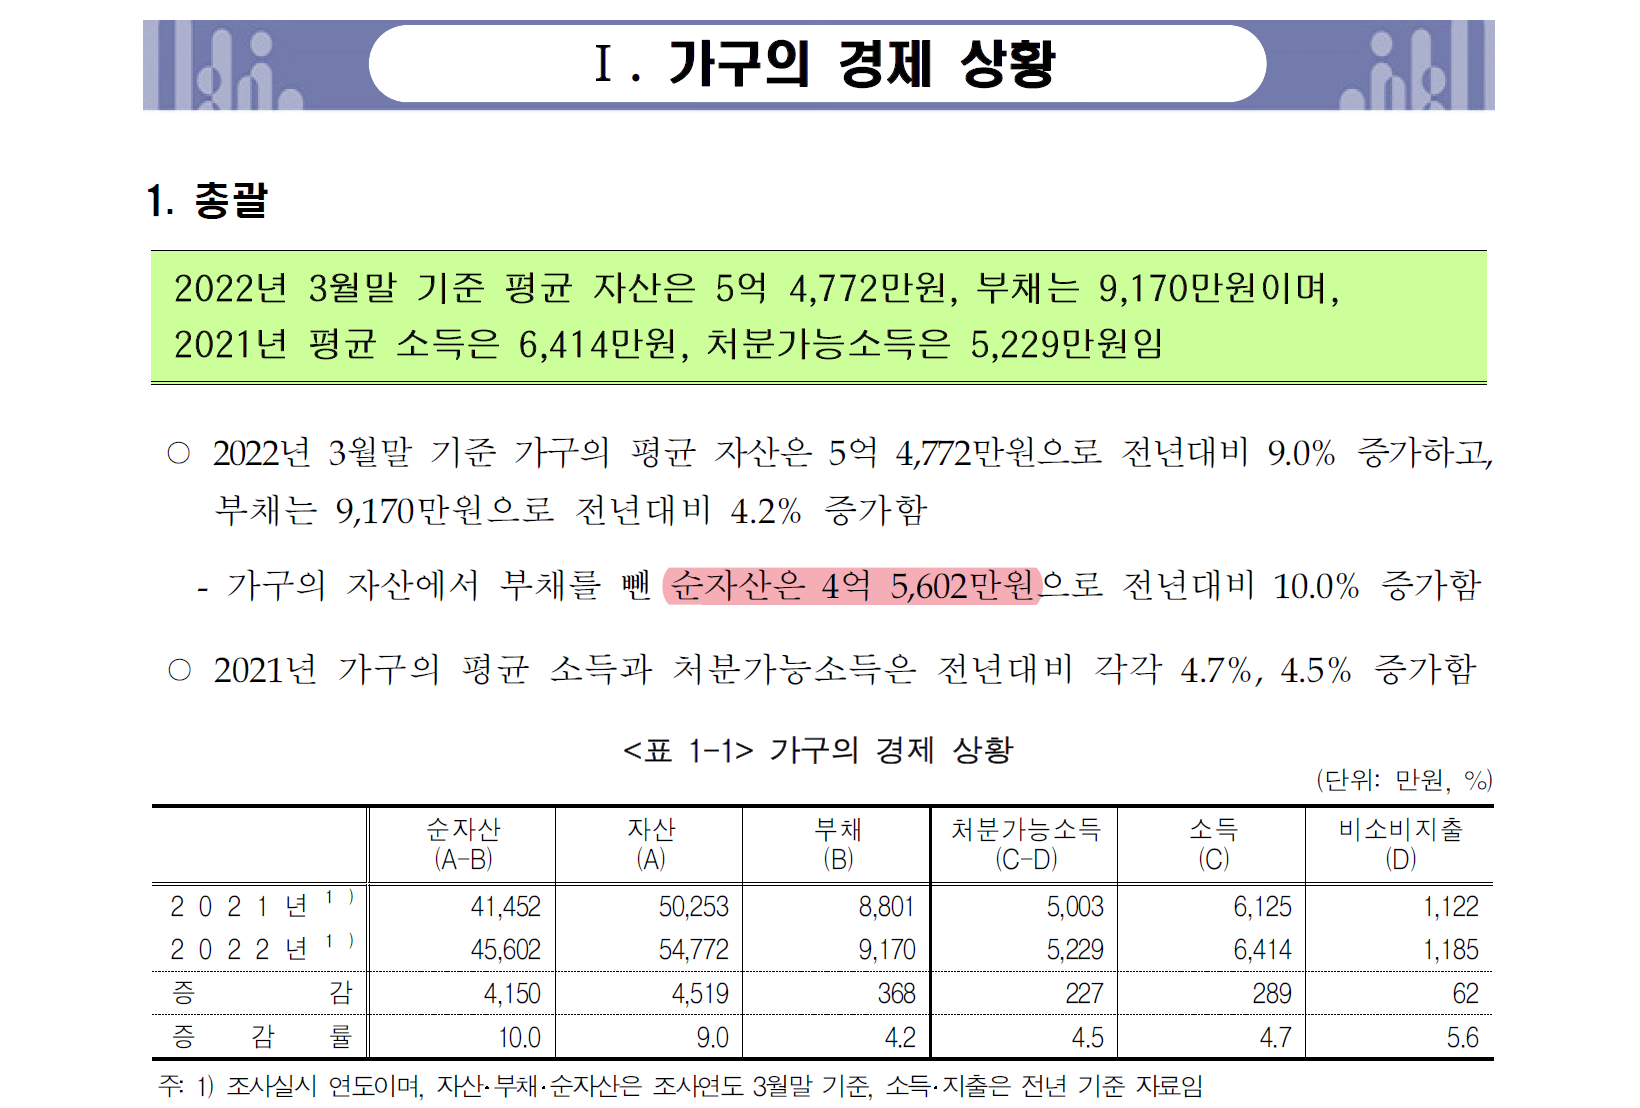

- 위 표의 각주를 통해 데이터세트의 연도가 조사실시 연도이며, 자산‧부채‧순자산은 조사연도 3월말 기준, 소득‧지출은 전년 기준 자료라는 것을 알 수 있다.

In [20]:
# 2022년 순자산 단순평균 구하기
x = df_2022['순자산']
x.mean()

43034.836415283506

In [21]:
# 2022년 순자산 가중 평균 구하기
weight = df_2022['가중값']
weight_sum = df_2022['가중값'].sum()
w = weight/weight_sum
z = x*w
z.sum()

45602.32782013843

- **이를 통해 위 보도자료의 평균 금액은 단순평균이 아니라 가중평균 값이라는 것을 알 수 있다.**

### 가중 중위값

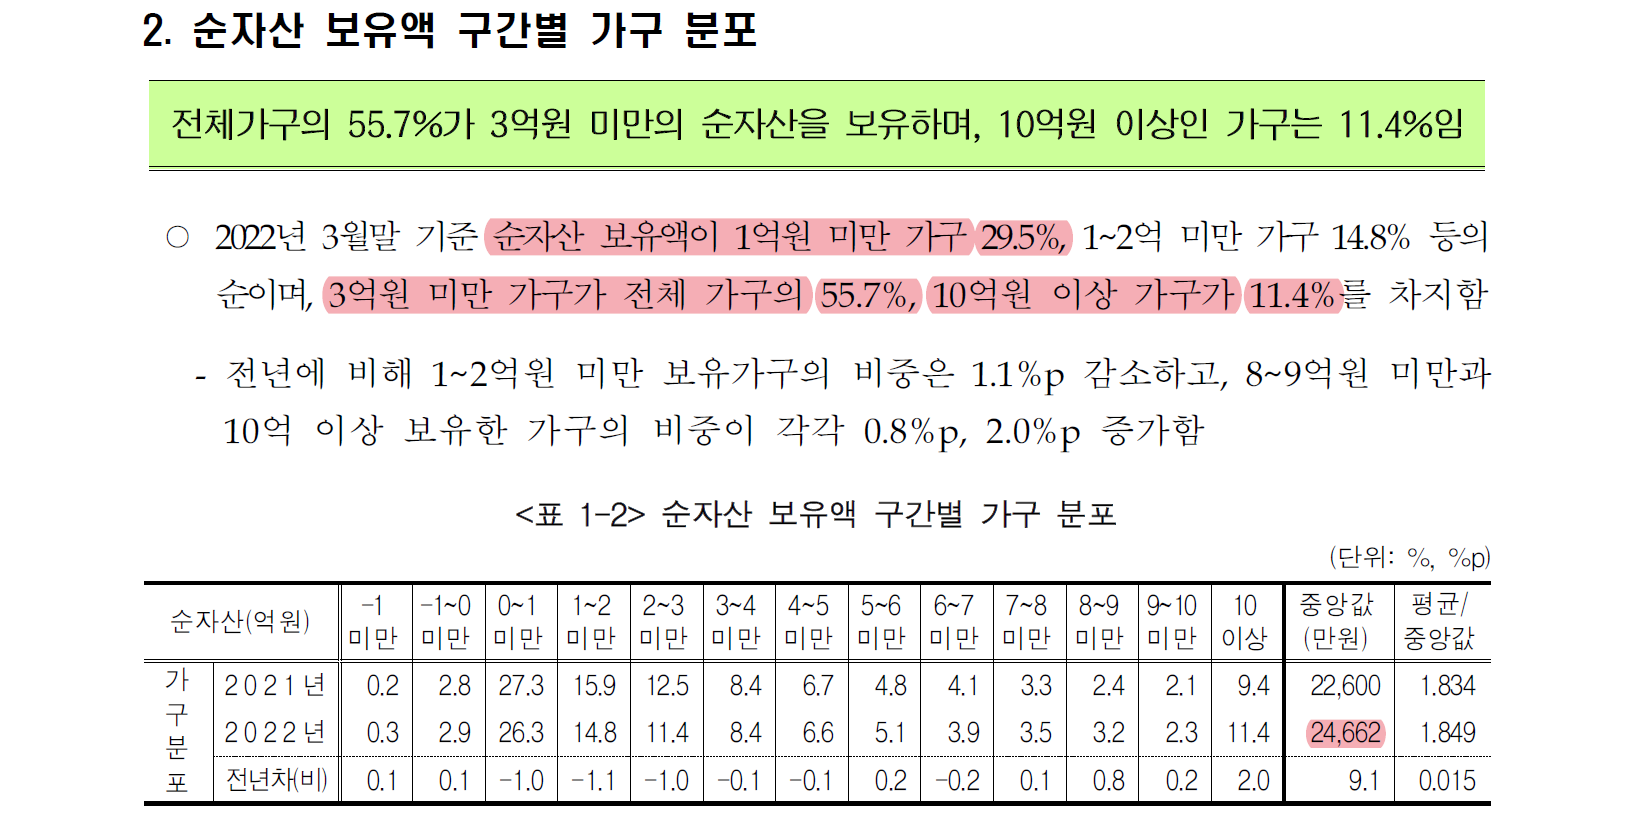

In [22]:
# 순자산 중앙값 I
x.median()

21660.0

### Weighted median 
- 출처: Wikipedia ([Weighted median](https://en.wikipedia.org/wiki/Weighted_median))

> In statistics, a weighted median of a sample is the 50% weighted percentile. It was first proposed by F. Y. Edgeworth in 1888.
>
> **Definition (General case):**
>For $n$ distinct ordered elements $x_1, x_2,...,x_n$ with positive weights $w_1, w_2,...,w_n$ such that $\sum_{i=1}^n w_i = 1$, the weighted median is the element $x_k$ satisfying 
>
>$$\sum_{i = 1}^{k - 1} w_i \le 1/2\  \text{and}\   \sum_{i = k + 1}^{n} w_i \le 1/2$$

In [23]:
def weighted_median(x, w):
    
    # 가중치 표준화
    w = w/w.sum()
    
    # 값과 가중치를 함께 정렬
    sorted_data = sorted(zip(x, w), key=lambda pair: pair[0])
    cumulative_weight = 0

    for value, weight in sorted_data:
        cumulative_weight += weight
        if cumulative_weight >= 0.5:
            return value

result = weighted_median(x, w)
print("가중 중앙값:", result)
weighted_median(x, w), weighted_median(x, weight)

가중 중앙값: 24662


(24662, 24662)

- **이를 통해 위 보도자료의 중위 금액은 단순 중위값이 아니라 가중 중위값이라는 것을 알 수 있다.**

### weighted mean 함수

In [24]:
def weighted_mean(x, w):
    # 가중 평균 계산
    weighted_sum = np.sum(x * w)
    total_weight = np.sum(w)
    mean = weighted_sum / total_weight
    return mean

In [25]:
weighted_mean(x, w), weighted_mean(x, weight)

(45602.32782013843, 45602.327820138424)

### weighted_cum_prob() 함수

In [26]:
def weighted_cum_prob(x, w, threshold):
    # x: 데이터 값의 리스트 또는 배열
    # w: 각 데이터 포인트의 가중치 리스트 또는 배열 (x와 크기가 같아야 함)
    # threshold: 비율을 계산할 임계값

    # 초기화
    total_weight_below_threshold = 0
    total_weight = 0

    # 데이터와 가중치를 반복하면서 임계값 미만의 가중치 합을 구함
    for x_i, w_i in zip(x, w):
        if x_i < threshold:
            total_weight_below_threshold += w_i
        total_weight += w_i

    # 임계값 미만의 가중치 합을 전체 가중치로 나누어 비율을 계산
    cumulative_probability = total_weight_below_threshold / total_weight
    
    return cumulative_probability

x = np.array([10, 20, 30])
w = np.array([0.2, 0.3, 0.5])
weighted_cum_prob(x, w, 20)
zip(x, w)

In [27]:
# 2022년 데이터
x = df_2022['순자산']
weight = df_2022['가중값']
weight_sum = df_2022['가중값'].sum()
w = weight/weight_sum

weighted_cum_prob(x, w, 10000), weighted_cum_prob(x, weight, 10000)

(0.2950459458084692, 0.2950459458084705)

In [28]:
print('순자산 1억원 미만 가구(%):', round(weighted_cum_prob(x, weight, 10000)*100,1))
print('순자산 3억원 미만 가구(%):', round(weighted_cum_prob(x, weight, 30000)*100,1))
print('순자산 10억원 이상 가구(%):', round((1-weighted_cum_prob(x, weight, 100000))*100,1))

순자산 1억원 미만 가구(%): 29.5
순자산 3억원 미만 가구(%): 55.7
순자산 10억원 이상 가구(%): 11.4


### 가중 백분위수

#### The weighted percentile method

출처: Wikipedia ([Percentile](https://en.wikipedia.org/wiki/Percentile#Weighted_percentile))


In addition to the percentile function, there is also a weighted percentile, where the percentage in the total weight is counted instead of the total number. There is no standard function for a weighted percentile. One method extends the above approach in a natural way.

Suppose we have positive weights $w_1, w_2, w_3, \dots, w_N$ associated, respectively, with our $N$ sorted sample values. Let 

$$S_N = \sum_{k=1}^N w_k,$$

the sum of the weights. Then the formulas above are generalized by taking

$$ p_n = \frac{1}{S_N}\left(S_n - \frac{w_n}{2}\right)\ \text{when}\ C=1/2 $$

or
$$ p_n = \frac{S_n - Cw_n}{S_N +(1-2C)w_n}\ \text{for general}\ C $$

and

$$v = v_k + \frac{P - p_k}{p_{k + 1} - p_k}(v_{k + 1} - v_k) $$.

The 50% weighted percentile is known as the weighted median.

### weighted_percentile 함수

In [31]:
def weighted_percentile(x, w, percentile):
    # x: 데이터 값의 리스트 또는 배열
    # w: 각 데이터 포인트의 가중치 리스트 또는 배열 (x와 크기가 같아야 함)
    # percentile: 계산할 백분위수 (0부터 100까지의 값)

    # 데이터와 가중치를 데이터와 가중치의 쌍으로 묶음
    data_with_weights = list(zip(x, w))

    # 데이터를 값에 따라 정렬
    data_with_weights.sort(key=lambda pair: pair[0])

    # 누적 가중치 초기화
    cumulative_weight = 0

    # 백분위수에 해당하는 가중치 임계값 계산
    target_weight = (percentile / 100) * sum(w)

    # 백분위수에 해당하는 데이터 값을 찾아 반환
    for value, weight in data_with_weights:
        cumulative_weight += weight
        if cumulative_weight >= target_weight:
            return value

    # 백분위수가 100인 경우 가장 큰 값을 반환
    return data_with_weights[-1][0]

weighted_percentile(x, w, 50), weighted_percentile(x, weight, 50)

(24662, 24662)

In [32]:
print("가중 0 백분위수:", weighted_percentile(x, weight, 0))
print("가중 10 백분위수:", weighted_percentile(x, weight, 10))
print("가중 20 백분위수:", weighted_percentile(x, weight, 20))
print("가중 30 백분위수:", weighted_percentile(x, weight, 30))
print("가중 40 백분위수:", weighted_percentile(x, weight, 40))
print("가중 50 백분위수:", weighted_percentile(x, weight, 50))
print("가중 60 백분위수:", weighted_percentile(x, weight, 60))
print("가중 70 백분위수:", weighted_percentile(x, weight, 70))
print("가중 80 백분위수:", weighted_percentile(x, weight, 80))
print("가중 90 백분위수:", weighted_percentile(x, weight, 90))
print("가중 100 백분위수:", weighted_percentile(x, weight, 100))

print("\n최소값:", min(x))
print("최대값:", max(x))

가중 0 백분위수: -77950
가중 10 백분위수: 1170
가중 20 백분위수: 5010
가중 30 백분위수: 10267
가중 40 백분위수: 16600
가중 50 백분위수: 24662
가중 60 백분위수: 34500
가중 70 백분위수: 49022
가중 80 백분위수: 70968
가중 90 백분위수: 108100
가중 100 백분위수: 1651550

최소값: -77950
최대값: 1651550


### 단순 점유율

In [33]:
# x와 weight를 데이터프레임으로 묶기
df = pd.DataFrame({'x': x, 'weight': weight})
    
# 상위 5% 데이터 추출
top_5_z = df[df['x'] >= weighted_percentile(x, weight, 95)]
top_5_x = top_5_z['x']
top_5_weight = top_5_z['weight']

top_5_x.describe()

count    8.580000e+02
mean     2.762632e+05
std      1.694390e+05
min      1.544900e+05
25%      1.795432e+05
50%      2.208500e+05
75%      3.100378e+05
max      1.651550e+06
Name: x, dtype: float64

In [34]:
# 전체 합계 계산
total_sum = x.sum()

# 상위 5% 값의 합계 계산
top_5_x = x[x >= np.percentile(x, 95)]
top_5_sum = top_5_x.sum()

# 상위 5% 값의 합계를 전체 합계로 나누기
percentage = (top_5_sum / total_sum) * 100

print("상위 5%가 전체의 {:.2f}%를 차지합니다.".format(percentage))

상위 5%가 전체의 31.47%를 차지합니다.


### 하위 그룹의 점유율

### sub_share 함수

- 하위 그룹의 점유율을 구하는 함수

In [35]:
def sub_share(data, lower, upper):
    
    # 전체 합계 계산
    total_sum = data.sum()
    
    # lower 백분위수와 upper 백분위수 계산
    p_lower = np.percentile(data, lower)
    p_upper = np.percentile(data, upper)
    
    # sub-group 값의 합계 계산
    sub_data = data[(data > p_lower) & (data <= p_upper)]
    sub_sum = sub_data.sum()
    
    # sub-group 값의 합계를 전체 합계로 나누기
    percentage = (sub_sum / total_sum) * 100
    
    return percentage

print("sub_share(x1, 95, 100): {:.2f}%" .format(sub_share(x, 95, 100)))

sub_share(x1, 95, 100): 31.47%


In [36]:
# 2022년 순자산 및 가중치
x = df_2022['순자산']
weight = df_2022['가중값']

In [37]:
share_1 = sub_share(x, 0, 10)
share_2 = sub_share(x, 10, 20)
share_3 = sub_share(x, 20, 30)
share_4 = sub_share(x, 30, 40)
share_5 = sub_share(x, 40, 50)
share_6 = sub_share(x, 50, 60)
share_7 = sub_share(x, 60, 70)
share_8 = sub_share(x, 70, 80)
share_9 = sub_share(x, 80, 90)
share_10 = sub_share(x, 90, 100)

print("1분위 점유율:", round(share_1, 2))
print("2분위 점유율:", round(share_2, 2))
print("3분위 점유율:", round(share_3, 2))
print("4분위 점유율:", round(share_4, 2))
print("5분위 점유율:", round(share_5, 2))
print("6분위 점유율:", round(share_6, 2))
print("7분위 점유율:", round(share_7, 2))
print("8분위 점유율:", round(share_8, 2))
print("9분위 점유율:", round(share_9, 2))
print("10분위 점유율:", round(share_10, 2))

total = share_1+share_2+share_3+share_4+share_5+share_6+share_7+share_8+share_9+share_10
print("점유율 합계:", total)

1분위 점유율: -0.17
2분위 점유율: 0.55
3분위 점유율: 1.49
4분위 점유율: 2.71
5분위 점유율: 4.18
6분위 점유율: 6.0
7분위 점유율: 8.53
8분위 점유율: 12.25
9분위 점유율: 18.71
10분위 점유율: 45.76
점유율 합계: 100.01008868918125


### 가중 점유율

In [38]:
# 2022년 순자산 및 가중치
x = df_2022['순자산']
weight = df_2022['가중값']

In [39]:
# x와 weight를 데이터프레임으로 묶기
df = pd.DataFrame({'x': x, 'weight': weight})
    
# 상위 10% 데이터 추출
top_10_z = df[df['x'] >= weighted_percentile(x, weight, 90)]
top_10_x = top_10_z['x']
top_10_weight = top_10_z['weight']

(top_10_x*top_10_weight).sum()/(x*weight).sum()

0.4304071254098186

### weighted_sub_share 함수

- 가중치를 사용하여 하위 그룹의 점유율을 구하는 함수

In [40]:
def weighted_sub_share(data, weight, lower, upper):
    
    # 전체 합계 계산
    total_sum = (data*weight).sum()
    
    # lower 백분위수와 upper 백분위수 계산
    p_lower = weighted_percentile(data, weight, lower)
    p_upper = weighted_percentile(data, weight, upper)
    
    # sub-group 값의 합계 계산
    sub_data = data[(data > p_lower) & (data <= p_upper)]
    sub_sum = (sub_data*weight).sum()
    
    # sub-group 값의 합계를 전체 합계로 나누기
    percentage = (sub_sum / total_sum) * 100
    
    return percentage

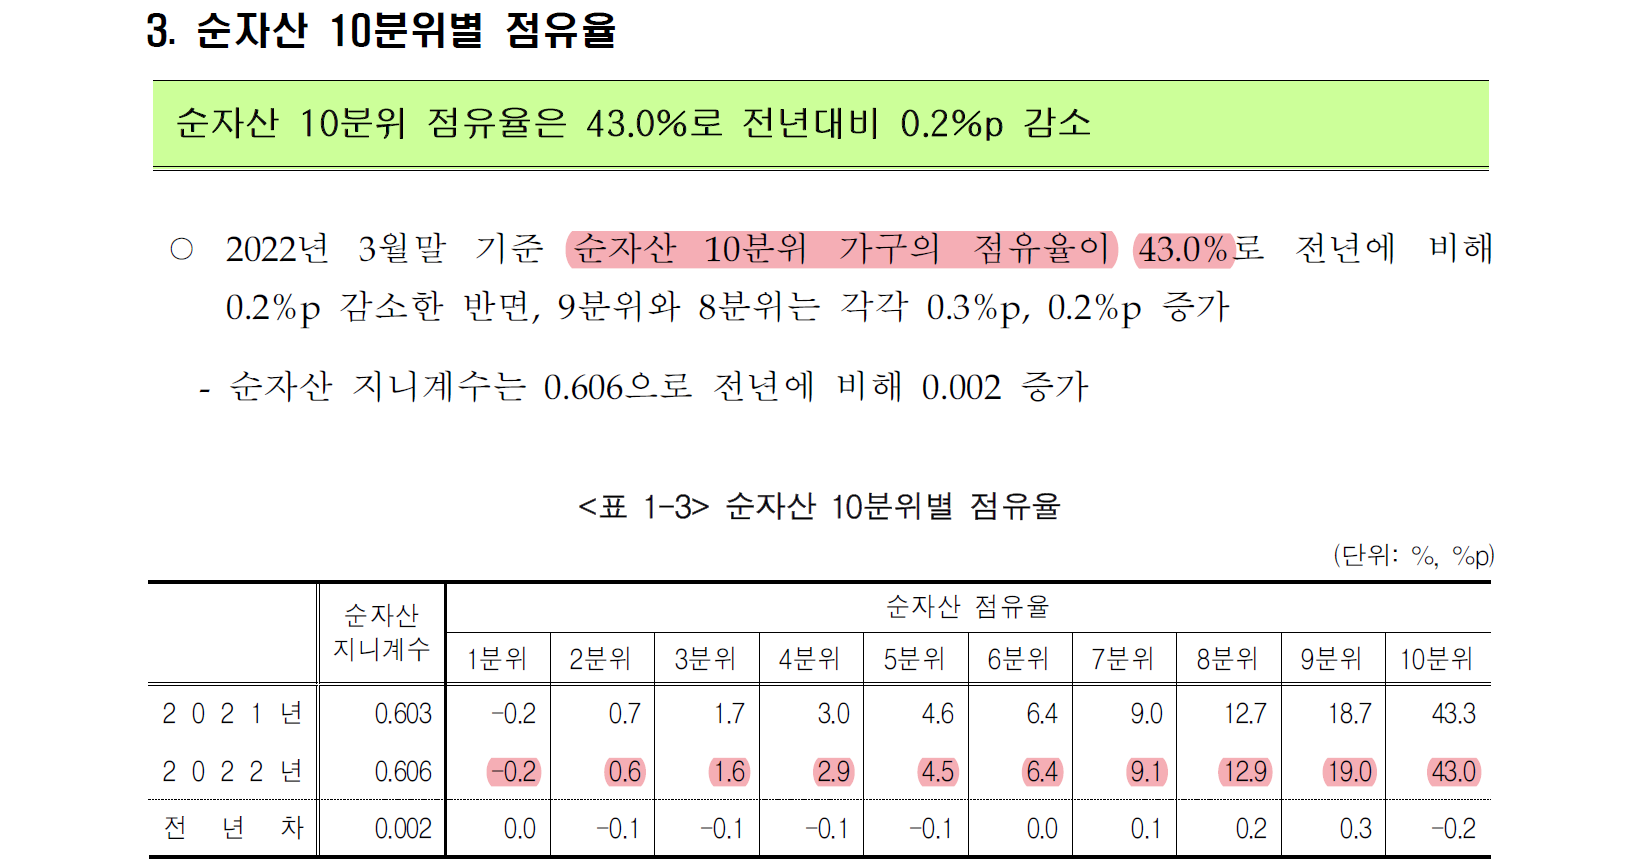

In [41]:
share_1 = weighted_sub_share(x, weight, 0, 10)
share_2 = weighted_sub_share(x, weight, 10, 20)
share_3 = weighted_sub_share(x, weight, 20, 30)
share_4 = weighted_sub_share(x, weight, 30, 40)
share_5 = weighted_sub_share(x, weight, 40, 50)
share_6 = weighted_sub_share(x, weight, 50, 60)
share_7 = weighted_sub_share(x, weight, 60, 70)
share_8 = weighted_sub_share(x, weight, 70, 80)
share_9 = weighted_sub_share(x, weight, 80, 90)
share_10 = weighted_sub_share(x, weight, 90, 100)

print("1분위 점유율:", round(share_1, 2))
print("2분위 점유율:", round(share_2, 2))
print("3분위 점유율:", round(share_3, 2))
print("4분위 점유율:", round(share_4, 2))
print("5분위 점유율:", round(share_5, 2))
print("6분위 점유율:", round(share_6, 2))
print("7분위 점유율:", round(share_7, 2))
print("8분위 점유율:", round(share_8, 2))
print("9분위 점유율:", round(share_9, 2))
print("10분위 점유율:", round(share_10, 2))

total = share_1+share_2+share_3+share_4+share_5+share_6+share_7+share_8+share_9+share_10
print("점유율 합계:", total)

1분위 점유율: -0.19
2분위 점유율: 0.64
3분위 점유율: 1.65
4분위 점유율: 2.93
5분위 점유율: 4.51
6분위 점유율: 6.44
7분위 점유율: 9.07
8분위 점유율: 12.91
9분위 점유율: 19.0
10분위 점유율: 43.03
점유율 합계: 100.00463780932658


### 처분가능소득 정의

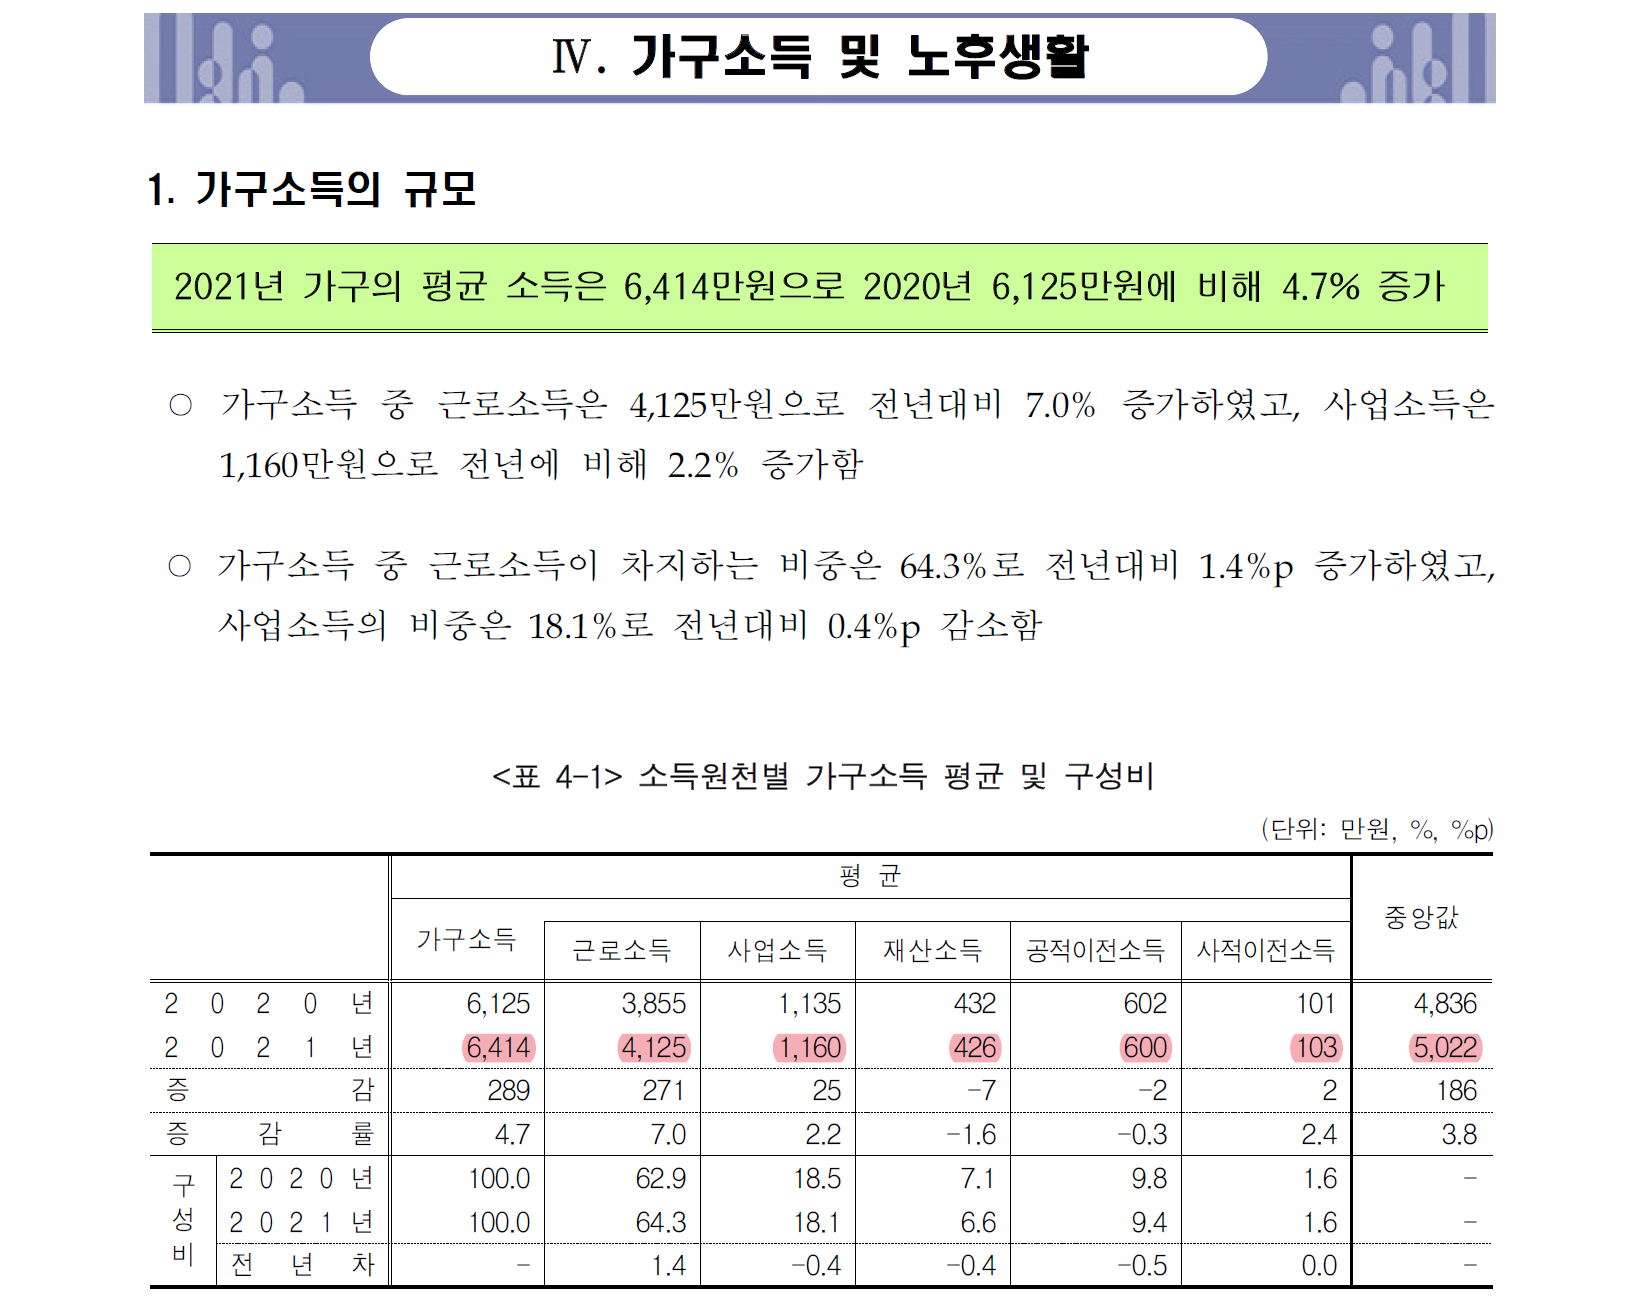

In [42]:
y1 = df_2022['경상소득(보완)']
y2 = df_2022['경상소득_근로소득(보완)']
y3 = df_2022['경상소득_사업소득(보완)']
y4 = df_2022['경상소득_재산소득(보완)']
y5 = df_2022['경상소득_공적이전소득(보완)']
y6 = df_2022['경상소득_사적이전소득(조사)']
y7 = df_2022['처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]']
weight = df_2022['가중값']

print('가구소득(y1):', round(weighted_mean(y1, weight)))
print('근로소득(y2):', round(weighted_mean(y2, weight)))
print('사업소득(y3):', round(weighted_mean(y3, weight)))
print('재산소득(y4):', round(weighted_mean(y4, weight)))
print('공적이전소득(y5):', round(weighted_mean(y5, weight)))
print('사적이전소득(y6):', round(weighted_mean(y6, weight)))
print('\n(경상소득-비소비지출)(y7):', round(weighted_mean(y7, weight)))
print('\n중위 가구소득:', weighted_median(y1, weight))

가구소득(y1): 6414
근로소득(y2): 4125
사업소득(y3): 1160
재산소득(y4): 426
공적이전소득(y5): 600
사적이전소득(y6): 103

(경상소득-비소비지출)(y7): 5229

중위 가구소득: 5022


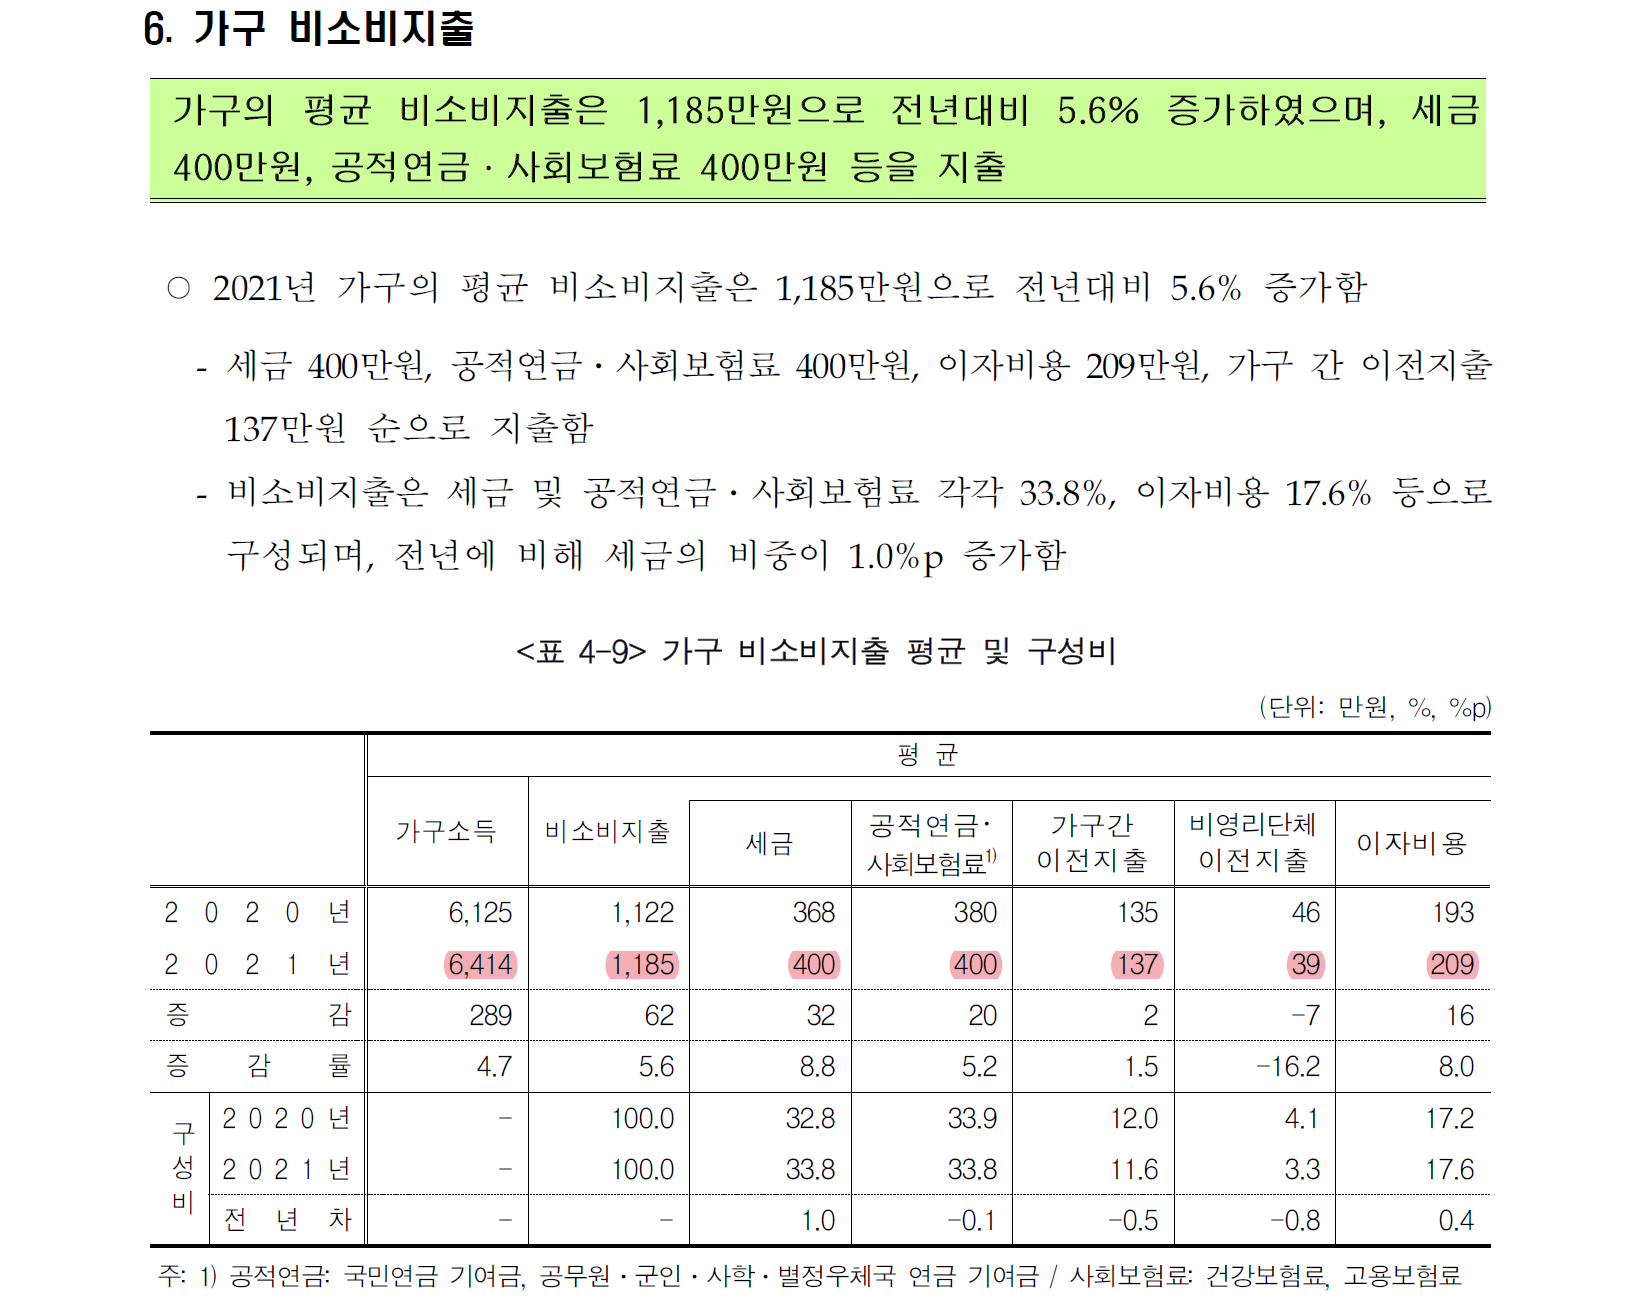

In [43]:
e1 = df_2022['지출_비소비지출(보완)']
e2 = df_2022['지출_비소비지출_세금(보완)']
e3 = df_2022['지출_비소비지출_공적연금사회보험료(보완)']
e4 = df_2022['지출_비소비지출_가구간이전지출(조사)']
e5 = df_2022['지출_비소비지출_비영리단체이전지출(조사)']
e6 = df_2022['지출_비소비지출_연간지급이자(조사)']

print('비소비지출(e1):', round(weighted_mean(e1, weight)))
print('비소비지출_세금(e2):', round(weighted_mean(e2, weight)))
print('공적연금사회보험료(e3):', round(weighted_mean(e3, weight)))
print('가구간이전지출(e4):', round(weighted_mean(e4, weight)))
print('비영리단체이전지출(e5):', round(weighted_mean(e5, weight)))
print('연간지급이자(e6):', round(weighted_mean(e6, weight)))

비소비지출(e1): 1185
비소비지출_세금(e2): 400
공적연금사회보험료(e3): 400
가구간이전지출(e4): 137
비영리단체이전지출(e5): 39
연간지급이자(e6): 209


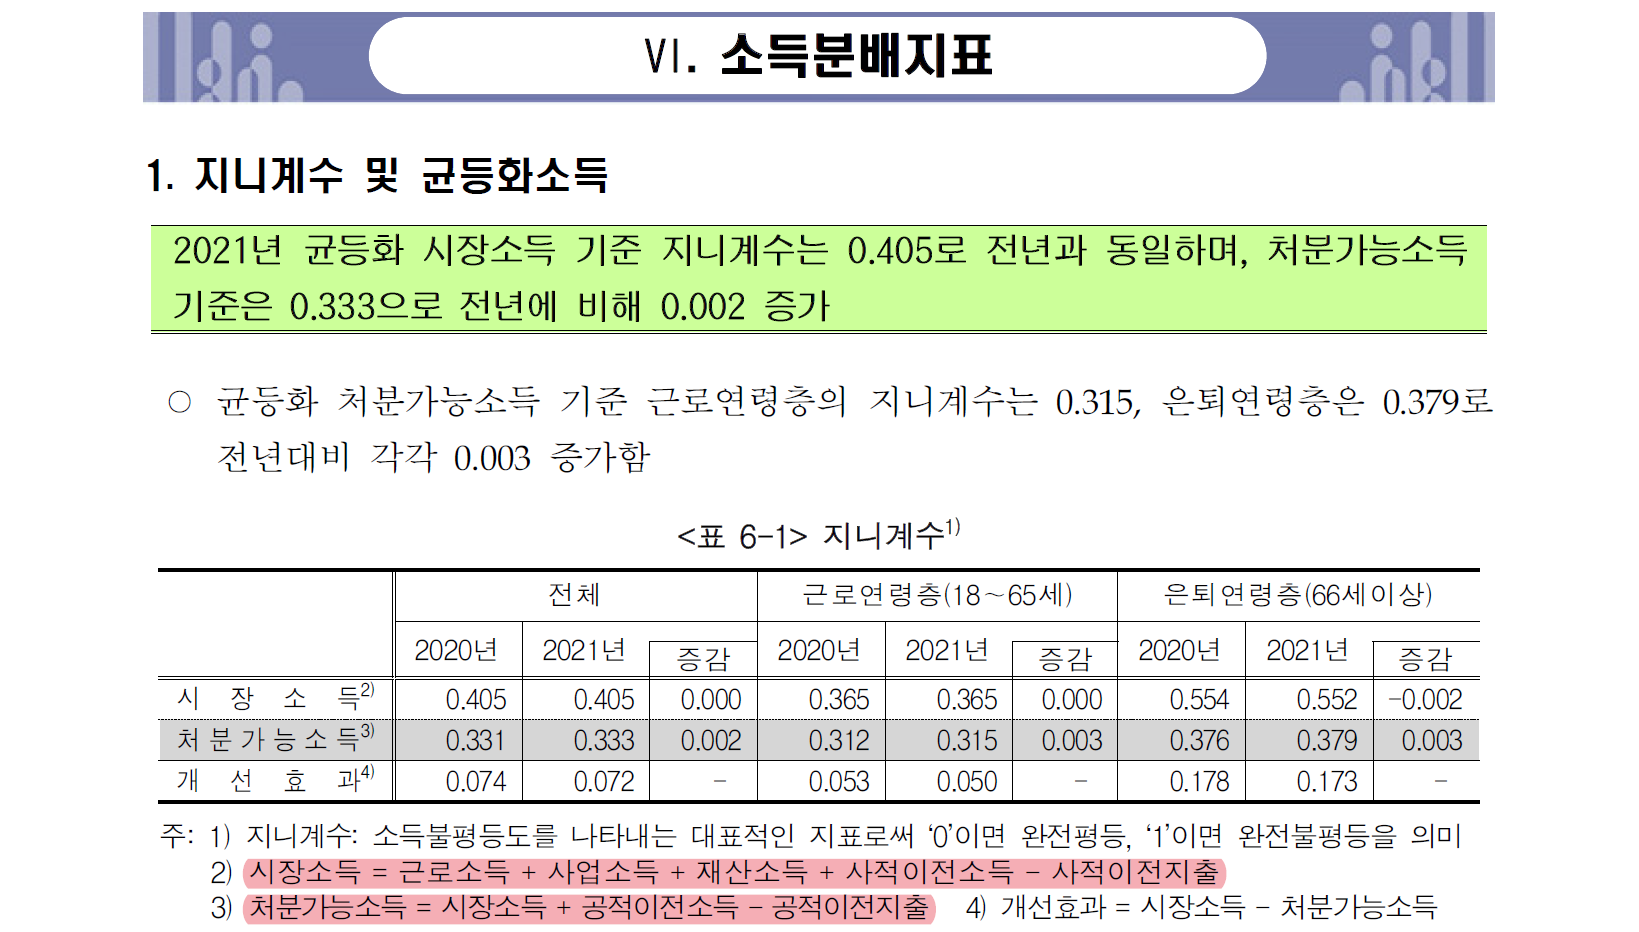

In [44]:
e1 = df_2022['지출_비소비지출(보완)']
e2 = df_2022['지출_비소비지출_세금(보완)']
e3 = df_2022['지출_비소비지출_공적연금사회보험료(보완)']
e4 = df_2022['지출_비소비지출_가구간이전지출(조사)']
e5 = df_2022['지출_비소비지출_비영리단체이전지출(조사)']
e6 = df_2022['지출_비소비지출_연간지급이자(조사)']

print('비소비지출(e1):', round(weighted_mean(e1, weight)))
print('비소비지출_세금(e2):', round(weighted_mean(e2, weight)))
print('공적연금사회보험료(e3):', round(weighted_mean(e3, weight)))
print('사적이전지출(e4+e5):', round(weighted_mean(e4+e5, weight)))
print('공적이전지출(e2+e3):', round(weighted_mean(e2+e3, weight)))

비소비지출(e1): 1185
비소비지출_세금(e2): 400
공적연금사회보험료(e3): 400
사적이전지출(e4+e5): 176
공적이전지출(e2+e3): 800


- 통계당국(통계청, 금융감독원, 한국은행) 분석 자료에 따르면,
- 시장소득 = 근로소득 + 사업소득 + 재산소득 + 사적이전소득 - 사적이전지출(가구간 및 비영리단체 이전지출)
- 기호로 표시하면, x1 = y2 + y3 + y4 + y6 - (e4 + e5)
- 처분가능소득 = 시장소득 + 공적이전소득 - 공적이전지출(세금, 공적연금 기여금, 사회보험료)
- 기호로 표시하면, x2 = x1 + y5 - (e2 + e3)
- 따라서 처분가능소득은 x2 = y2 + y3 + y4 + y5 + y6 - (e2 + e3 + e4 + e5)
- 그런데 가구소득은 (y2 + y3 + y4 + y5 + y6)이고, 비소비지출은 (e2 + e3 + e4 + e5 + e6)이기 때문에  처분가능소득은 가구소득(또는 경상소득)에서 (비소비지출-연간지급이자)을 뺀 것이다. 
- 한편, 가계금융복지조사 데이터세트의 "처분가능소득" 항목은 경상소득에서 비소비지출을 뺀 것이기 때문에 통계당국 분석 자료에 나오는 처분가능소득은 가계금융복지조사 데이터세트의 "처분가능소득" 항목에 연간지급이자를 더한 것에 해당한다.  

In [45]:
# 시장소득(근로소득 + 사업소득 + 재산소득 + 사적이전소득 - 사적이전지출(가구간 및 비영리단체 이전지출))
x1 = y2+y3+y4+y6-(e4+e5)
# 통계당국 처분가능소득(= 시장소득 + 공적이전소득 - 공적이전지출(세금, 공적연금 기여금, 사회보험료))
x2 = x1+y5-(e2+e3)
# 통계당국 처분가능소득(= 가계금융복지조사 "처분가능소득" 항목 + 연간지급이자)
x2_1 = y7 + e6

print('시장소득:', round(weighted_mean(x1, weight)))
print('처분가능소득(1):', round(weighted_mean(x2, weight)))
print('처분가능소득(2):', round(weighted_mean(x2_1, weight)))

시장소득: 5638
처분가능소득(1): 5438
처분가능소득(2): 5438


## 3. 지니 계수

- In economics, the **Gini coefficient**, also known as the Gini index or Gini ratio, is a measure of statistical dispersion intended to represent the income inequality, the wealth inequality, or the consumption inequality within a nation or a social group. It was developed by Italian statistician and sociologist Corrado Gini. (Wikipedia: [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient))

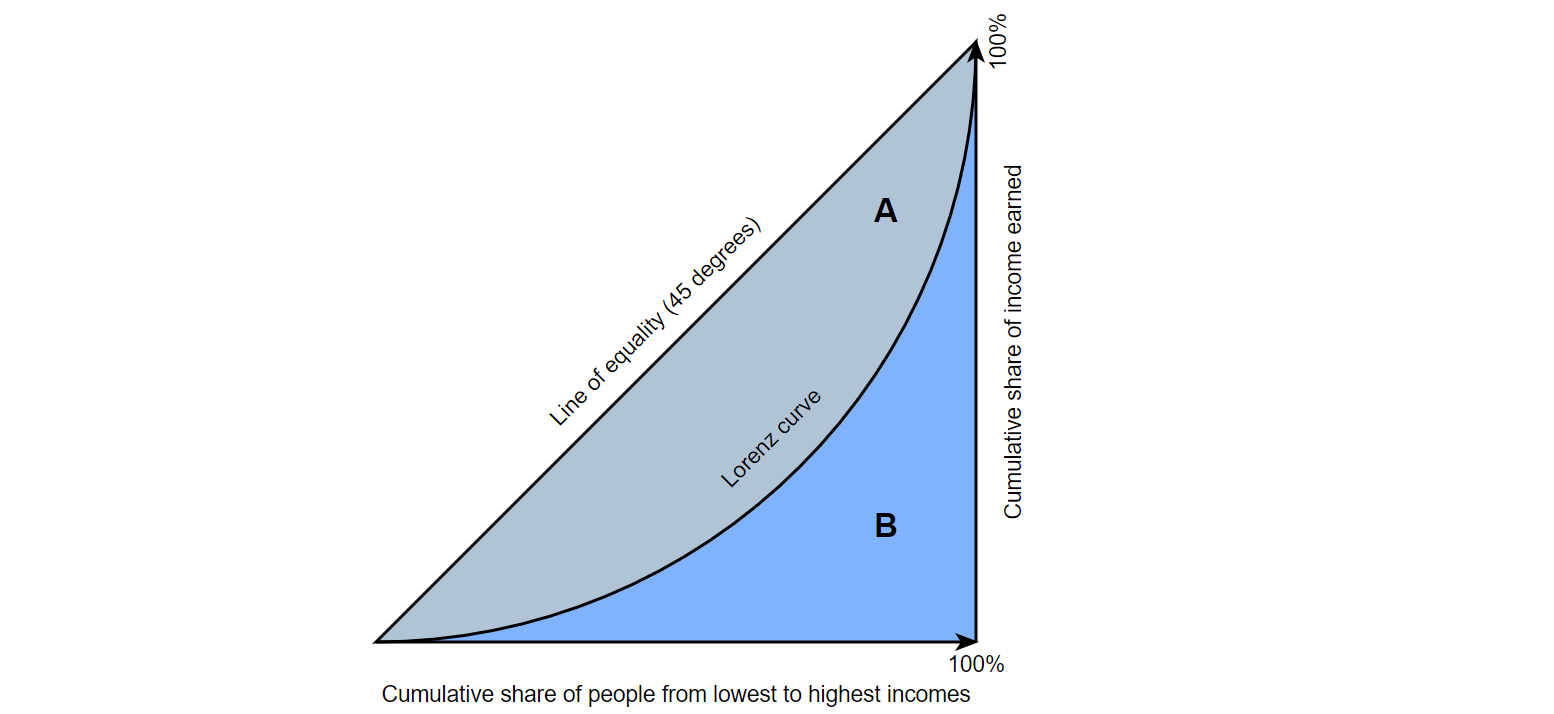

* The Gini coefficient is equal to the area marked $A$ divided by the total area of $A$ and $B$, i.e. $\text{Gini}=\tfrac{A}{A+B}$ . The axes run from 0 to 1, so $A$ and $B$ form a triangle of area $\tfrac{1}{2}$  and $\text{Gini} = 2A = 1-2B$.


* In some cases, this equation can be applied to calculate the Gini coefficient without direct reference to the Lorenz curve. For example, (taking $y$ to indicate the income or wealth of a person or household):


> For a population of $n$ individuals with values $y_1 \leq y_2\leq \cdots \leq y_n$,
> $G = \frac{2 \sum_{i=1}^n i y_i}{n \sum_{i=1}^n y_i} -\frac{n+1}{n}$.

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

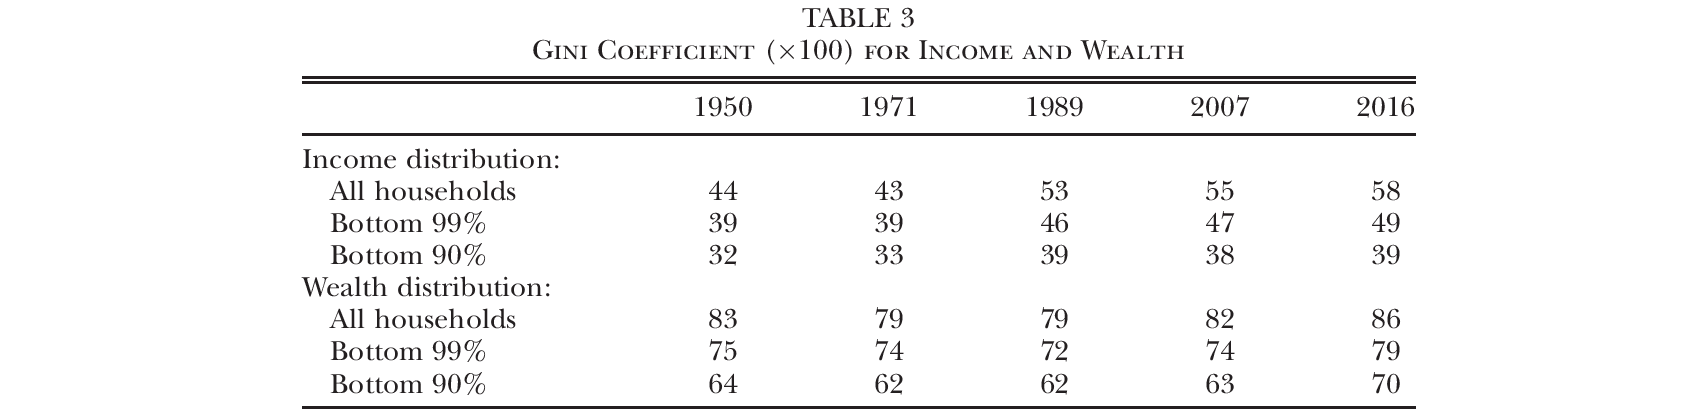

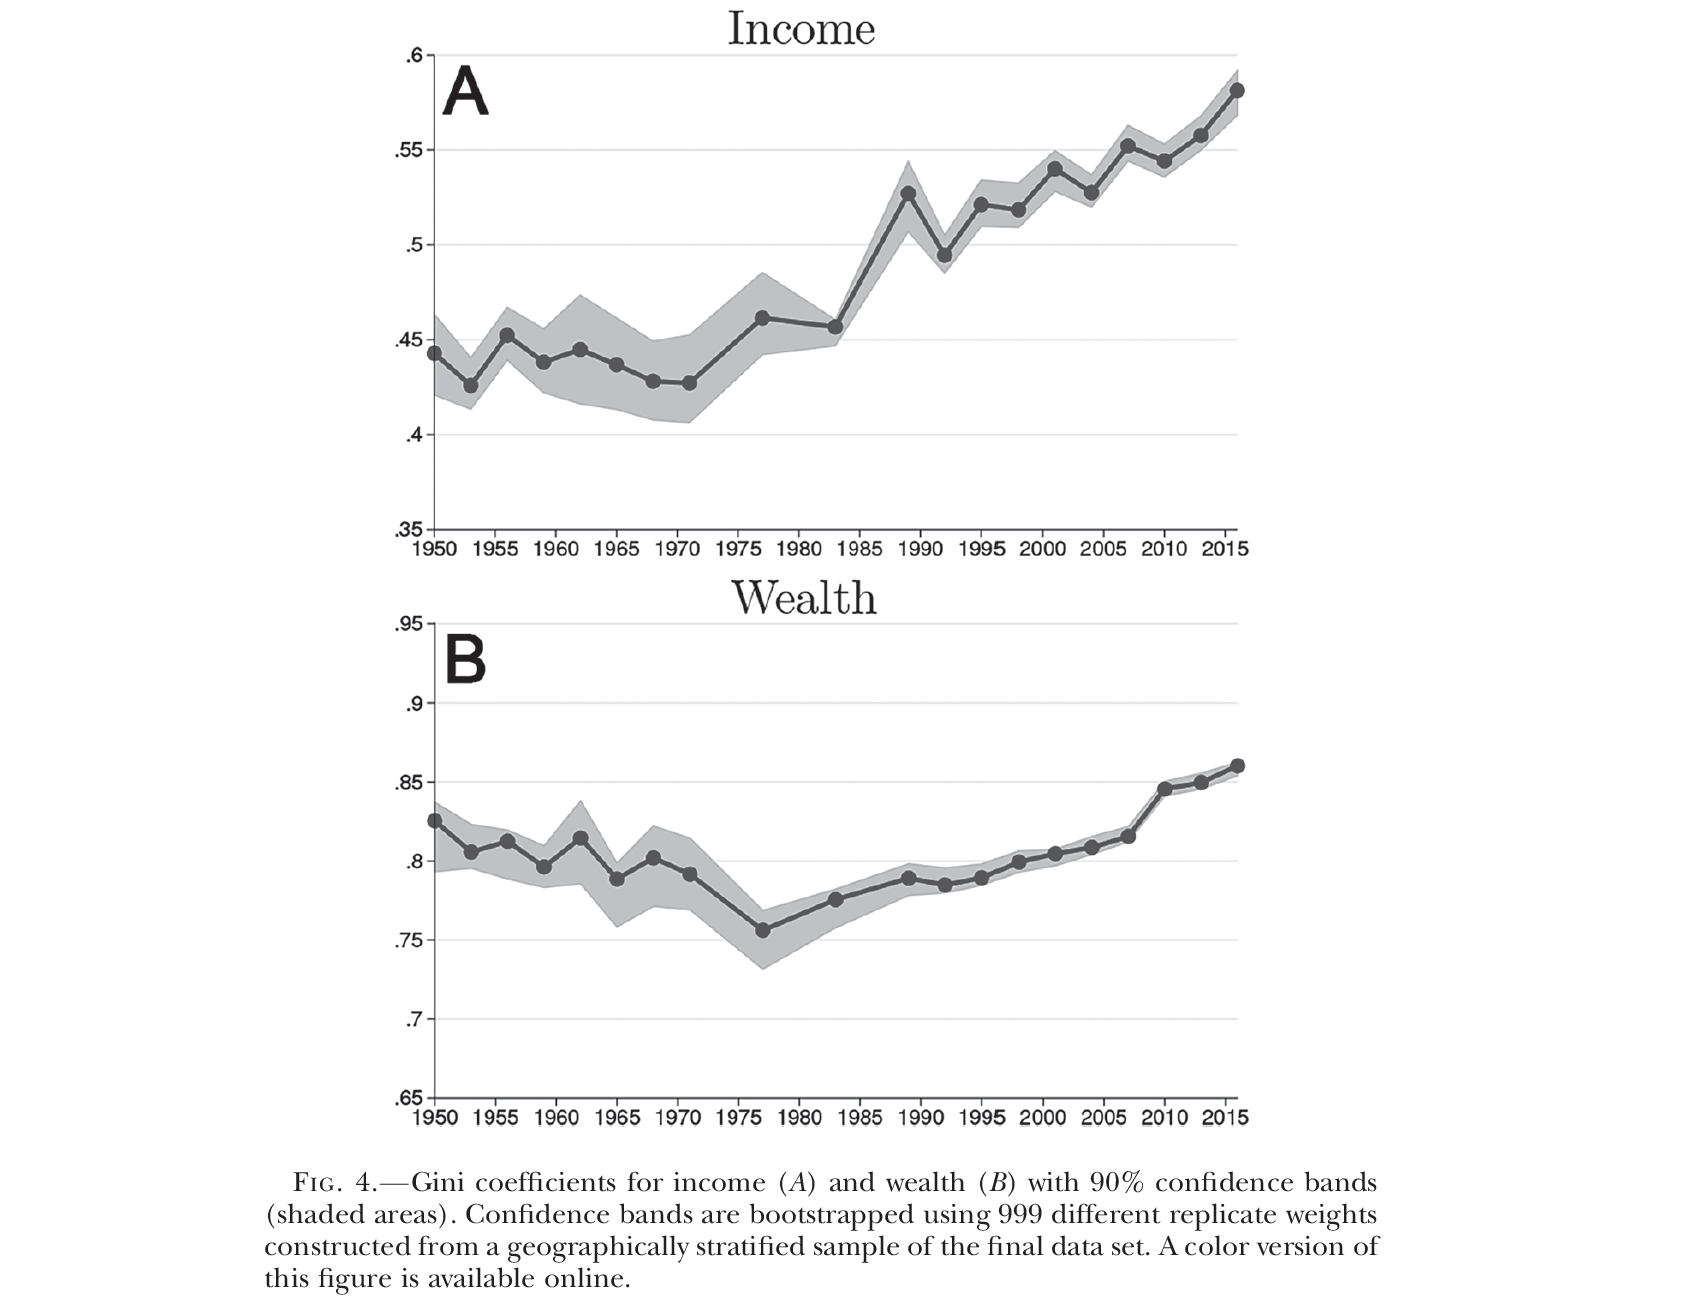

### (1) 2022년

### 재산 지니 계수

### gini_coefficient 함수

In [46]:
# 지니 계수 계산법 I

def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    coef = 0
    for i in range(n):
        coef += (i + 1) * sorted_x[i]
    coef = (2 * coef) / (n * np.sum(sorted_x)) - (n + 1) / n
    return coef

In [47]:
print(f"Gini Coefficient: {gini_coefficient(x)}")

Gini Coefficient: 0.6309255234233562


In [52]:
# 지니 계수 계산법 II

def gini_coefficient_lorenz(x):
    # 데이터를 오름차순으로 정렬
    sorted_x = np.sort(x)
    n = len(x)
    
    # Lorenz 곡선 생성
    lorenz_curve = np.cumsum(sorted_x) / np.sum(sorted_x)
    
    # 지니계수 계산
    gini_coeff = 1 - (2 * np.trapz(lorenz_curve) / n)
    
    return gini_coeff

In [53]:
print(f"Gini Coefficient: {gini_coefficient_lorenz(x)}")

Gini Coefficient: 0.6309255178041688


### 가중 지니 계수

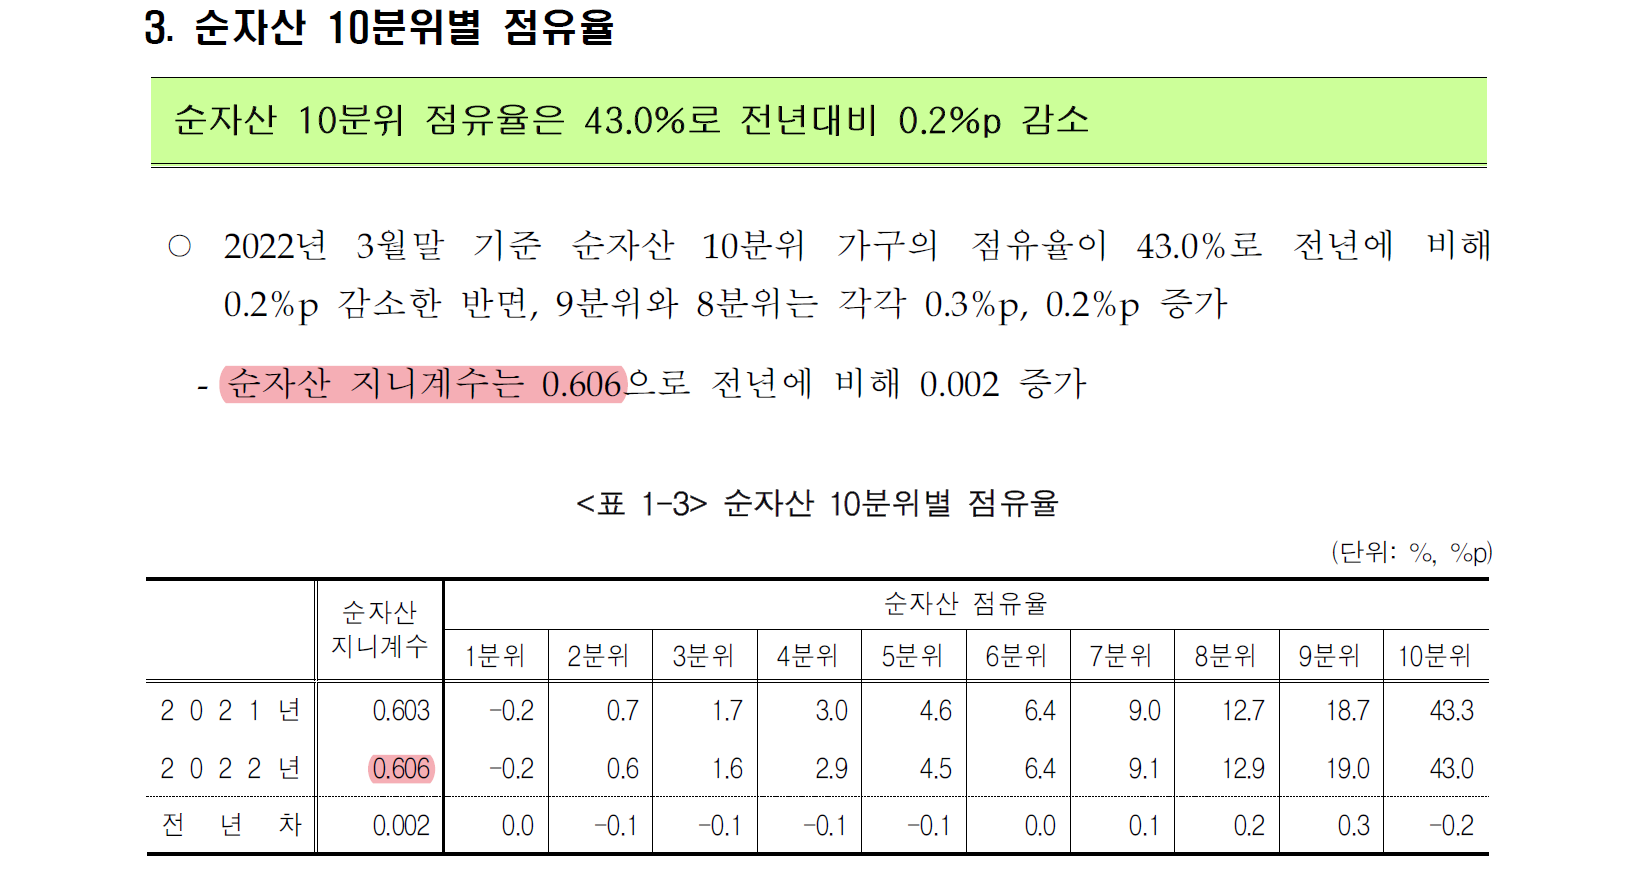

### 참고 자료

- [Lerman, R. I., & Yitzhaki, S. (1989). Improving the accuracy of estimates of Gini coefficients. Journal of econometrics, 42(1), 43-47.](https://d1wqtxts1xzle7.cloudfront.net/56629770/0304-4076_2889_2990074-220180522-9868-4wjdgx-libre.pdf?1527007254=&response-content-disposition=inline%3B+filename%3DImproving_the_accuracy_of_estimates_of_G.pdf&Expires=1698227066&Signature=PoPWuF7wOfhCPcmINKrojiqSPZ9DprF~HhrPcTY8g6UntsYvNgWBFiQjZfgE~G-4DQc2Wen50Z5xTOKKlrkai~36aYye57CEh1We7cWAtM3oU1eQjCr6Qb7akP24Wq4HCmgd7BpEGxW4YqFbGHGlamOW1elK6uVpiQHbzNmbLwm7ueky5GFbXxRGa8M4Dt-GyJpiQyX5ffWW5wLSyUvfZscgxnl97hCt6-5WN2BWzvbwBAXYjN8zfxq-i7sZZPdK~lOCJqazUGbZ8TesLg1l~OzLwBYZ9Ic0FBOo2Bo-h3PPsTdL6OcfVjlhIRU15sNPgSQi5esy2OgG8QO~mw07CQ__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)

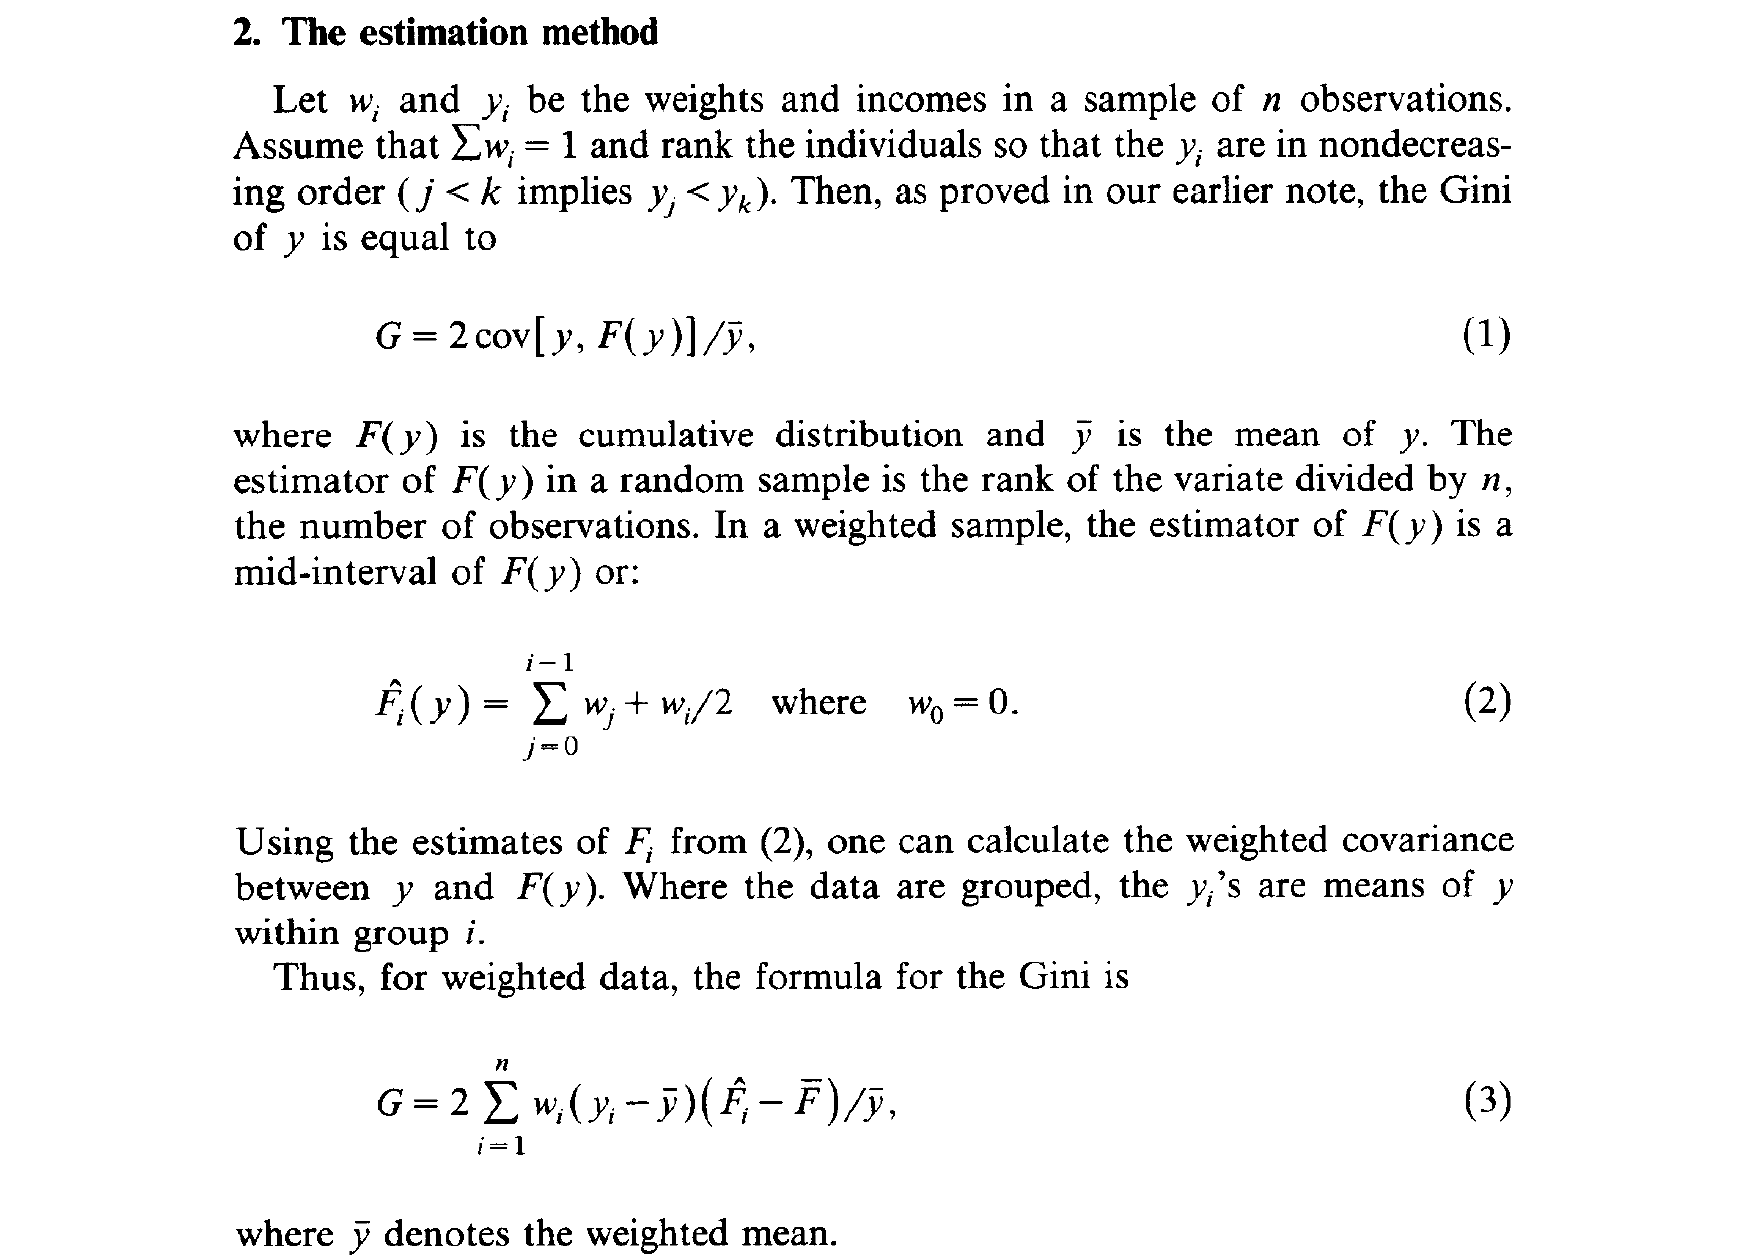

### weighted_gini 함수

- 자료: Lerman, R. I., & Yitzhaki, S. (1989). Improving the accuracy of estimates of Gini coefficients. Journal of econometrics, 42(1), 43-47.

In [58]:
# 2022년
x = df_2022['순자산']
weight = df_2022['가중값']

In [59]:
import numpy as np

def weighted_gini(x, w):
    # 데이터를 값 순서대로 정렬
    sorted_data = np.asarray([x, w]).T[np.argsort(x)]  # x 기준 오름차순으로 정렬
    sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
    # 총 가중치 및 누적 가중치 초기화
    total_weight = np.sum(sorted_w)
    sorted_w = sorted_w/total_weight
    cumulative_weight = np.cumsum(sorted_w)
     
    # 지니 계수 계산 항목
    sorted_x_dev = sorted_x - weighted_mean(sorted_x, sorted_w)
    
    f_hat = cumulative_weight.copy()    
    # f_hat 업데이트
    for i in range(len(f_hat)):
        if i == 0:            
            f_hat[i] = sorted_w[i] / 2
        else:
            f_hat[i] = cumulative_weight[i-1] + (sorted_w[i] / 2)

    f_hat_dev = f_hat - f_hat.mean()
    G = sorted_w*sorted_x_dev*f_hat_dev/(weighted_mean(sorted_x, sorted_w))
    weighted_gini = 2*G.sum()
   
    return weighted_gini 

In [60]:
result = weighted_gini(x, weight)
print("가중치를 고려한 지니 계수:", result) 

가중치를 고려한 지니 계수: 0.6099229357996474


In [61]:
# 2021년
x = df_2021['순자산']
weight = df_2021['가중값']
weighted_gini(x, weight)

0.6078719528264442

### (2) 전체 연도

### 전체 재산 지니 계수

In [63]:
# 연도 범위 설정 (2010년부터 2023년까지)
years = range(2010, 2024)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '지니 계수'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 가중치
    weight = df_year['가중값']
    
    # 지니 계수 계산
    gini = weighted_gini(x, weight)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], '지니 계수': [gini]})], 
                           ignore_index=True)

# 결과를 출력
gini_table

연도     지니 계수
0   2010  0.643432
1   2011  0.632480
2   2012  0.624853
3   2013  0.612701
4   2014  0.598822
5   2015  0.595184
6   2016  0.591519
7   2017  0.588894
8   2018  0.593258
9   2019  0.602468
10  2020  0.608496
11  2021  0.607872
12  2022  0.609923
13  2023  0.609317

#### 그래프 한글 표시

* 그래프에서 한글이 깨지는 것을 막기 위해서는 아래 명령문을 실행해야 한다.

In [64]:
import matplotlib
from matplotlib import font_manager, rc

font_path = "/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
matplotlib.rcParams['axes.unicode_minus'] = False  # 축에 마이너스 부호 제대로 나오게 하기

위 코드는 Windows에 해당하는 것이고, MacBook의 경우에는 위 명령문 세 번째 줄을 다음과 같이 바꿔야 한다.
```
font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
```

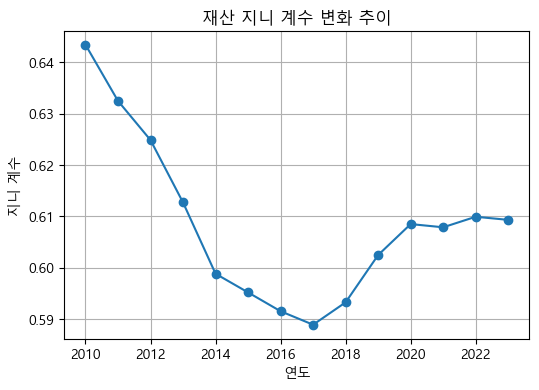

In [65]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
gini_coefficients = gini_table['지니 계수']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, gini_coefficients, marker='o', linestyle='-')
plt.title('재산 지니 계수 변화 추이')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# 그래프 표시
plt.show()

### 2030 재산 지니 계수

In [67]:
# 연도 범위 설정 (2010년부터 2023년까지)
years = range(2010, 2024)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '지니 계수'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 20/30대 
    df_2030 = df_year[df_year['가구주연령_10세단위코드'].isin(['G1', 'G2'])]

    # x 값을 계산
    x = df_2030['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 가중치
    weight = df_2030['가중값']
    
    # 지니 계수 계산
    gini = weighted_gini(x, weight)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], '지니 계수': [gini]})], 
                           ignore_index=True)

# 결과를 출력
gini_table

연도     지니 계수
0   2010  0.583050
1   2011  0.572788
2   2012  0.544956
3   2013  0.525907
4   2014  0.509188
5   2015  0.515971
6   2016  0.519521
7   2017  0.537534
8   2018  0.552074
9   2019  0.554623
10  2020  0.566590
11  2021  0.570448
12  2022  0.596980
13  2023  0.581932

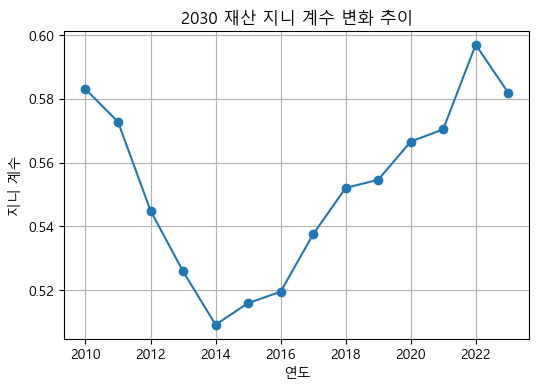

In [68]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
gini_coefficients = gini_table['지니 계수']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, gini_coefficients, marker='o', linestyle='-')
plt.title('2030 재산 지니 계수 변화 추이')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# 그래프 표시
plt.show()

### 전체 소득 지니 계수

In [69]:
# 연도 범위 설정 (2010년부터 2023년까지)
years = range(2010, 2024)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '지니 계수'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 가중치
    weight = df_year['가중값']
    
    # 지니 계수 계산
    gini = weighted_gini(x, weight)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], '지니 계수': [gini]})], 
                           ignore_index=True)

# 결과를 출력
gini_table

연도     지니 계수
0   2010  0.433686
1   2011  0.453805
2   2012  0.427650
3   2013  0.422294
4   2014  0.417371
5   2015  0.413415
6   2016  0.411177
7   2017  0.425839
8   2018  0.425811
9   2019  0.419805
10  2020  0.416496
11  2021  0.406417
12  2022  0.408877
13  2023  0.402404

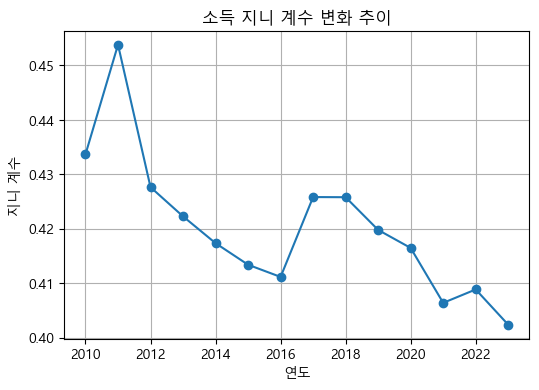

In [70]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
gini_coefficients = gini_table['지니 계수']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, gini_coefficients, marker='o', linestyle='-')
plt.title('소득 지니 계수 변화 추이')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# 그래프 표시
plt.show()

### 2030 소득 지니 계수

In [71]:
# 연도 범위 설정 (2010년부터 2023년까지)
years = range(2010, 2024)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '지니 계수'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 20/30대 
    df_2030 = df_year[df_year['가구주연령_10세단위코드'].isin(['G1', 'G2'])]

    # 통계당국 처분가능소득 계산
    x = df_2030[income_column] + df_2030[interest_payment]    

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 가중치
    weight = df_2030['가중값']
    
    # 지니 계수 계산
    gini = weighted_gini(x, weight)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], '지니 계수': [gini]})], 
                           ignore_index=True)

# 결과를 출력
gini_table

연도     지니 계수
0   2010  0.341384
1   2011  0.336809
2   2012  0.318999
3   2013  0.319648
4   2014  0.313450
5   2015  0.302998
6   2016  0.300147
7   2017  0.339751
8   2018  0.336298
9   2019  0.321993
10  2020  0.328773
11  2021  0.337595
12  2022  0.355630
13  2023  0.344645

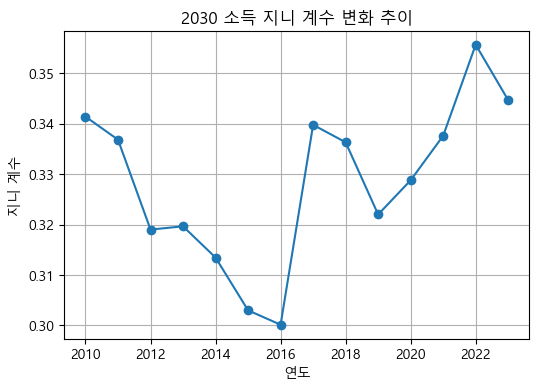

In [72]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
gini_coefficients = gini_table['지니 계수']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, gini_coefficients, marker='o', linestyle='-')
plt.title('2030 소득 지니 계수 변화 추이')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# 그래프 표시
plt.show()

### 최상위 가구를 제외한 지니 계수

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

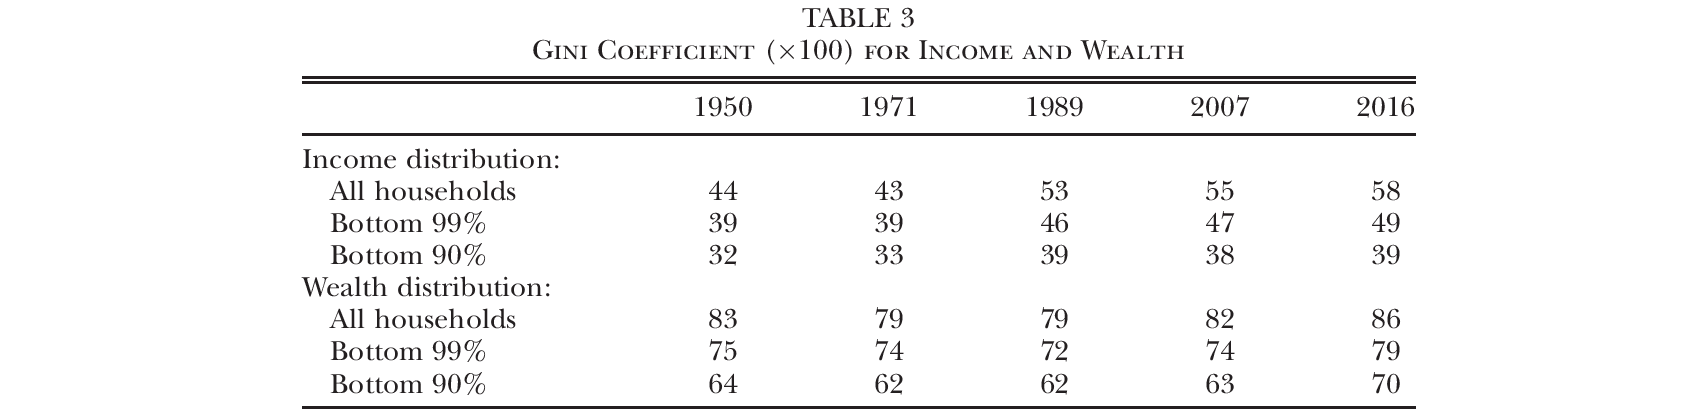

### (1) 2010년

#### 재산 최상위 10% 제외한 경우

In [46]:
import pandas as pd

# x와 weight Series 생성 (예시 데이터)
x = pd.Series([10, 20, 30, 40, 50])
weight = pd.Series([0.1, 0.2, 0.15, 0.3, 0.25])

# x와 weight를 데이터프레임으로 묶기
df = pd.DataFrame({'x': x, 'weight': weight})

# 특정 값(예: 25)보다 높은 행만 선택하여 새로운 데이터프레임 z 생성
threshold = 25
z = df[df['x'] > threshold]

# 결과 확인
print(z)

    x  weight
2  30    0.15
3  40    0.30
4  50    0.25


#### percentile 및 지니 계수 구할 때 가중치를 고려하지 않은 경우

In [47]:
# 2010년
x = df_2010['순자산']
weight = df_2010['가중값']

In [48]:
# 하위 90%의 데이터 추출
bottom_90 = x[x <= np.percentile(x, 90)]
bottom_90.describe()

count      9000.000000
mean      14565.529222
std       15873.199823
min     -479990.000000
25%        3294.250000
50%       10302.500000
75%       22295.500000
max       59764.000000
Name: 순자산, dtype: float64

In [49]:
# 하위 90% 데이터에 대해 Gini 계수 계산
gini_bottom_90 = gini_coefficient(bottom_90)
gini_bottom_90 

0.5449194082573445

#### percentile 및 지니 계수 구할 때 가중치를 고려한 경우

In [50]:
# x와 weight를 데이터프레임으로 묶기
df = pd.DataFrame({'x': x, 'weight': weight})

# x가 특정값 이하인 행만 남기기
z = df[df['x'] <= weighted_percentile(x, weight, 90)]

# 하위 90%의 데이터 추출
bottom_90 = z['x']
weight_90 = z['weight']
bottom_90.describe()

count      8821.000000
mean      13717.162793
std       14859.670818
min     -479990.000000
25%        3175.000000
50%       10004.000000
75%       21188.000000
max       53480.000000
Name: x, dtype: float64

In [51]:
# 하위 90% 데이터에 대해 Gini 계수 계산
gini_bottom_90 = weighted_gini(bottom_90, weight_90)
gini_bottom_90 

0.5389320447518233

### (2) 전체 연도

### 재산 그룹별 지니 계수

#### A. Without Weights

In [52]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '전체', '하위 99%', '하위 90%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 하위 90% 및 99%의 데이터 추출
    bottom_99 = x[x <= np.percentile(x, 99)]
    bottom_90 = x[x <= np.percentile(x, 90)]

    # 지니 계수 계산
    gini_all = gini_coefficient(x)
    gini_bottom_99 = gini_coefficient(bottom_99)
    gini_bottom_90 = gini_coefficient(bottom_90)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], 
                                          '전체': [gini_all], 
                                          '하위 99%': [gini_bottom_99], 
                                          '하위 90%': [gini_bottom_90]})],
                           ignore_index=True)

# 결과를 출력
print(gini_table)

      연도        전체    하위 99%    하위 90%
0   2010  0.658917  0.618201  0.544919
1   2011  0.643609  0.602702  0.534134
2   2012  0.641801  0.599527  0.523312
3   2013  0.628664  0.586469  0.513943
4   2014  0.614012  0.573676  0.504294
5   2015  0.612687  0.572436  0.504139
6   2016  0.612136  0.572255  0.506786
7   2017  0.610023  0.572634  0.506292
8   2018  0.615091  0.577486  0.509136
9   2019  0.620383  0.582833  0.513271
10  2020  0.621725  0.584504  0.517070
11  2021  0.626112  0.591802  0.526094
12  2022  0.630926  0.597452  0.533083


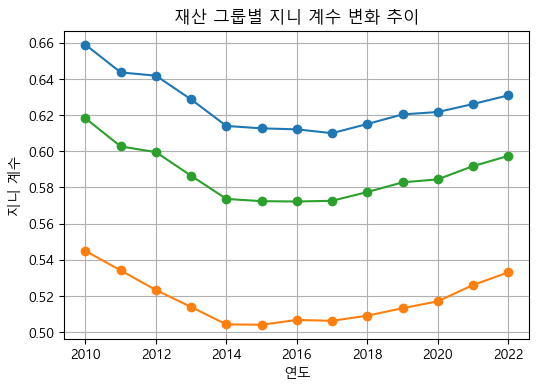

In [53]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
gini_coefficients = gini_table[['전체', '하위 90%', '하위 99%']]

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, gini_coefficients, marker='o', linestyle='-')
plt.title('재산 그룹별 지니 계수 변화 추이')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# 그래프 표시
plt.show()

#### B. With Weights

In [54]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '전체', '하위 99%', '하위 90%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 가중치 지정
    weight = df_year['가중값']
    
    # x와 weight를 데이터프레임으로 묶기
    df = pd.DataFrame({'x': x, 'weight': weight})
    
    # 하위 90% 및 99%의 데이터 추출
    z_99 = df[df['x'] <= weighted_percentile(x, weight, 99)]
    bottom_99 = z_99['x']
    weight_99 = z_99['weight']
    z_90 = df[df['x'] <= weighted_percentile(x, weight, 90)]
    bottom_90 = z_90['x']
    weight_90 = z_90['weight']
    
    # 지니 계수 계산
    gini_all = weighted_gini(x, weight)
    gini_bottom_99 = weighted_gini(bottom_99, weight_99)
    gini_bottom_90 = weighted_gini(bottom_90, weight_90)

    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], 
                                          '전체': [gini_all], 
                                          '하위 99%': [gini_bottom_99], 
                                          '하위 90%': [gini_bottom_90]})],
                           ignore_index=True)

# 결과를 출력
gini_table

연도        전체    하위 99%    하위 90%
0   2010  0.643432  0.602397  0.538932
1   2011  0.632480  0.593063  0.529884
2   2012  0.624853  0.584613  0.513828
3   2013  0.612701  0.573078  0.506474
4   2014  0.598822  0.560165  0.495023
5   2015  0.595184  0.557318  0.493392
6   2016  0.591519  0.555226  0.495425
7   2017  0.588894  0.555885  0.495205
8   2018  0.593258  0.560532  0.497928
9   2019  0.602468  0.568125  0.503904
10  2020  0.608496  0.574344  0.510845
11  2021  0.607872  0.576744  0.515836
12  2022  0.609923  0.580419  0.523046

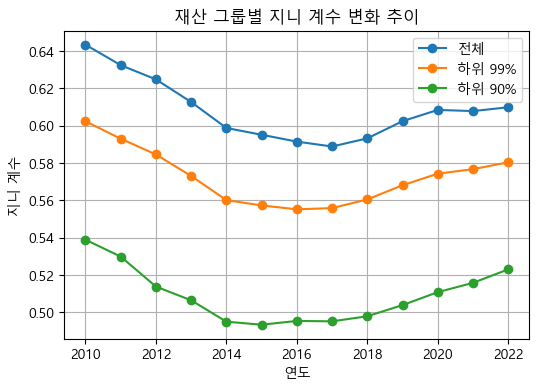

In [56]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
gini_total = gini_table['전체']
gini_99 = gini_table['하위 99%']
gini_90 = gini_table['하위 90%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, gini_total, marker='o', linestyle='-', label='전체')
plt.plot(years, gini_99, marker='o', linestyle='-', label='하위 99%')
plt.plot(years, gini_90, marker='o', linestyle='-', label='하위 90%')
plt.title('재산 그룹별 지니 계수 변화 추이')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

### 소득 그룹별 지니 계수

#### A. Without Weights

In [57]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '전체', '하위 99%', '하위 90%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 하위 90% 및 99%의 데이터 추출
    bottom_99 = x[x <= np.percentile(x, 99)]
    bottom_90 = x[x <= np.percentile(x, 90)]

    # 지니 계수 계산
    gini_all = gini_coefficient(x)
    gini_bottom_99 = gini_coefficient(bottom_99)
    gini_bottom_90 = gini_coefficient(bottom_90)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], 
                                          '전체': [gini_all], 
                                          '하위 99%': [gini_bottom_99], 
                                          '하위 90%': [gini_bottom_90]})],
                           ignore_index=True)

# 결과를 출력
gini_table

연도        전체    하위 99%    하위 90%
0   2010  0.443555  0.416558  0.365979
1   2011  0.459097  0.423034  0.376728
2   2012  0.438426  0.409698  0.361695
3   2013  0.441181  0.412705  0.367612
4   2014  0.434663  0.409881  0.366555
5   2015  0.432296  0.410313  0.367045
6   2016  0.431798  0.409272  0.367282
7   2017  0.446215  0.420993  0.378181
8   2018  0.445077  0.420857  0.376311
9   2019  0.436550  0.415925  0.372266
10  2020  0.428711  0.408548  0.365887
11  2021  0.423374  0.401631  0.357157
12  2022  0.430575  0.408609  0.361326

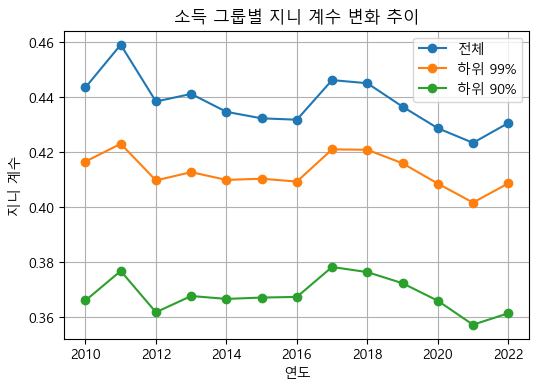

In [58]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
gini_total = gini_table['전체']
gini_99 = gini_table['하위 99%']
gini_90 = gini_table['하위 90%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, gini_total, marker='o', linestyle='-', label='전체')
plt.plot(years, gini_99, marker='o', linestyle='-', label='하위 99%')
plt.plot(years, gini_90, marker='o', linestyle='-', label='하위 90%')
plt.title('소득 그룹별 지니 계수 변화 추이')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### B. With Weights

In [59]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '전체', '하위 99%', '하위 90%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 가중치 지정
    weight = df_year['가중값']
    
    # x와 weight를 데이터프레임으로 묶기
    df = pd.DataFrame({'x': x, 'weight': weight})
    
    # 하위 90% 및 99%의 데이터 추출
    z_99 = df[df['x'] <= weighted_percentile(x, weight, 99)]
    bottom_99 = z_99['x']
    weight_99 = z_99['weight']
    z_90 = df[df['x'] <= weighted_percentile(x, weight, 90)]
    bottom_90 = z_90['x']
    weight_90 = z_90['weight']
    
    # 지니 계수 계산
    gini_all = weighted_gini(x, weight)
    gini_bottom_99 = weighted_gini(bottom_99, weight_99)
    gini_bottom_90 = weighted_gini(bottom_90, weight_90)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], 
                                          '전체': [gini_all], 
                                          '하위 99%': [gini_bottom_99], 
                                          '하위 90%': [gini_bottom_90]})],
                           ignore_index=True)

# 결과를 출력
gini_table

연도        전체    하위 99%    하위 90%
0   2010  0.433686  0.409261  0.362491
1   2011  0.453805  0.417753  0.373967
2   2012  0.427650  0.400271  0.355414
3   2013  0.422294  0.395716  0.353198
4   2014  0.417371  0.393167  0.351367
5   2015  0.413415  0.392487  0.351231
6   2016  0.411177  0.390192  0.350044
7   2017  0.425839  0.402827  0.362272
8   2018  0.425811  0.404456  0.361966
9   2019  0.419805  0.400663  0.358724
10  2020  0.416496  0.395647  0.354553
11  2021  0.406417  0.384110  0.342187
12  2022  0.408877  0.389568  0.345775

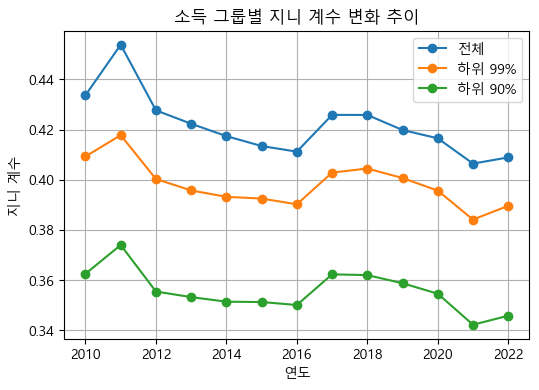

In [60]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
gini_total = gini_table['전체']
gini_99 = gini_table['하위 99%']
gini_90 = gini_table['하위 90%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, gini_total, marker='o', linestyle='-', label='전체')
plt.plot(years, gini_99, marker='o', linestyle='-', label='하위 99%')
plt.plot(years, gini_90, marker='o', linestyle='-', label='하위 90%')
plt.title('소득 그룹별 지니 계수 변화 추이')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

## 4. 분위별 재산 및 소득 점유율

### 최상위 그룹 재산 점유율

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

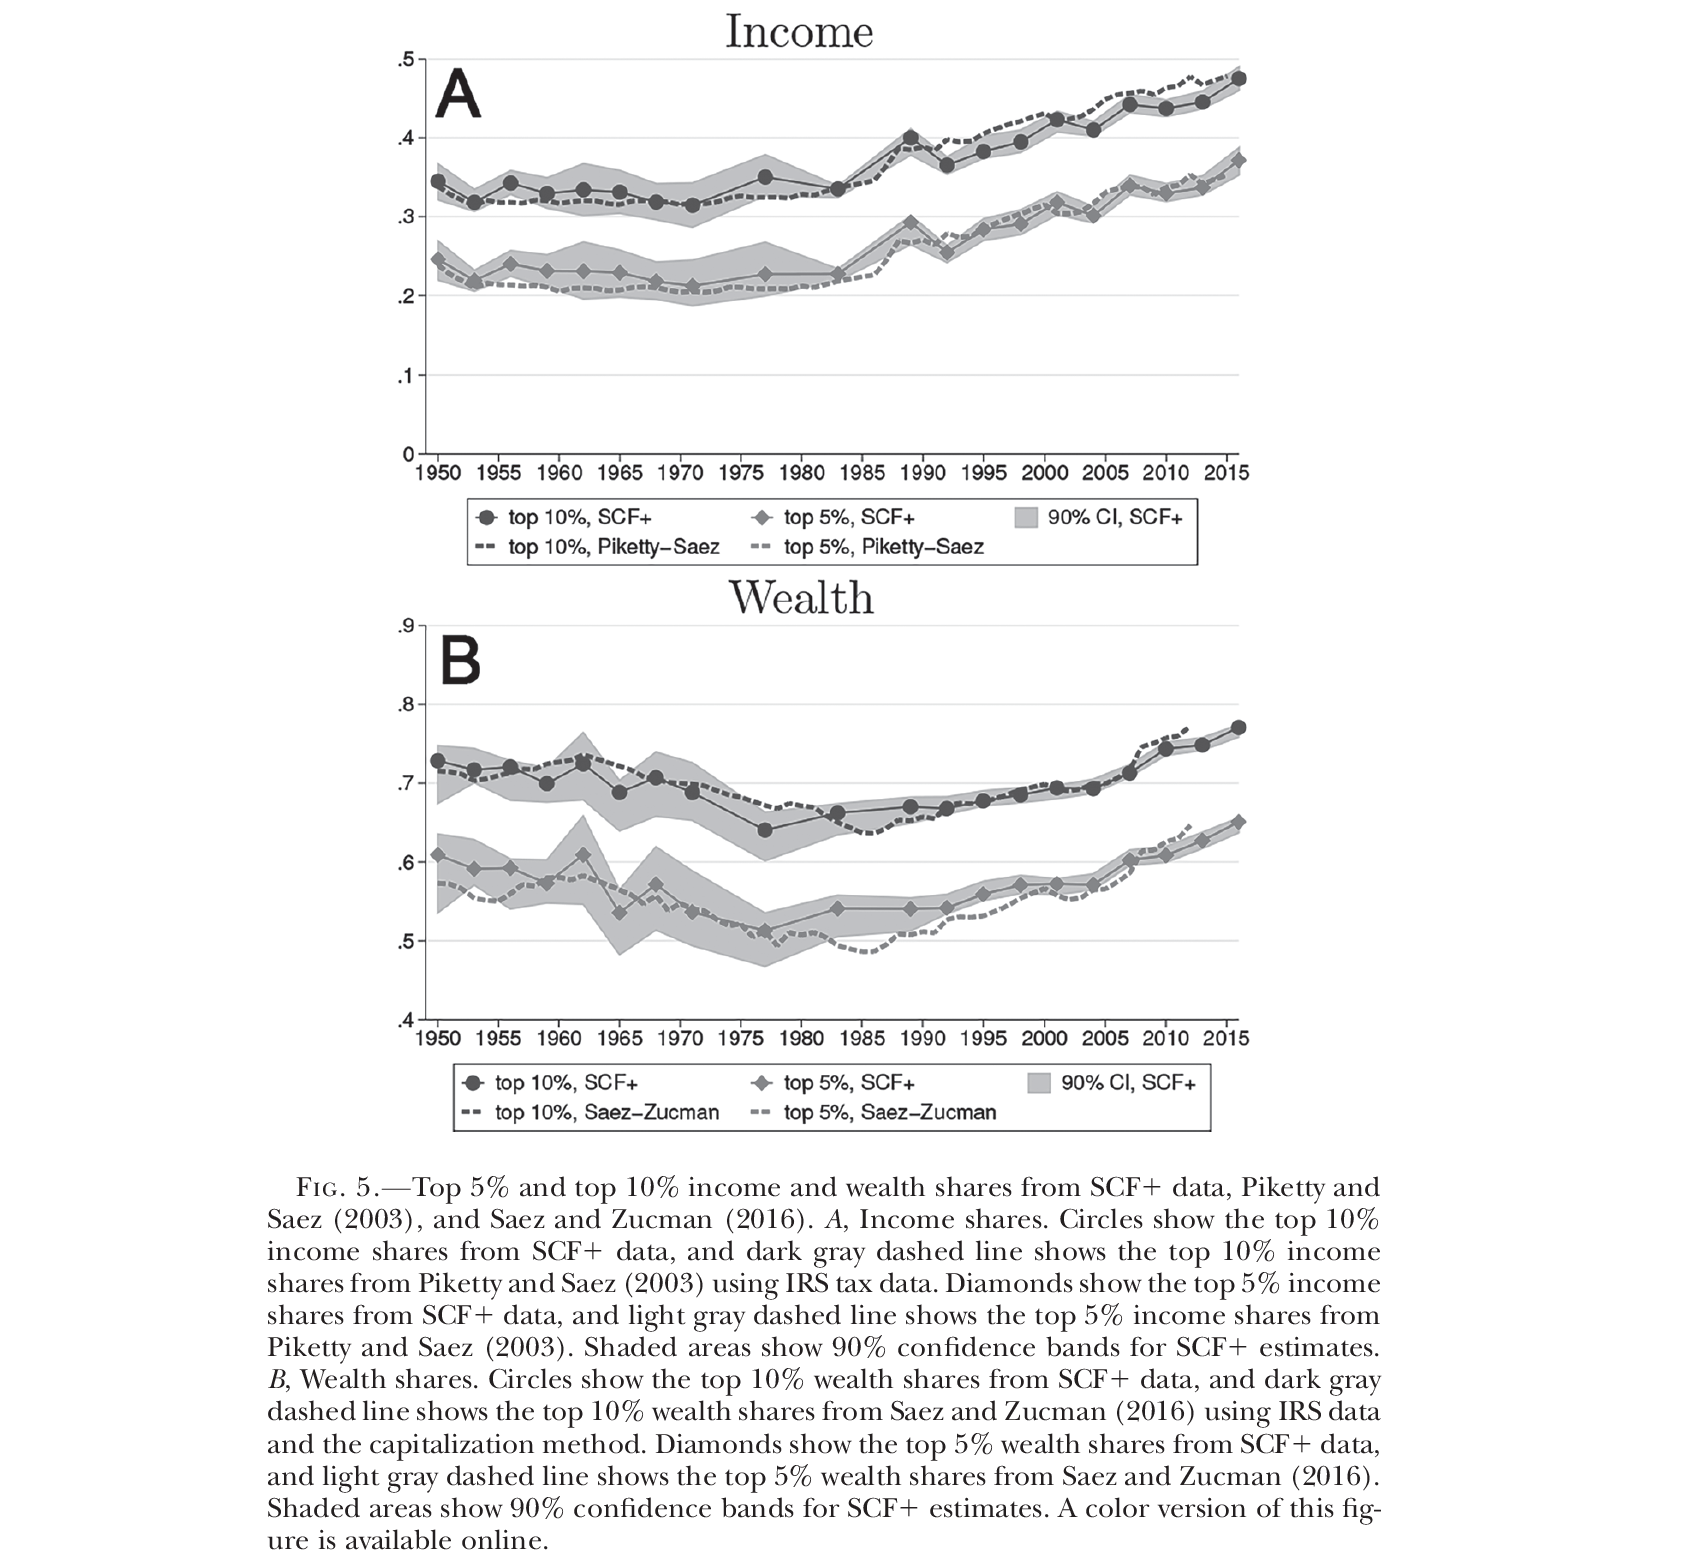

### 하위 그룹의 재산 및 소득 점유율

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

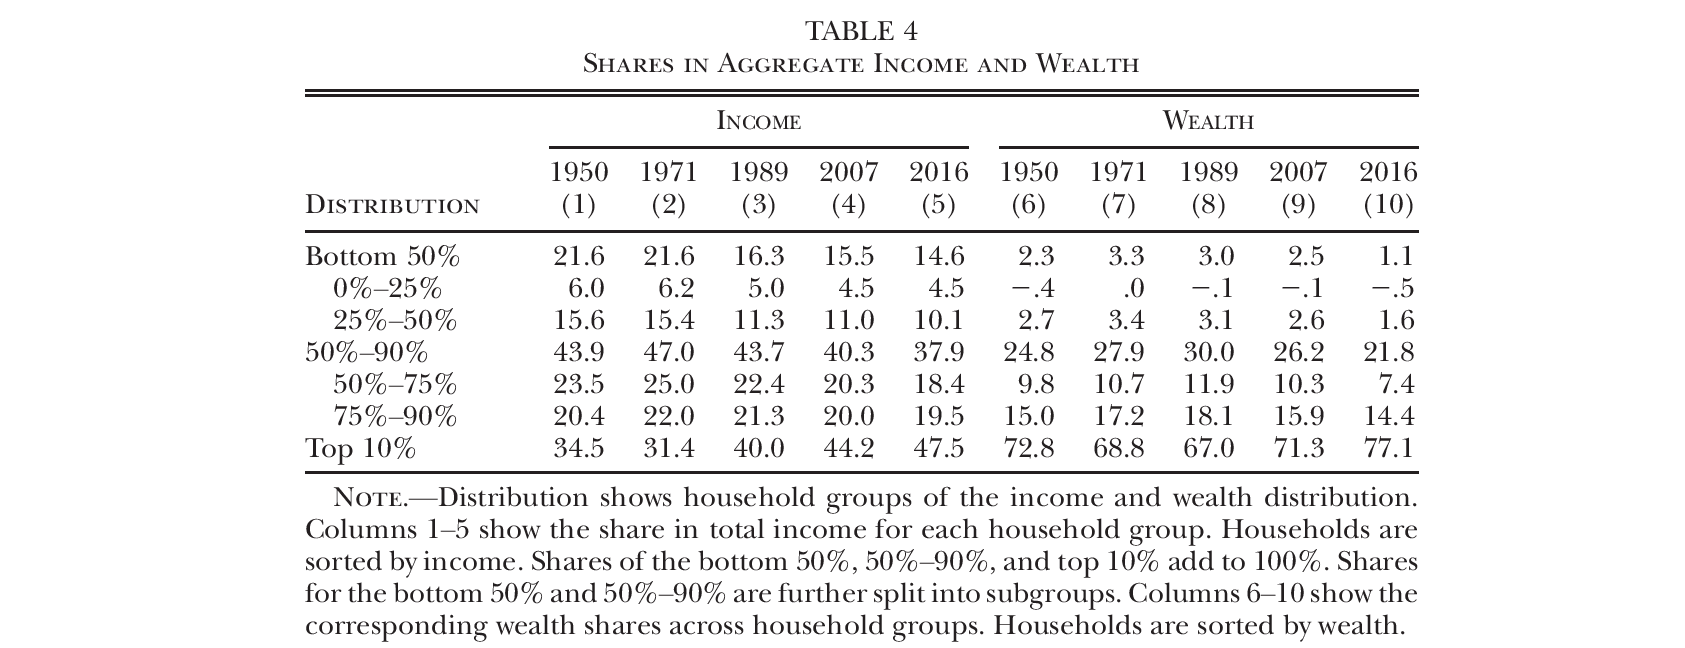

### 재산 분위별 점유율

#### A. Without Weights

In [61]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
share_table = pd.DataFrame(columns=['연도', '하위 50%', '0%-25%', '25%-50%', 
                                   '50%-90%', '50%-75%', '75%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 점유율 계산
    share_0_50 = sub_share(x, 0, 50)
    share_0_25 = sub_share(x, 0, 25)
    share_25_50 = sub_share(x, 25, 50)
    share_50_90 = sub_share(x, 50, 90)
    share_50_75 = sub_share(x, 50, 75)
    share_75_90 = sub_share(x, 75, 90)
    share_90_100 = sub_share(x, 90, 100)

    # 결과를 데이터프레임에 추가
    share_table = pd.concat([share_table, 
                            pd.DataFrame({'연도': [year], 
                                          '하위 50%': [share_0_50], 
                                          '0%-25%': [share_0_25], 
                                          '25%-50%': [share_25_50], 
                                          '50%-90%': [share_50_90], 
                                          '50%-75%': [share_50_75], 
                                          '75%-90%': [share_75_90], 
                                          '최상위 10%': [share_90_100]})],
                           ignore_index=True)

# 결과를 출력
share_table

연도     하위 50%    0%-25%   25%-50%    50%-90%    50%-75%    75%-90%  \
0   2010   8.191722  0.685021  7.506701  42.522030  18.622878  23.899152   
1   2011   8.715535  0.729612  7.985923  43.818125  19.854445  23.963680   
2   2012   8.881812  0.959621  7.922191  42.912167  19.254489  23.657678   
3   2013   9.459327  1.099026  8.360302  43.878234  20.026391  23.851843   
4   2014  10.132526  1.307579  8.824947  44.826770  20.578680  24.248090   
5   2015  10.142687  1.263594  8.879093  45.028757  20.742414  24.286343   
6   2016  10.041398  1.195748  8.845650  45.445623  21.059349  24.386274   
7   2017  10.073293  1.239346  8.833947  45.657477  21.084552  24.572925   
8   2018   9.901060  1.223318  8.677742  45.209172  20.692335  24.516837   
9   2019   9.675174  1.138593  8.536581  44.858671  20.393866  24.464805   
10  2020   9.562344  1.042215  8.520129  45.078565  20.471122  24.607443   
11  2021   9.106217  1.049470  8.056746  45.430803  20.264841  25.165962   
12  2022   8.758756  0.987378  7.771378  45.494373  20.091696  25.402677   

      최상위 10%  
0   49.471261  
1   47.634118  
2   48.235734  
3   46.702848  
4   45.066473  
5   44.855455  
6   44.548891  
7   44.289486  
8   44.909280  
9   45.489933  
10  45.381367  
11  45.472038  
12  45.756959

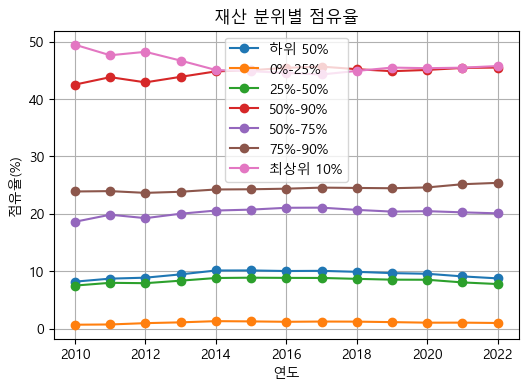

In [62]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = share_table['연도']
share_0_50 = share_table['하위 50%']
share_0_25 = share_table['0%-25%']
share_25_50 = share_table['25%-50%']
share_50_90 = share_table['50%-90%']
share_50_75 = share_table['50%-75%']
share_75_90 = share_table['75%-90%']
share_90_100 = share_table['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, share_0_50, marker='o', linestyle='-', label='하위 50%')
plt.plot(years, share_0_25, marker='o', linestyle='-', label='0%-25%')
plt.plot(years, share_25_50, marker='o', linestyle='-', label='25%-50%')
plt.plot(years, share_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, share_50_75, marker='o', linestyle='-', label='50%-75%')
plt.plot(years, share_75_90, marker='o', linestyle='-', label='75%-90%')
plt.plot(years, share_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('재산 분위별 점유율')
plt.xlabel('연도')
plt.ylabel('점유율(%)')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### B. With Weights

* 앞에서 만들어놓은 `weighted_sub_share()` 함수 사용

In [63]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
share_table = pd.DataFrame(columns=['연도', '하위 50%', '0%-25%', '25%-50%', 
                                   '50%-90%', '50%-75%', '75%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)

    # 가중치 지정
    weight = df_year['가중값']
    
    # 점유율 계산
    share_0_50 = weighted_sub_share(x, weight, 0, 50)
    share_0_25 = weighted_sub_share(x, weight, 0, 25)
    share_25_50 = weighted_sub_share(x, weight, 25, 50)
    share_50_90 = weighted_sub_share(x, weight, 50, 90)
    share_50_75 = weighted_sub_share(x, weight, 50, 75)
    share_75_90 = weighted_sub_share(x, weight, 75, 90)
    share_90_100 = weighted_sub_share(x, weight, 90, 100)

    # 결과를 데이터프레임에 추가
    share_table = pd.concat([share_table, 
                            pd.DataFrame({'연도': [year], 
                                          '하위 50%': [share_0_50], 
                                          '0%-25%': [share_0_25], 
                                          '25%-50%': [share_25_50], 
                                          '50%-90%': [share_50_90], 
                                          '50%-75%': [share_50_75], 
                                          '75%-90%': [share_75_90], 
                                          '최상위 10%': [share_90_100]})],
                           ignore_index=True)

# 결과를 출력
round(share_table,2)

연도  하위 50%  0%-25%  25%-50%  50%-90%  50%-75%  75%-90%  최상위 10%
0   2010    8.78    0.72     8.06    44.21    19.75    24.46    47.23
1   2011    9.10    0.74     8.36    45.01    20.65    24.36    46.06
2   2012    9.61    1.15     8.45    44.30    20.16    24.14    46.15
3   2013   10.15    1.28     8.88    45.27    20.93    24.34    44.67
4   2014   10.79    1.51     9.28    45.90    21.29    24.61    43.32
5   2015   10.93    1.49     9.44    46.20    21.55    24.65    42.90
6   2016   10.95    1.42     9.52    46.96    22.08    24.88    42.14
7   2017   10.98    1.43     9.55    47.24    22.18    25.06    41.79
8   2018   10.83    1.40     9.43    46.90    21.87    25.03    42.29
9   2019   10.44    1.30     9.14    46.28    21.37    24.92    43.32
10  2020   10.10    1.15     8.95    46.23    21.22    25.01    43.71
11  2021    9.88    1.23     8.65    46.87    21.20    25.67    43.26
12  2022    9.54    1.13     8.42    47.43    21.36    26.07    43.03

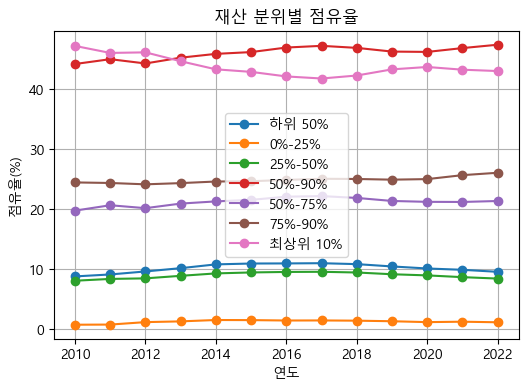

In [64]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = share_table['연도']
share_0_50 = share_table['하위 50%']
share_0_25 = share_table['0%-25%']
share_25_50 = share_table['25%-50%']
share_50_90 = share_table['50%-90%']
share_50_75 = share_table['50%-75%']
share_75_90 = share_table['75%-90%']
share_90_100 = share_table['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, share_0_50, marker='o', linestyle='-', label='하위 50%')
plt.plot(years, share_0_25, marker='o', linestyle='-', label='0%-25%')
plt.plot(years, share_25_50, marker='o', linestyle='-', label='25%-50%')
plt.plot(years, share_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, share_50_75, marker='o', linestyle='-', label='50%-75%')
plt.plot(years, share_75_90, marker='o', linestyle='-', label='75%-90%')
plt.plot(years, share_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('재산 분위별 점유율')
plt.xlabel('연도')
plt.ylabel('점유율(%)')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

### 소득 분위별 점유율

#### A. Without Weights

In [65]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
share_table = pd.DataFrame(columns=['연도', '하위 50%', '0%-25%', '25%-50%', 
                                   '50%-90%', '50%-75%', '75%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 점유율 계산
    share_0_50 = sub_share(x, 0, 50)
    share_0_25 = sub_share(x, 0, 25)
    share_25_50 = sub_share(x, 25, 50)
    share_50_90 = sub_share(x, 50, 90)
    share_50_75 = sub_share(x, 50, 75)
    share_75_90 = sub_share(x, 75, 90)
    share_90_100 = sub_share(x, 90, 100)

    # 결과를 데이터프레임에 추가
    share_table = pd.concat([share_table, 
                            pd.DataFrame({'연도': [year], 
                                          '하위 50%': [share_0_50], 
                                          '0%-25%': [share_0_25], 
                                          '25%-50%': [share_25_50], 
                                          '50%-90%': [share_50_90], 
                                          '50%-75%': [share_50_75], 
                                          '75%-90%': [share_75_90], 
                                          '최상위 10%': [share_90_100]})],
                           ignore_index=True)

# 결과를 출력
share_table

연도     하위 50%    0%-25%    25%-50%    50%-90%    50%-75%    75%-90%  \
0   2010  19.849906  5.309691  14.540215  49.245026  25.397571  23.847456   
1   2011  19.057704  4.690822  14.366882  48.936401  25.296316  23.640085   
2   2012  20.112843  5.450071  14.662772  49.324997  25.523221  23.801776   
3   2013  19.855797  5.180518  14.675279  49.723887  25.798500  23.925387   
4   2014  20.126201  5.138276  14.987926  50.216794  26.195329  24.021466   
5   2015  20.161365  5.235394  14.925972  50.496421  26.197494  24.298927   
6   2016  20.147275  5.285517  14.861758  50.616840  26.228909  24.387930   
7   2017  19.260543  5.065400  14.195143  50.502929  25.962596  24.540333   
8   2018  19.358138  5.161459  14.196679  50.372481  25.807809  24.564672   
9   2019  19.763487  5.388329  14.375158  50.743378  26.071483  24.671895   
10  2020  20.191232  5.677266  14.513966  50.864640  26.315089  24.549551   
11  2021  20.679991  6.080400  14.599591  50.380131  26.065140  24.314991   
12  2022  20.266121  5.895508  14.370613  50.106942  25.728834  24.378108   

      최상위 10%  
0   30.951231  
1   32.051169  
2   30.566400  
3   30.450006  
4   29.684029  
5   29.345795  
6   29.238823  
7   30.288858  
8   30.301584  
9   29.529426  
10  28.988576  
11  28.991161  
12  29.637503

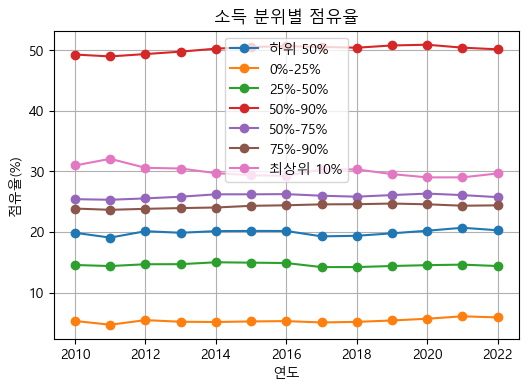

In [66]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = share_table['연도']
share_0_50 = share_table['하위 50%']
share_0_25 = share_table['0%-25%']
share_25_50 = share_table['25%-50%']
share_50_90 = share_table['50%-90%']
share_50_75 = share_table['50%-75%']
share_75_90 = share_table['75%-90%']
share_90_100 = share_table['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, share_0_50, marker='o', linestyle='-', label='하위 50%')
plt.plot(years, share_0_25, marker='o', linestyle='-', label='0%-25%')
plt.plot(years, share_25_50, marker='o', linestyle='-', label='25%-50%')
plt.plot(years, share_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, share_50_75, marker='o', linestyle='-', label='50%-75%')
plt.plot(years, share_75_90, marker='o', linestyle='-', label='75%-90%')
plt.plot(years, share_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('소득 분위별 점유율')
plt.xlabel('연도')
plt.ylabel('점유율(%)')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### B. With Weights

In [67]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
share_table = pd.DataFrame(columns=['연도', '하위 50%', '0%-25%', '25%-50%', 
                                   '50%-90%', '50%-75%', '75%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 가중치 지정
    weight = df_year['가중값']
    
    # 점유율 계산
    share_0_50 = weighted_sub_share(x, weight, 0, 50)
    share_0_25 = weighted_sub_share(x, weight, 0, 25)
    share_25_50 = weighted_sub_share(x, weight, 25, 50)
    share_50_90 = weighted_sub_share(x, weight, 50, 90)
    share_50_75 = weighted_sub_share(x, weight, 50, 75)
    share_75_90 = weighted_sub_share(x, weight, 75, 90)
    share_90_100 = weighted_sub_share(x, weight, 90, 100)

    # 결과를 데이터프레임에 추가
    share_table = pd.concat([share_table, 
                            pd.DataFrame({'연도': [year], 
                                          '하위 50%': [share_0_50], 
                                          '0%-25%': [share_0_25], 
                                          '25%-50%': [share_25_50], 
                                          '50%-90%': [share_50_90], 
                                          '50%-75%': [share_50_75], 
                                          '75%-90%': [share_75_90], 
                                          '최상위 10%': [share_90_100]})],
                           ignore_index=True)

# 결과를 출력
round(share_table,2)

연도  하위 50%  0%-25%  25%-50%  50%-90%  50%-75%  75%-90%  최상위 10%
0   2010   20.30    5.45    14.85    49.85    25.81    24.03    29.88
1   2011   19.30    4.75    14.54    49.19    25.50    23.69    31.53
2   2012   20.73    5.69    15.04    49.67    25.86    23.81    29.61
3   2013   21.06    5.69    15.37    49.88    26.14    23.74    29.09
4   2014   21.33    5.65    15.68    50.08    26.33    23.75    28.60
5   2015   21.45    5.79    15.66    50.43    26.44    23.99    28.12
6   2016   21.56    5.85    15.71    50.54    26.51    24.03    27.90
7   2017   20.58    5.53    15.05    50.62    26.34    24.28    28.83
8   2018   20.60    5.57    15.03    50.53    26.19    24.34    28.89
9   2019   20.92    5.75    15.17    50.73    26.37    24.35    28.39
10  2020   21.10    5.92    15.18    50.69    26.53    24.16    28.25
11  2021   21.87    6.43    15.44    50.26    26.44    23.82    27.92
12  2022   21.65    6.30    15.35    50.35    26.32    24.04    28.00

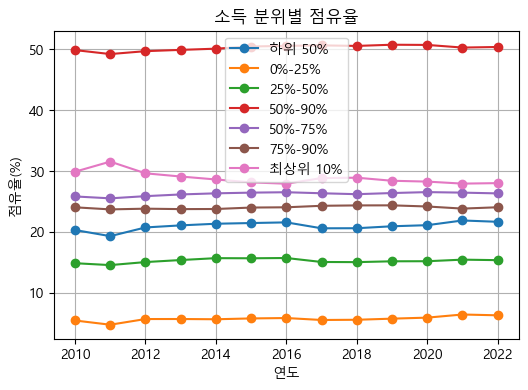

In [68]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = share_table['연도']
share_0_50 = share_table['하위 50%']
share_0_25 = share_table['0%-25%']
share_25_50 = share_table['25%-50%']
share_50_90 = share_table['50%-90%']
share_50_75 = share_table['50%-75%']
share_75_90 = share_table['75%-90%']
share_90_100 = share_table['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, share_0_50, marker='o', linestyle='-', label='하위 50%')
plt.plot(years, share_0_25, marker='o', linestyle='-', label='0%-25%')
plt.plot(years, share_25_50, marker='o', linestyle='-', label='25%-50%')
plt.plot(years, share_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, share_50_75, marker='o', linestyle='-', label='50%-75%')
plt.plot(years, share_75_90, marker='o', linestyle='-', label='75%-90%')
plt.plot(years, share_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('소득 분위별 점유율')
plt.xlabel('연도')
plt.ylabel('점유율(%)')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

## 5. 백분위수 및 백분위수 배율

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

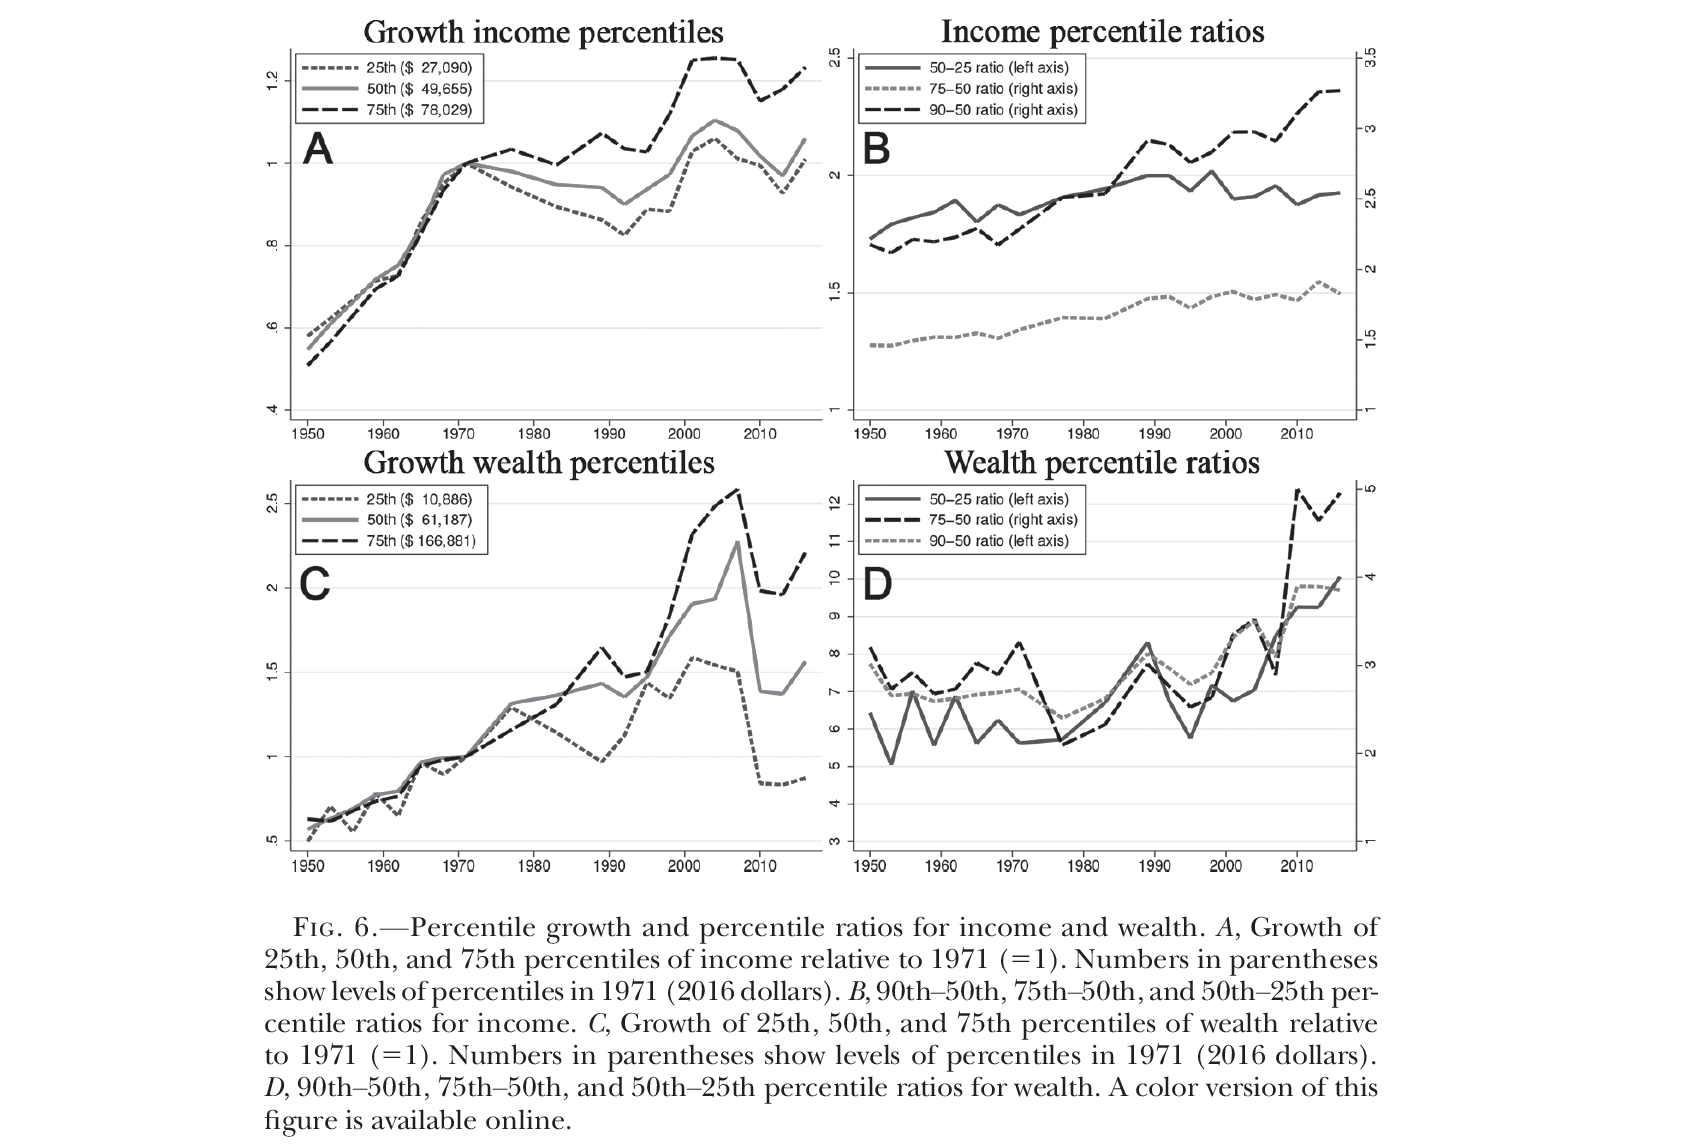

### 백분위 재산

#### A. Without Weights

In [69]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
percentile_table = pd.DataFrame(columns=['연도', '25 백분위수', '50 백분위수', 
                                         '75 백분위수', '90 백분위수'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 백분위수 계산
    percentile_25 = np.percentile(x, 25)
    percentile_50 = np.percentile(x, 50)
    percentile_75 = np.percentile(x, 75)
    percentile_90 = np.percentile(x, 90)

    # 결과를 데이터프레임에 추가
    percentile_table = pd.concat([percentile_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '25 백분위수': [percentile_25], 
                                                '50 백분위수': [percentile_50],
                                                '75 백분위수': [percentile_75], 
                                                '90 백분위수': [percentile_90]})],
                                 ignore_index=True)

# 결과를 출력
percentile_table

연도    25 백분위수     50 백분위수     75 백분위수     90 백분위수
0   2010  45.011172  141.676218  335.738599  692.028759
1   2011  47.857540  151.018364  347.445743  678.286032
2   2012  48.249197  147.465011  337.425802  683.119316
3   2013  51.069777  152.677131  343.151274  659.782819
4   2014  53.951336  159.391057  350.322731  656.892012
5   2015  53.762874  164.883356  356.374063  662.021273
6   2016  54.811397  173.308416  378.397002  700.184793
7   2017  55.609606  178.063393  385.631625  715.596293
8   2018  58.903377  184.132975  408.821630  775.765497
9   2019  58.321436  182.172803  405.452617  779.150665
10  2020  56.967500  183.000000  408.475000  784.870000
11  2021  59.512195  194.331707  454.780488  884.924878
12  2022  58.490391  201.095534  485.006035  953.423080

In [70]:
# 금액을 2010년 대비 배수로 만들기
percentile_table_10 = percentile_table.copy()
for column in percentile_table_10.columns[1:]:
    percentile_table_10[column] = percentile_table_10[column] /\
    percentile_table_10.iloc[0][column]

# 결과를 출력
percentile_table_10

연도   25 백분위수   50 백분위수   75 백분위수   90 백분위수
0   2010  1.000000  1.000000  1.000000  1.000000
1   2011  1.063237  1.065940  1.034870  0.980141
2   2012  1.071938  1.040859  1.005025  0.987126
3   2013  1.134602  1.077648  1.022079  0.953404
4   2014  1.198621  1.125037  1.043439  0.949226
5   2015  1.194434  1.163804  1.061463  0.956638
6   2016  1.217729  1.223271  1.127058  1.011786
7   2017  1.235462  1.256833  1.148607  1.034056
8   2018  1.308639  1.299675  1.217678  1.121002
9   2019  1.295710  1.285839  1.207644  1.125893
10  2020  1.265630  1.291678  1.216646  1.134158
11  2021  1.322165  1.371661  1.354567  1.278740
12  2022  1.299464  1.419402  1.444594  1.377722

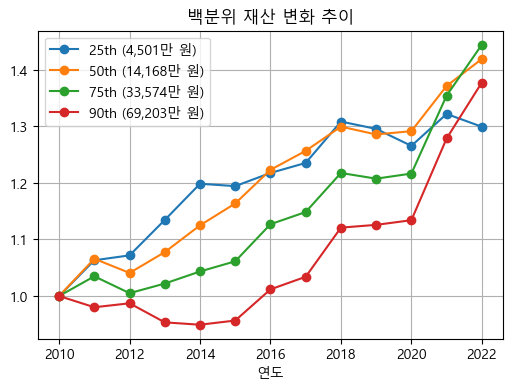

In [71]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = percentile_table_10['연도']
percentile_25 = percentile_table_10['25 백분위수']
percentile_50 = percentile_table_10['50 백분위수']
percentile_75 = percentile_table_10['75 백분위수']
percentile_90 = percentile_table_10['90 백분위수']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, percentile_25, marker='o', linestyle='-', label='25th (4,501만 원)')
plt.plot(years, percentile_50, marker='o', linestyle='-', label='50th (14,168만 원)')
plt.plot(years, percentile_75, marker='o', linestyle='-', label='75th (33,574만 원)')
plt.plot(years, percentile_90, marker='o', linestyle='-', label='90th (69,203만 원)')
plt.title('백분위 재산 변화 추이')
plt.xlabel('연도')

plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### B. With Weights

- `weighted_percentile(x, w, percentile)` 함수 사용

In [72]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
percentile_table = pd.DataFrame(columns=['연도', '25 백분위수', '50 백분위수', 
                                         '75 백분위수', '90 백분위수'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 가중치 지정
    weight = df_year['가중값']

    # 백분위수 계산
    percentile_25 = weighted_percentile(x, weight, 25)
    percentile_50 = weighted_percentile(x, weight, 50)
    percentile_75 = weighted_percentile(x, weight, 75)
    percentile_90 = weighted_percentile(x, weight, 90)
    
    # 결과를 데이터프레임에 추가
    percentile_table = pd.concat([percentile_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '25 백분위수': [percentile_25], 
                                                '50 백분위수': [percentile_50],
                                                '75 백분위수': [percentile_75], 
                                                '90 백분위수': [percentile_90]})],
                                 ignore_index=True)

# 결과를 출력
round(percentile_table, 2)

연도  25 백분위수  50 백분위수  75 백분위수  90 백분위수
0   2010    42.86   135.74   310.86   619.17
1   2011    45.63   144.97   329.28   623.43
2   2012    51.26   153.47   341.82   672.79
3   2013    54.30   158.00   348.32   650.67
4   2014    57.78   165.31   356.58   654.11
5   2015    59.03   173.77   371.12   664.50
6   2016    60.77   185.21   391.41   701.23
7   2017    63.19   191.92   408.62   725.08
8   2018    66.61   202.30   434.39   792.86
9   2019    64.92   201.58   435.12   814.95
10  2020    64.80   202.18   445.06   835.10
11  2021    69.91   220.49   508.92   944.64
12  2022    69.63   228.97   541.08  1003.62

In [73]:
# 금액을 첫 해 대비 배수로 만들기
percentile_table_10 = percentile_table.copy()
for column in percentile_table_10.columns[1:]:
    percentile_table_10[column] = percentile_table_10[column] /\
    percentile_table_10.iloc[0][column]

# 결과를 출력
round(percentile_table_10, 4)

연도  25 백분위수  50 백분위수  75 백분위수  90 백분위수
0   2010   1.0000   1.0000   1.0000   1.0000
1   2011   1.0647   1.0681   1.0593   1.0069
2   2012   1.1959   1.1307   1.0996   1.0866
3   2013   1.2668   1.1641   1.1205   1.0509
4   2014   1.3482   1.2179   1.1471   1.0564
5   2015   1.3773   1.2802   1.1939   1.0732
6   2016   1.4179   1.3645   1.2591   1.1325
7   2017   1.4743   1.4139   1.3145   1.1710
8   2018   1.5541   1.4904   1.3974   1.2805
9   2019   1.5146   1.4851   1.3997   1.3162
10  2020   1.5119   1.4895   1.4317   1.3487
11  2021   1.6312   1.6244   1.6371   1.5256
12  2022   1.6246   1.6868   1.7406   1.6209

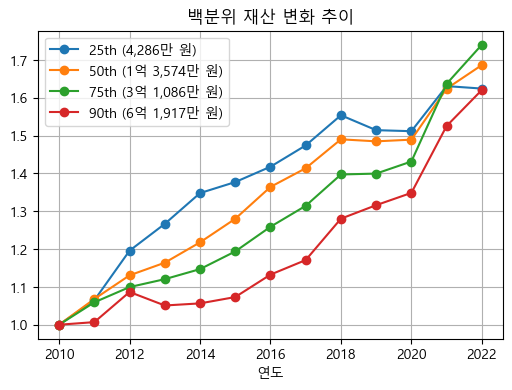

In [74]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = percentile_table_10['연도']
percentile_25 = percentile_table_10['25 백분위수']
percentile_50 = percentile_table_10['50 백분위수']
percentile_75 = percentile_table_10['75 백분위수']
percentile_90 = percentile_table_10['90 백분위수']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, percentile_25, marker='o', linestyle='-', label='25th (4,286만 원)')
plt.plot(years, percentile_50, marker='o', linestyle='-', label='50th (1억 3,574만 원)')
plt.plot(years, percentile_75, marker='o', linestyle='-', label='75th (3억 1,086만 원)')
plt.plot(years, percentile_90, marker='o', linestyle='-', label='90th (6억 1,917만 원)')
plt.title('백분위 재산 변화 추이')
plt.xlabel('연도')

plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

### 백분위 소득

#### A. Without Weights

In [75]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
percentile_table = pd.DataFrame(columns=['연도', '25 백분위수', '50 백분위수', 
                                         '75 백분위수', '90 백분위수'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 백분위수 계산
    percentile_25 = np.percentile(x, 25)
    percentile_50 = np.percentile(x, 50)
    percentile_75 = np.percentile(x, 75)
    percentile_90 = np.percentile(x, 90)

    # 결과를 데이터프레임에 추가
    percentile_table = pd.concat([percentile_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '25 백분위수': [percentile_25], 
                                                '50 백분위수': [percentile_50],
                                                '75 백분위수': [percentile_75], 
                                                '90 백분위수': [percentile_90]})],
                                 ignore_index=True)

# 결과를 출력
round(percentile_table, 2)

연도  25 백분위수  50 백분위수  75 백분위수  90 백분위수
0   2010    15.31    30.30    51.16    77.80
1   2011    15.13    30.70    51.86    77.81
2   2012    15.92    31.60    52.45    78.96
3   2013    15.99    32.31    54.04    81.03
4   2014    16.26    33.76    55.69    82.67
5   2015    16.66    33.90    56.35    83.69
6   2016    16.59    34.02    56.85    84.42
7   2017    16.96    35.64    61.41    92.80
8   2018    17.16    35.59    61.42    93.05
9   2019    17.43    36.32    62.28    93.56
10  2020    18.10    36.84    63.22    93.79
11  2021    18.46    36.00    61.80    91.69
12  2022    18.09    35.35    61.47    92.59

In [76]:
# 금액을 2010년 대비 배수로 만들기
percentile_table_10 = percentile_table.copy()
for column in percentile_table_10.columns[1:]:
    percentile_table_10[column] = percentile_table_10[column] /\
    percentile_table_10.iloc[0][column]

# 결과를 출력
percentile_table_10

연도   25 백분위수   50 백분위수   75 백분위수   90 백분위수
0   2010  1.000000  1.000000  1.000000  1.000000
1   2011  0.987647  1.012902  1.013672  1.000244
2   2012  1.039762  1.042618  1.025025  1.014972
3   2013  1.043954  1.066120  1.056142  1.041595
4   2014  1.061658  1.114002  1.088492  1.062610
5   2015  1.087601  1.118716  1.101259  1.075785
6   2016  1.083267  1.122761  1.111064  1.085158
7   2017  1.107415  1.176036  1.200165  1.192843
8   2018  1.120801  1.174252  1.200513  1.196096
9   2019  1.138347  1.198629  1.217247  1.202705
10  2020  1.181895  1.215492  1.235617  1.205564
11  2021  1.205307  1.187938  1.207768  1.178630
12  2022  1.180954  1.166628  1.201426  1.190133

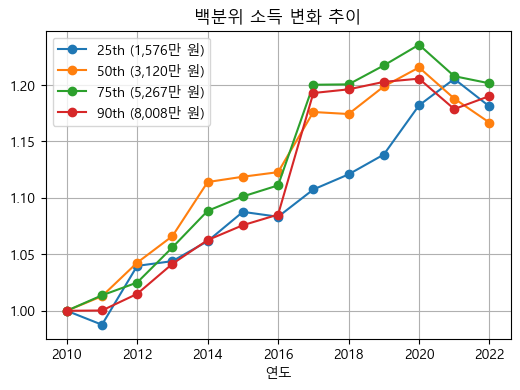

In [77]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = percentile_table_10['연도']
percentile_25 = percentile_table_10['25 백분위수']
percentile_50 = percentile_table_10['50 백분위수']
percentile_75 = percentile_table_10['75 백분위수']
percentile_90 = percentile_table_10['90 백분위수']   
  
# 그래프 생성
plt.figure(figsize=(6, 4))    
plt.plot(years, percentile_25, marker='o', linestyle='-', label='25th (1,576만 원)')
plt.plot(years, percentile_50, marker='o', linestyle='-', label='50th (3,120만 원)')
plt.plot(years, percentile_75, marker='o', linestyle='-', label='75th (5,267만 원)')
plt.plot(years, percentile_90, marker='o', linestyle='-', label='90th (8,008만 원)')
plt.title('백분위 소득 변화 추이')
plt.xlabel('연도')

plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### B. With Weights

In [78]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
percentile_table = pd.DataFrame(columns=['연도', '25 백분위수', '50 백분위수', 
                                         '75 백분위수', '90 백분위수'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 가중치 지정
    weight = df_year['가중값']

    # 백분위수 계산
    percentile_25 = weighted_percentile(x, weight, 25)
    percentile_50 = weighted_percentile(x, weight, 50)
    percentile_75 = weighted_percentile(x, weight, 75)
    percentile_90 = weighted_percentile(x, weight, 90)

    # 결과를 데이터프레임에 추가
    percentile_table = pd.concat([percentile_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '25 백분위수': [percentile_25], 
                                                '50 백분위수': [percentile_50],
                                                '75 백분위수': [percentile_75], 
                                                '90 백분위수': [percentile_90]})],
                                 ignore_index=True)

# 결과를 출력
round(percentile_table, 2)

연도  25 백분위수  50 백분위수  75 백분위수  90 백분위수
0   2010    14.95    29.59    49.78    74.10
1   2011    14.86    30.24    50.96    75.88
2   2012    16.34    31.88    52.08    77.68
3   2013    17.51    33.62    54.49    79.78
4   2014    18.15    35.15    56.39    82.46
5   2015    18.62    35.82    57.77    84.29
6   2016    18.98    36.33    58.67    84.99
7   2017    19.39    38.84    64.82    95.38
8   2018    19.87    39.24    65.83    97.63
9   2019    20.28    40.13    66.77    98.69
10  2020    20.64    40.81    67.65    98.97
11  2021    21.86    41.42    67.41    97.85
12  2022    21.73    40.84    67.51    99.77

In [79]:
# 금액을 첫 해 대비 배수로 만들기
percentile_table_10 = percentile_table.copy()
for column in percentile_table_10.columns[1:]:
    percentile_table_10[column] = percentile_table_10[column] /\
    percentile_table_10.iloc[0][column]

# 결과를 출력
round(percentile_table_10, 4)

연도  25 백분위수  50 백분위수  75 백분위수  90 백분위수
0   2010   1.0000   1.0000   1.0000   1.0000
1   2011   0.9941   1.0219   1.0237   1.0241
2   2012   1.0930   1.0773   1.0462   1.0483
3   2013   1.1718   1.1361   1.0945   1.0766
4   2014   1.2146   1.1878   1.1328   1.1128
5   2015   1.2455   1.2105   1.1604   1.1376
6   2016   1.2699   1.2277   1.1786   1.1471
7   2017   1.2970   1.3127   1.3020   1.2872
8   2018   1.3295   1.3260   1.3223   1.3176
9   2019   1.3567   1.3562   1.3411   1.3319
10  2020   1.3809   1.3791   1.3589   1.3357
11  2021   1.4627   1.3998   1.3541   1.3206
12  2022   1.4541   1.3801   1.3560   1.3464

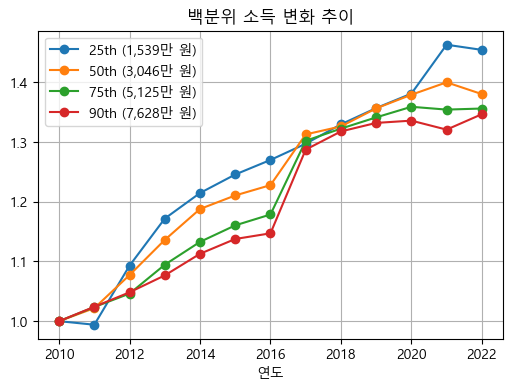

In [80]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = percentile_table_10['연도']
percentile_25 = percentile_table_10['25 백분위수']
percentile_50 = percentile_table_10['50 백분위수']
percentile_75 = percentile_table_10['75 백분위수']
percentile_90 = percentile_table_10['90 백분위수']   
  
# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, percentile_25, marker='o', linestyle='-', label='25th (1,539만 원)')
plt.plot(years, percentile_50, marker='o', linestyle='-', label='50th (3,046만 원)')
plt.plot(years, percentile_75, marker='o', linestyle='-', label='75th (5,125만 원)')
plt.plot(years, percentile_90, marker='o', linestyle='-', label='90th (7,628만 원)')
plt.title('백분위 소득 변화 추이')
plt.xlabel('연도')

plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

## 6. 마이너스 재산 가구 중 주택보유 비율

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

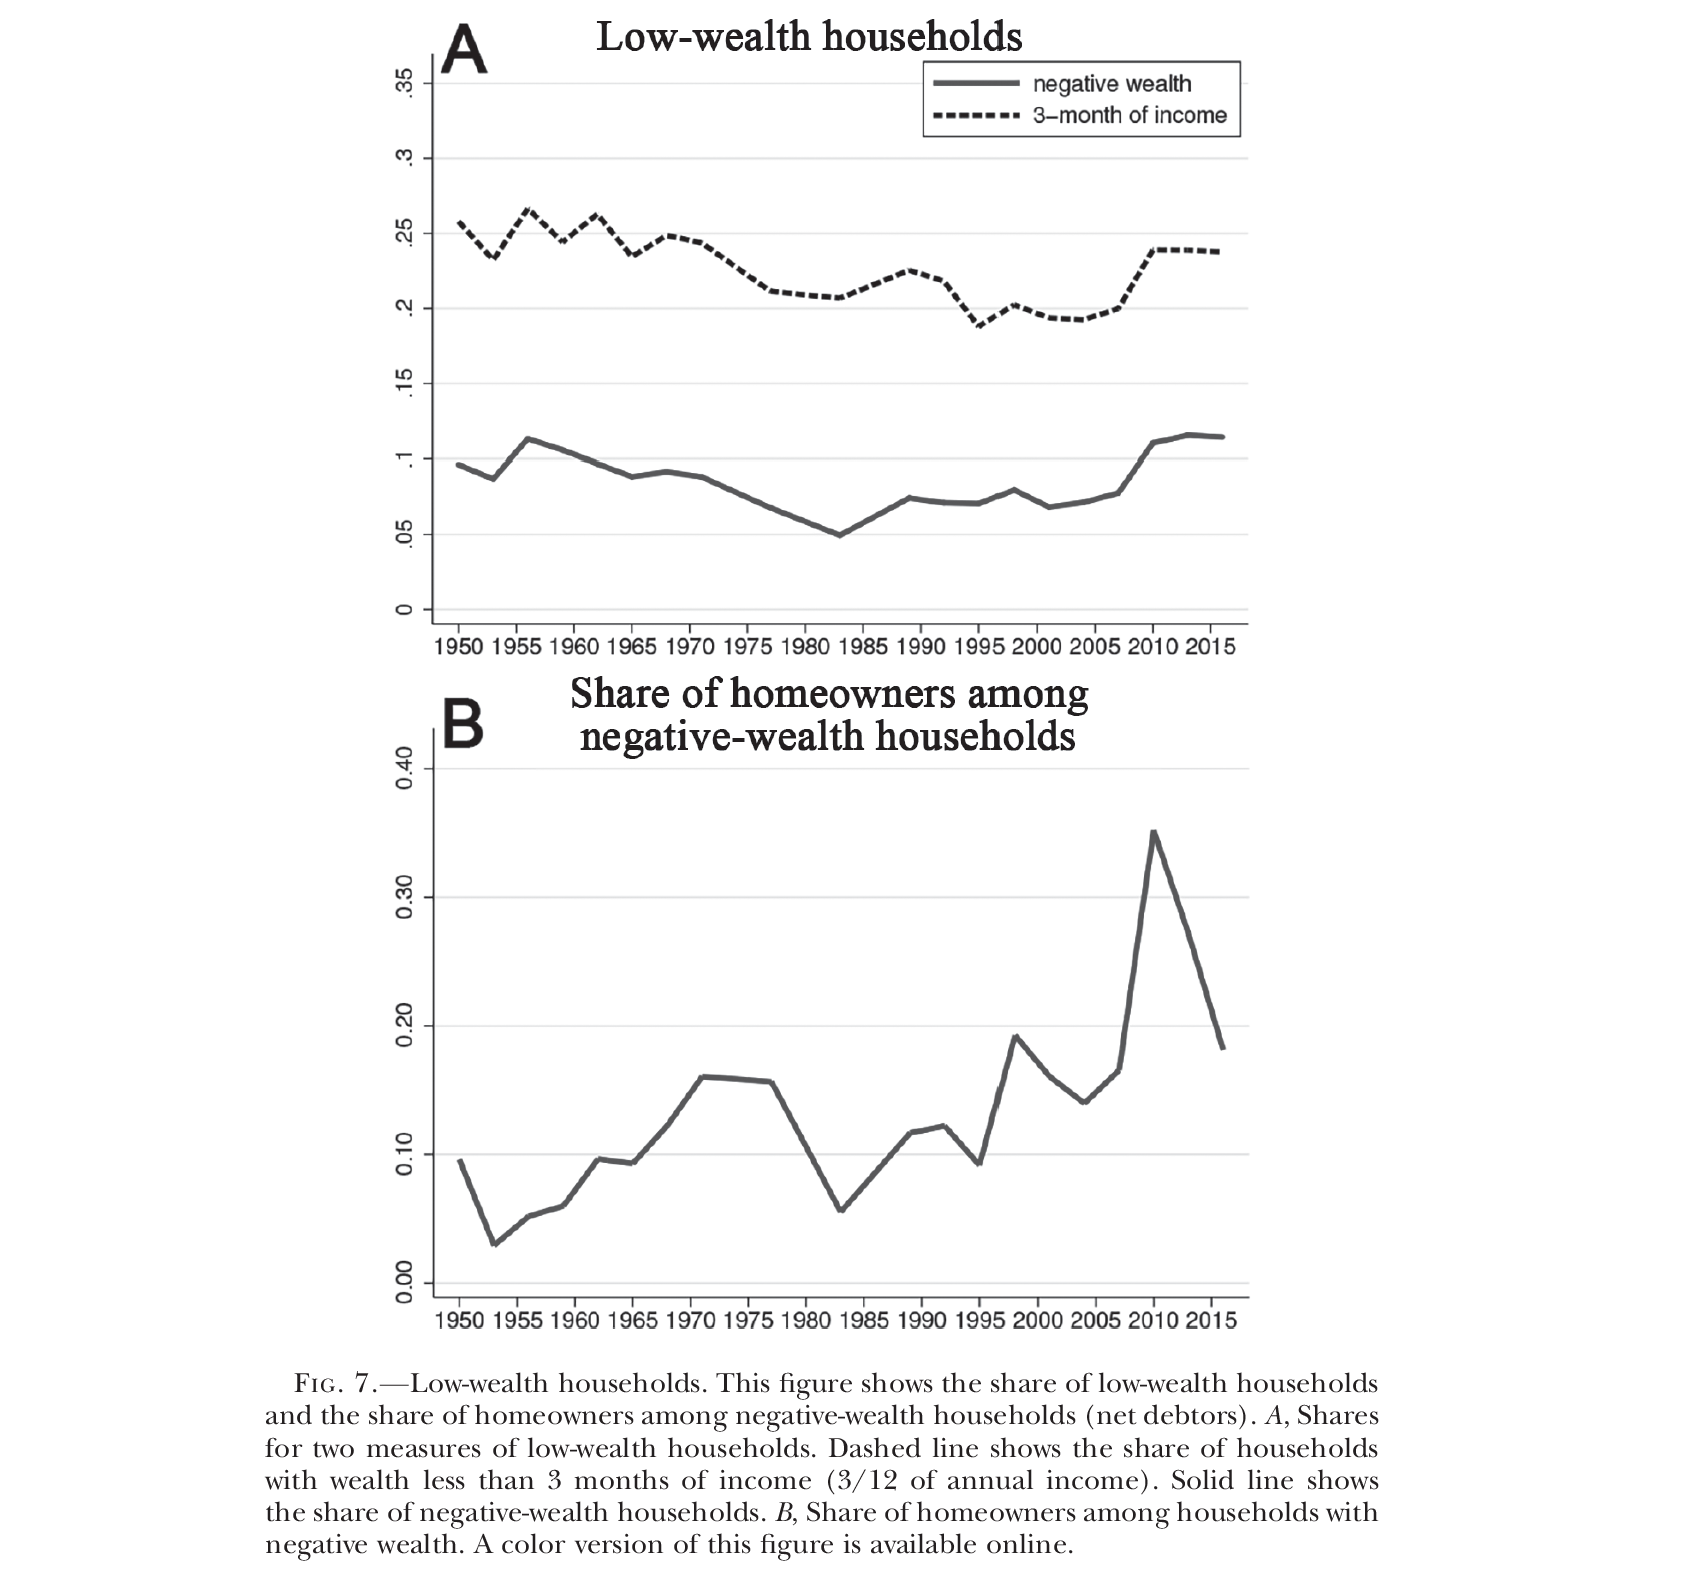

### 마이너스 재산 가구 비율

### (1) 2022년 데이터

**<span style="font-size: 1.7em; ">Q</span>** &nbsp;&nbsp;

>**x 값이 마이너스인 그룹의 비율을 구하라.**

**<span style="font-size: 1.7em; color: mediumseagreen;">A</span>** &nbsp;&nbsp; 

> 변수 `x`에서 값이 마이너스인 그룹의 비율을 구하기 위해, 다음과 같은 코드를 사용할 수 있습니다:
>
>```python
import numpy as np
>
># 데이터프레임에서 x 열의 값이 마이너스인 그룹 비율 계산
negative_ratio = (x < 0).mean()
>
># 결과 출력
print(f"Ratio of negative values in x: {negative_ratio}")
>```
>
>위 코드에서 `x` 열에서 값이 0보다 작은 (즉, 마이너스인) 경우를 검사하고, `mean()` 함수를 사용하여 이러한 값들의 비율을 계산합니다. 계산된 비율은 `negative_ratio` 변수에 저장되며 출력됩니다.

In [81]:
# 2022년 순자산 및 가중치
x = df_2022['순자산']
weight = df_2022['가중값']

#### 단순 비율

In [82]:
# 데이터프레임에서 x 열의 값이 마이너스인 그룹 비율(단순) 계산
negative_ratio = (x < 0).mean()

# 결과 출력
print(f"x<0의 비율(단순): {negative_ratio}")

x<0의 비율(단순): 0.028740113623705023


#### 가중 비율
- 앞에서 만들어놓은 `weighted_cum_prob()` 함수 이용

In [83]:
# 데이터프레임에서 x 열의 값이 마이너스인 그룹 비율(가중) 계산
negative_ratio = weighted_cum_prob(x, weight, 0)

# 결과 출력
print(f"x<0의 비율(가중): {negative_ratio}")

x<0의 비율(가중): 0.031699164230169045


### (2) 전체 연도

#### A. Without Weights

In [84]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
neg_wealth_table = pd.DataFrame(columns=['연도', '재산<0 비율'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 마이너스인 그룹 비율 계산
    negative_ratio = (x < 0).mean()

    # 결과를 데이터프레임에 추가
    neg_wealth_table = pd.concat([neg_wealth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '재산<0 비율': [negative_ratio]})],
                                 ignore_index=True)

# 결과를 출력
neg_wealth_table

연도   재산<0 비율
0   2010  0.033400
1   2011  0.033660
2   2012  0.032516
3   2013  0.030763
4   2014  0.028607
5   2015  0.027009
6   2016  0.027472
7   2017  0.026761
8   2018  0.028112
9   2019  0.029501
10  2020  0.032883
11  2021  0.029747
12  2022  0.028740

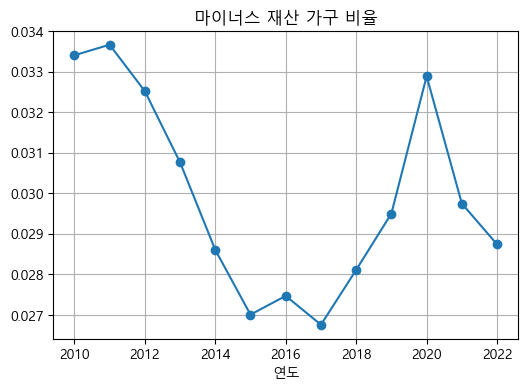

In [85]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = neg_wealth_table['연도']
negative_ratio = neg_wealth_table['재산<0 비율']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, negative_ratio, marker='o', linestyle='-', label='재산<0 비율')
plt.title('마이너스 재산 가구 비율')
plt.xlabel('연도')
plt.grid(True)

# 그래프 표시
plt.show()

#### B. With Weights

In [86]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
neg_wealth_table = pd.DataFrame(columns=['연도', '재산<0 비율'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 가중치 지정
    weight = df_year['가중값']

    # 마이너스인 그룹 비율 계산
    negative_ratio = weighted_cum_prob(x, weight, 0)

    # 결과를 데이터프레임에 추가
    neg_wealth_table = pd.concat([neg_wealth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '재산<0 비율': [negative_ratio]})],
                                 ignore_index=True)

# 결과를 출력
neg_wealth_table

연도   재산<0 비율
0   2010  0.033949
1   2011  0.033622
2   2012  0.031120
3   2013  0.029906
4   2014  0.028292
5   2015  0.026468
6   2016  0.027115
7   2017  0.028053
8   2018  0.028930
9   2019  0.030242
10  2020  0.034258
11  2021  0.030157
12  2022  0.031699

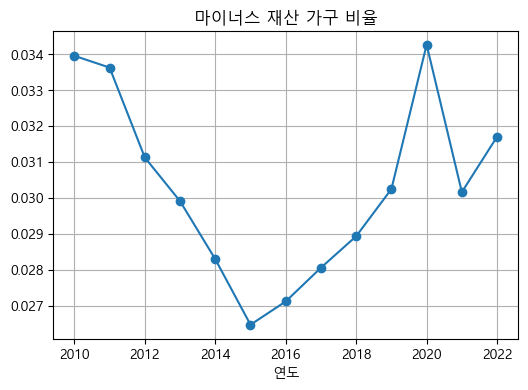

In [87]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = neg_wealth_table['연도']
negative_ratio = neg_wealth_table['재산<0 비율']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, negative_ratio, marker='o', linestyle='-', label='재산<0 비율')
plt.title('마이너스 재산 가구 비율')
plt.xlabel('연도')
plt.grid(True)

# 그래프 표시
plt.show()

### 저재산 가구 비율
- 재산이 3개월 소득보다 적은 가구 비율

### (1) 2022년 데이터

In [88]:
# 2022년 순자산 및 처분가능소득
x1 = df_2022['순자산']
x2 = df_2022['처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]']
weight = df_2022['가중값']

**<span style="font-size: 1.7em; ">Q</span>** &nbsp;&nbsp;

>**두 개의 배열 x1과 x2를 하나의 데이터프레임으로 묶는다. 그런 다음, x1의 값이 x2의 1/4보다 작은 관측의 비율을 구하라.**

**<span style="font-size: 1.7em; color: mediumseagreen;">A</span>** &nbsp;&nbsp; 

> 두 개의 배열 `x1`과 `x2`를 하나의 데이터프레임으로 묶어서, 그 중에서 `x1`의 값이 `x2`의 1/4보다 작은 관측의 비율을 구하는 방법은 다음과 같습니다. 이 예제에서는 NumPy와 Pandas 라이브러리를 사용합니다:
>
>```python
import pandas as pd
import numpy as np
>
># 두 배열 생성
data = {'x1': x1, 'x2': x2}
df = pd.DataFrame(data)
>
># x1의 값이 x2의 1/4보다 작은 관측의 비율 계산
subset_df = df[df['x1'] < (0.25 * df['x2'])]
ratio = len(subset_df) / len(df)
>
># 결과 출력
print(f"Ratio of x1 < 1/4 * x2: {ratio}")
>```
>
>위 코드에서, 두 배열 `x1`과 `x2`를 데이터프레임 `df`에 묶은 다음, `df['x1'] < (0.25 * df['x2'])` 조건으로 `x1`의 값이 `x2`의 1/4보다 작은 관측만 선택합니다. 선택된 관측의 수를 전체 관측 수로 나누어 비율을 계산하고 출력합니다.

<span style="font-weight: bold; color: blue">
    코드 실행 결과:
</span>

#### A .단순 비율

In [89]:
# 두 배열 생성
data = {'x1': x1, 'x2': x2}
df = pd.DataFrame(data)

# x1의 값이 x2의 1/4보다 작은 관측의 비율 계산
subset_df = df[df['x1'] < (0.25 * df['x2'])]
ratio = len(subset_df) / len(df)

# 결과 출력
print(f"비율(단순): {ratio}")

비율(단순): 0.07185028405926255


#### B. 가중 비율

In [90]:
# 세 배열 생성
data = {'x1': x1, 'x2': x2, 'w': weight}
df = pd.DataFrame(data)

# x1의 값이 x2의 1/4보다 작은 관측의 가중 비율 계산
subset_df = df[df['x1'] < (0.25 * df['x2'])]
ratio = subset_df['w'].sum() / df['w'].sum()

# 결과 출력
print(f"비율(가중): {ratio}")

비율(가중): 0.06843462338928007


### (2) 전체 연도

#### A. Without Weights

In [91]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
low_wealth_table = pd.DataFrame(columns=['연도', '재산<0 비율', '3개월 소득 미달'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # x1 값을 계산
    x1 = df_year['순자산'] / 100
    x1 = x1 / (cpi_year / 100)
    
    # x2 값을 계산(통계당국 처분가능소득 계산)
    x2 = df_year[income_column] + df_year[interest_payment]
    x2 = x2 / 100
    x2 = x2 / (cpi_year / 100)    

    # 마이너스인 그룹 비율 계산
    negative_ratio = (x1 < 0).mean()
    
    # 두 배열 생성
    data = {'x1': x1, 'x2': x2}
    df = pd.DataFrame(data)
    
    # x1의 값이 x2의 1/4보다 작은 관측의 비율 계산
    subset_df = df[df['x1'] < (0.25 * df['x2'])]
    ratio = len(subset_df) / len(df)

    # 결과를 데이터프레임에 추가
    low_wealth_table = pd.concat([low_wealth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '재산<0 비율': [negative_ratio], 
                                                '3개월 소득 미달': [ratio]})],
                                 ignore_index=True)

# 결과를 출력
low_wealth_table

연도   재산<0 비율  3개월 소득 미달
0   2010  0.033400   0.072500
1   2011  0.033660   0.069316
2   2012  0.032516   0.070756
3   2013  0.030763   0.068355
4   2014  0.028607   0.064379
5   2015  0.027009   0.065887
6   2016  0.027472   0.068188
7   2017  0.026761   0.069633
8   2018  0.028112   0.069689
9   2019  0.029501   0.072150
10  2020  0.032883   0.073682
11  2021  0.029747   0.072249
12  2022  0.028740   0.072407

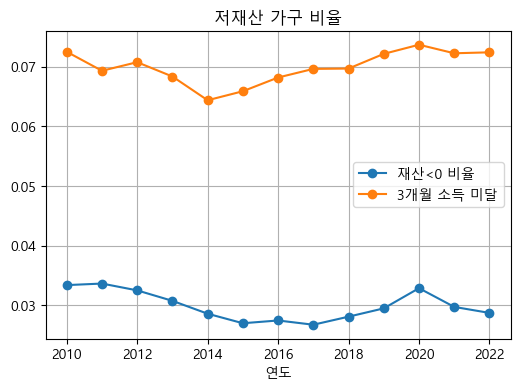

In [92]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = low_wealth_table['연도']
negative_ratio = low_wealth_table['재산<0 비율']
ratio = low_wealth_table['3개월 소득 미달']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, negative_ratio, marker='o', linestyle='-', label='재산<0 비율')
plt.plot(years, ratio, marker='o', linestyle='-', label='3개월 소득 미달')
plt.title('저재산 가구 비율')
plt.xlabel('연도')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### B. With Weights

In [93]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
low_wealth_table = pd.DataFrame(columns=['연도', '재산<0 비율', '3개월 소득 미달'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # x1 값을 계산
    x1 = df_year['순자산'] / 100
    x1 = x1 / (cpi_year / 100)
    
    # x2 값을 계산(통계당국 처분가능소득 계산)
    x2 = df_year[income_column] + df_year[interest_payment]
    x2 = x2 / 100
    x2 = x2 / (cpi_year / 100)    

    # 가중치 지정
    weight = df_year['가중값']
    
    # x1 마이너스인 그룹 비율 계산
    negative_ratio = weighted_cum_prob(x1, weight, 0)
    
    # 세 배열 생성
    data = {'x1': x1, 'x2': x2, 'w': weight}
    df = pd.DataFrame(data)
    
    # x1의 값이 x2의 1/4보다 작은 관측의 가중 비율 계산
    subset_df = df[df['x1'] < (0.25 * df['x2'])]
    ratio = subset_df['w'].sum() / df['w'].sum()

    # 결과를 데이터프레임에 추가
    low_wealth_table = pd.concat([low_wealth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '재산<0 비율': [negative_ratio], 
                                                '3개월 소득 미달': [ratio]})],
                                 ignore_index=True)

# 결과를 출력
low_wealth_table

연도   재산<0 비율  3개월 소득 미달
0   2010  0.033949   0.074068
1   2011  0.033622   0.070234
2   2012  0.031120   0.066699
3   2013  0.029906   0.064815
4   2014  0.028292   0.061023
5   2015  0.026468   0.061321
6   2016  0.027115   0.063387
7   2017  0.028053   0.065230
8   2018  0.028930   0.066176
9   2019  0.030242   0.069073
10  2020  0.034258   0.070551
11  2021  0.030157   0.066122
12  2022  0.031699   0.068956

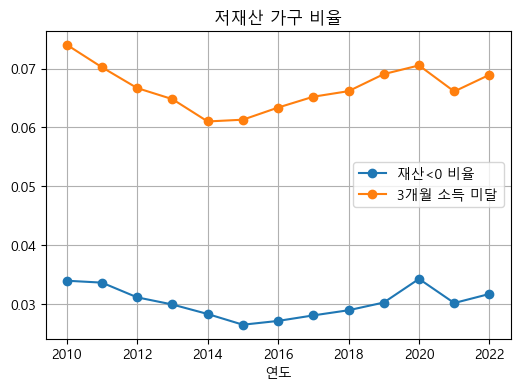

In [94]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = low_wealth_table['연도']
negative_ratio = low_wealth_table['재산<0 비율']
ratio = low_wealth_table['3개월 소득 미달']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, negative_ratio, marker='o', linestyle='-', label='재산<0 비율')
plt.plot(years, ratio, marker='o', linestyle='-', label='3개월 소득 미달')
plt.title('저재산 가구 비율')
plt.xlabel('연도')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

### 마이너스 재산 가구 중 주택보유 비율

### (1) 2022년

In [95]:
# 2022년 순자산
x = df_2022['순자산']
weight = df_2022['가중값']

#### 입주형태 변수

- 현재 살고 있는 주택의 입주 형태는 무엇입니까?
>1	자기집,
>2	전세,
>3	보증금 있는 월세,
>4	보증금 없는 월세,
>5	기타

In [96]:
homeowner = df_2022["입주형태코드"]
homeowner.describe()

count    17954.000000
mean         1.793973
std          1.187180
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max          5.000000
Name: 입주형태코드, dtype: float64

**<span style="font-size: 1.7em; ">Q</span>** &nbsp;&nbsp;

>**homeowner 변수의 데이터 타입을 숫자형이 아니라 범주형으로 바꾼다.**

**<span style="font-size: 1.7em; color: mediumseagreen;">A</span>** &nbsp;&nbsp; 

> `homeowner` 변수를 숫자형에서 범주형으로 바꾸기 위해, Pandas를 사용하여 데이터프레임의 열 데이터를 범주형(Categorical)으로 변환할 수 있습니다. 아래는 어떻게 할 수 있는지 보여주는 예제 코드입니다:
>
>```python
import pandas as pd
>
># 데이터프레임 생성 (예시)
data = pd.DataFrame({'homeowner': [0, 1, 0, 1, 1, 0]})
>
># 숫자형 변수를 범주형으로 변환
data['homeowner'] = data['homeowner'].astype('category')
>
># 데이터 타입 확인
print(data.dtypes)
>```
>
>위 코드에서는 `astype('category')`를 사용하여 `homeowner` 열을 범주형으로 변환했습니다. 이제 해당 열의 데이터는 범주형 타입으로 저장될 것이며, 데이터프레임의 `dtypes` 속성을 통해 데이터 타입을 확인할 수 있습니다.

<span style="font-weight: bold; color: blue">
    코드 실행 결과:
</span>

In [97]:
homeowner = homeowner.astype('category')
homeowner.describe()

count     17954
unique        5
top           1
freq      11069
Name: 입주형태코드, dtype: int64

**<span style="font-size: 1.7em; ">Q</span>** &nbsp;&nbsp;

>**범주형 변수인 homeowner의 각 범주별 비율을 구하라.**

**<span style="font-size: 1.7em; color: mediumseagreen;">A</span>** &nbsp;&nbsp; 

> 범주형 변수인 `homeowner`의 각 범주별 비율을 계산하려면, 각 범주(카테고리)의 개수를 세어 전체 데이터 수에 대한 비율을 계산하면 됩니다. Pandas를 사용하여 이 작업을 수행할 수 있습니다. 아래는 각 범주의 비율을 계산하는 예제 코드입니다:
>
>```python
import pandas as pd
>
># 데이터프레임 생성 (예시)
data = pd.DataFrame({'homeowner': ['Yes', 'No', 'Yes', 'No', 'Yes', 'No']})
>
># 범주별 개수 세기
category_counts = data['homeowner'].value_counts()
>
># 범주별 비율 계산
category_ratios = category_counts / len(data)
>
># 결과 출력
print(category_ratios)
>```
>
>위 코드에서는 `value_counts()` 함수를 사용하여 각 범주(카테고리)의 개수를 계산하고, 전체 데이터 수로 나누어서 범주별 비율을 계산합니다. 이를 통해 `homeowner`의 각 범주별 비율을 얻을 수 있습니다.

<span style="font-weight: bold; color: blue">
    코드 실행 결과:
</span>

In [98]:
# 범주별 개수 세기
category_counts = homeowner.value_counts()

# 범주별 비율 계산
category_ratios = category_counts / len(homeowner)

# 결과 출력
print(category_ratios)

1    0.616520
3    0.184082
2    0.119249
5    0.066113
4    0.014036
Name: 입주형태코드, dtype: float64


- 현재 살고 있는 주택이 자기집인 경우(즉 **자가점유율**)가 58.4%이다. **자가보유율**은 아니지만 이 변수를 사용하기로 한다.

**<span style="font-size: 1.7em; ">Q</span>** &nbsp;&nbsp;

>**두 개의 배열 x와 homeowner를 하나의 데이터프레임으로 묶는다. 그런 다음, x의 값이 마이너스인 관측 중 homeowner가 1인 관측의 비율을 구하라.**

**<span style="font-size: 1.7em; color: mediumseagreen;">A</span>** &nbsp;&nbsp; 

> 두 개의 배열 `x`와 `homeowner`를 하나의 데이터프레임으로 묶어서, 그 중에서 `x`의 값이 마이너스인 관측 중 `homeowner`가 1인 관측의 비율을 구하는 방법은 다음과 같습니다. 이 예제에서는 NumPy와 Pandas 라이브러리를 사용합니다:
>
>```python
import pandas as pd
>
># 두 배열 생성
data = {'x': x, 'homeowner': homeowner}
df = pd.DataFrame(data)
>
># x 값이 마이너스이고 homeowner가 1인 관측의 비율 계산
subset_df = df[(df['x'] < 0) & (df['homeowner'] == 1)]
ratio = len(subset_df) / len(df[df['x'] < 0])
>
># 결과 출력
print(f"Ratio of (x < 0) and (homeowner == 1): {ratio}")
>```
>
>위 코드에서, 두 배열 `x`와 `homeowner`를 데이터프레임 `df`에 묶은 다음, `df['x'] < 0` 및 `df['homeowner'] == 1` 조건으로 `x`의 값이 마이너스이고 `homeowner`가 1인 관측만 선택합니다. 선택된 관측의 수를 `x` 값이 마이너스인 전체 관측 수로 나누어 비율을 계산하고 출력합니다.

<span style="font-weight: bold; color: blue">
    코드 실행 결과:
</span>

#### 단순 비율

In [99]:
# 두 배열 생성
data = {'x': x, 'homeowner': homeowner}
df = pd.DataFrame(data)

# x 값이 마이너스이고 homeowner가 1인 관측의 비율 계산
subset_df = df[(df['x'] < 0) & (df['homeowner'] == 1)]
ratio = len(subset_df) / len(df[df['x'] < 0])

# 결과 출력
print(f"마이너스 재산 가구 중 주택보유 비율(단순): {ratio}")

마이너스 재산 가구 중 주택보유 비율(단순): 0.044573643410852716


#### 가중 비율

In [100]:
# 세 배열 생성
data = {'x': x, 'homeowner': homeowner, 'w': weight}
df = pd.DataFrame(data)

# x 값이 마이너스이고 homeowner가 1인 관측의 비율 계산
subset_df = df[(df['x'] < 0) & (df['homeowner'] == 1)]
ratio = subset_df['w'].sum() / df['w'].sum()

# 결과 출력
print(f"마이너스 재산 가구 중 주택보유 비율(가중): {ratio}")

마이너스 재산 가구 중 주택보유 비율(가중): 0.001363452828595322


### (2) 전체 연도

#### A. Without Weights

In [101]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
homeowner_table = pd.DataFrame(columns=['연도', '주택보유 비율'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)

    # homeowner
    homeowner = df_year['입주형태코드'] 
    
    # 두 배열 생성
    data = {'x': x, 'homeowner': homeowner}
    df = pd.DataFrame(data)

    # x 값이 마이너스이고 homeowner가 1인 관측의 비율 계산
    subset_df = df[(df['x'] < 0) & (df['homeowner'] == 1)]
    ratio = len(subset_df) / len(df[df['x'] < 0])

    # 결과를 데이터프레임에 추가
    homeowner_table = pd.concat([homeowner_table,
                                 pd.DataFrame({'연도': [year],
                                               '주택보유 비율': [ratio]})],
                                ignore_index=True)

# 결과를 출력
homeowner_table

연도   주택보유 비율
0   2010  0.116766
1   2011  0.104520
2   2012  0.082555
3   2013  0.108392
4   2014  0.121331
5   2015  0.088296
6   2016  0.091633
7   2017  0.070707
8   2018  0.066794
9   2019  0.071823
10  2020  0.089226
11  2021  0.081331
12  2022  0.044574

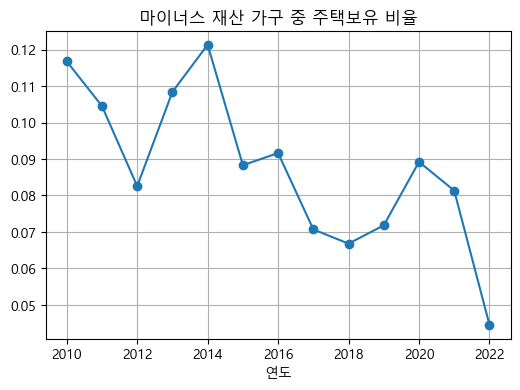

In [102]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = homeowner_table['연도']
homeowner_ratio = homeowner_table['주택보유 비율']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, homeowner_ratio, marker='o', linestyle='-', label='주택보유 비율')
plt.title('마이너스 재산 가구 중 주택보유 비율')
plt.xlabel('연도')
plt.grid(True)

# 그래프 표시
plt.show()

#### (2) With Weights

In [103]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
homeowner_table = pd.DataFrame(columns=['연도', '주택보유 비율'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)

    # homeowner
    homeowner = df_year['입주형태코드'] 
    
    # 세 배열 생성
    data = {'x': x, 'homeowner': homeowner, 'w': weight}
    df = pd.DataFrame(data)

    # x 값이 마이너스이고 homeowner가 1인 관측의 비율 계산
    subset_df = df[(df['x'] < 0) & (df['homeowner'] == 1)]
    ratio = subset_df['w'].sum() / df['w'].sum()

    # 결과를 데이터프레임에 추가
    homeowner_table = pd.concat([homeowner_table,
                                 pd.DataFrame({'연도': [year],
                                               '주택보유 비율': [ratio]})],
                                ignore_index=True)

# 결과를 출력
homeowner_table

연도   주택보유 비율
0   2010  0.002049
1   2011  0.001738
2   2012  0.002550
3   2013  0.002834
4   2014  0.003645
5   2015  0.002203
6   2016  0.002362
7   2017  0.001629
8   2018  0.001990
9   2019  0.002287
10  2020  0.002821
11  2021  0.001942
12  2022  0.001363

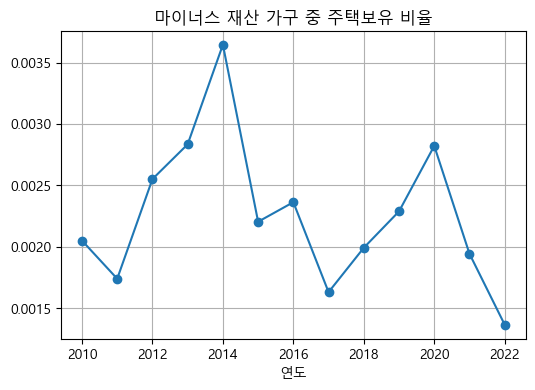

In [104]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = homeowner_table['연도']
homeowner_ratio = homeowner_table['주택보유 비율']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, homeowner_ratio, marker='o', linestyle='-', label='주택보유 비율')
plt.title('마이너스 재산 가구 중 주택보유 비율')
plt.xlabel('연도')
plt.grid(True)

# 그래프 표시
plt.show()

## 7. 균등화 재산 및 소득의 지니 계수

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

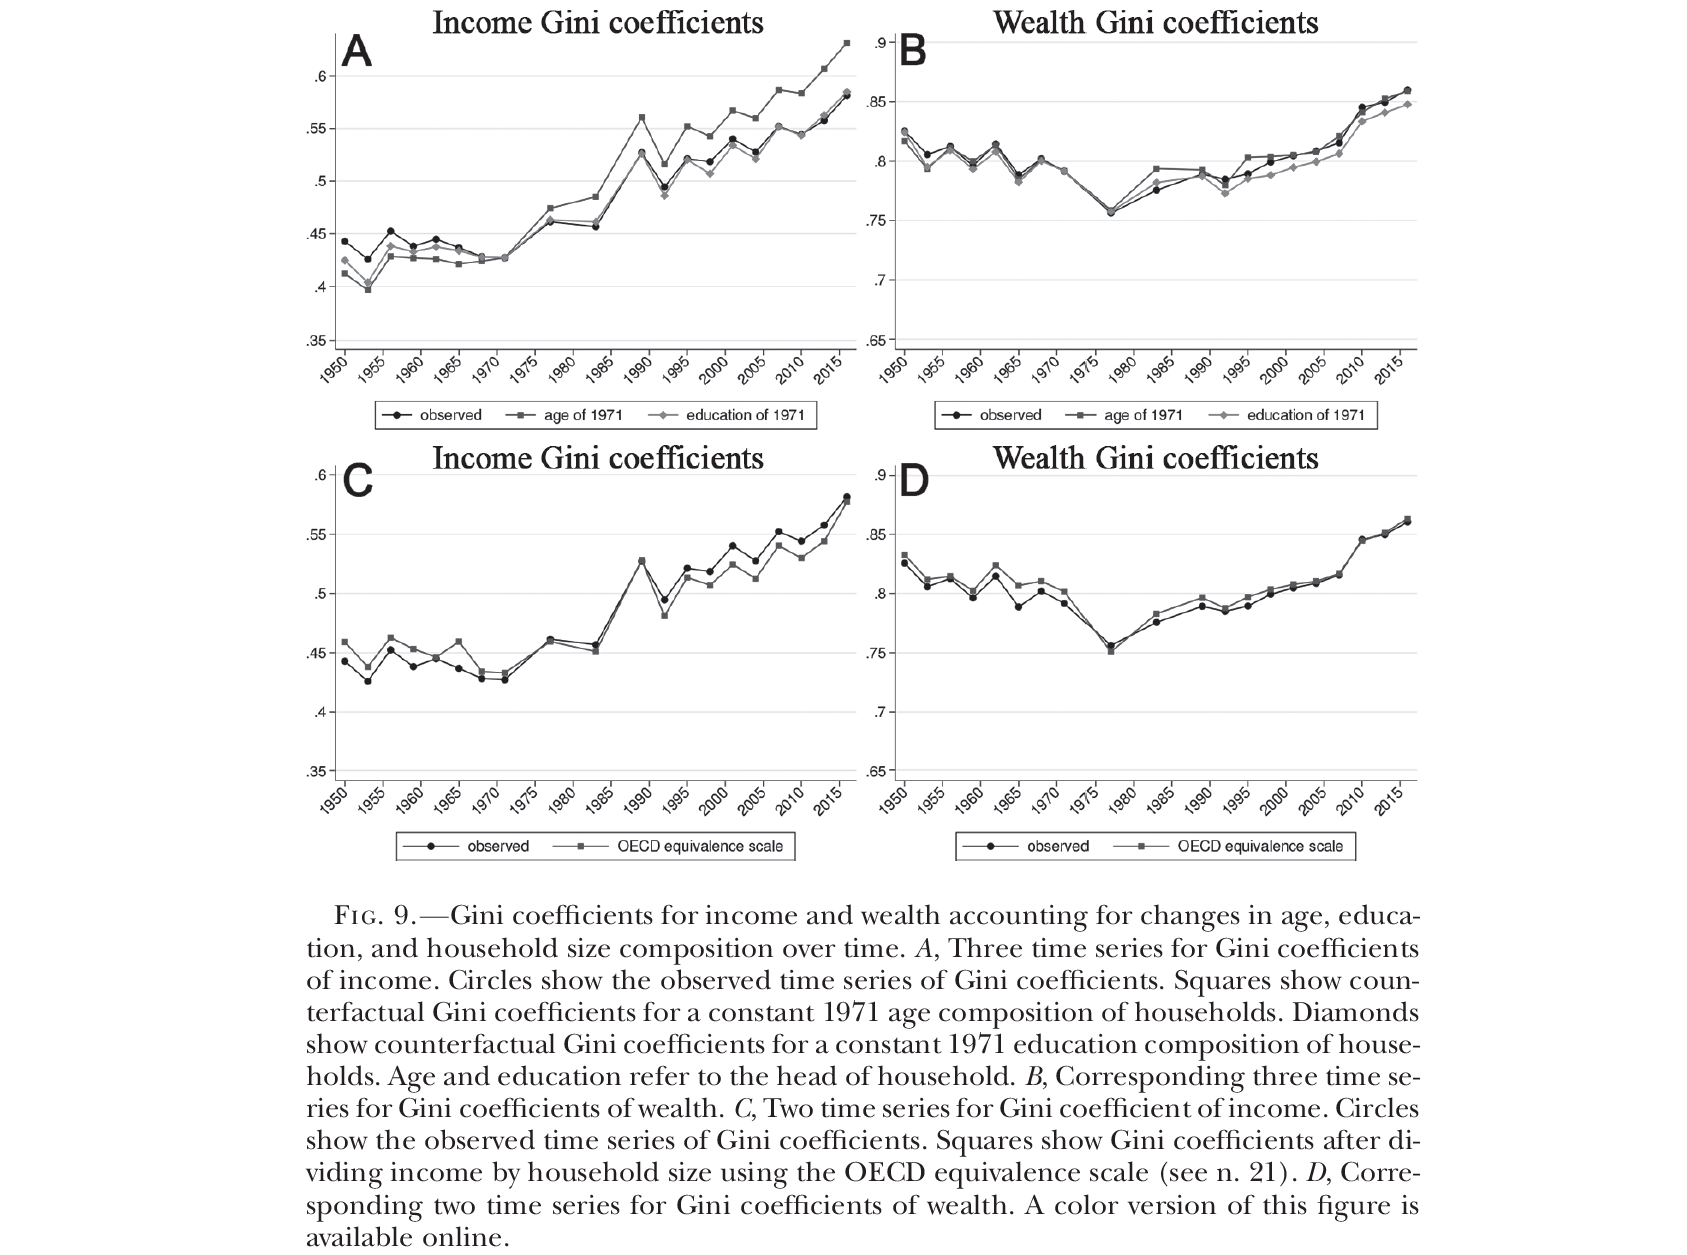

### 균등화?

- 균등화소득은 간단히 말하면 1인당 소득에 해당한다. 그런데 가구 소득을 가구 구성원 숫자로 나누는 경우가 말 그대로 “1인당 소득(per-capita income)”이고, 가령 가구원수에 제곱근 취한 값(OECD의 균등화 척도)으로 나누는 방식을 균등화소득이라고 부른다. 가구원수보다 작은 값으로 나누는 이유는 주택 공간이나 전기 등을 공동 이용함으로써 비용 절감 효과가 있기 때문이다.

* 출처: 통계청 사회통계국 복지통계과(2021), 소득분배지표 이해하기
* p.4
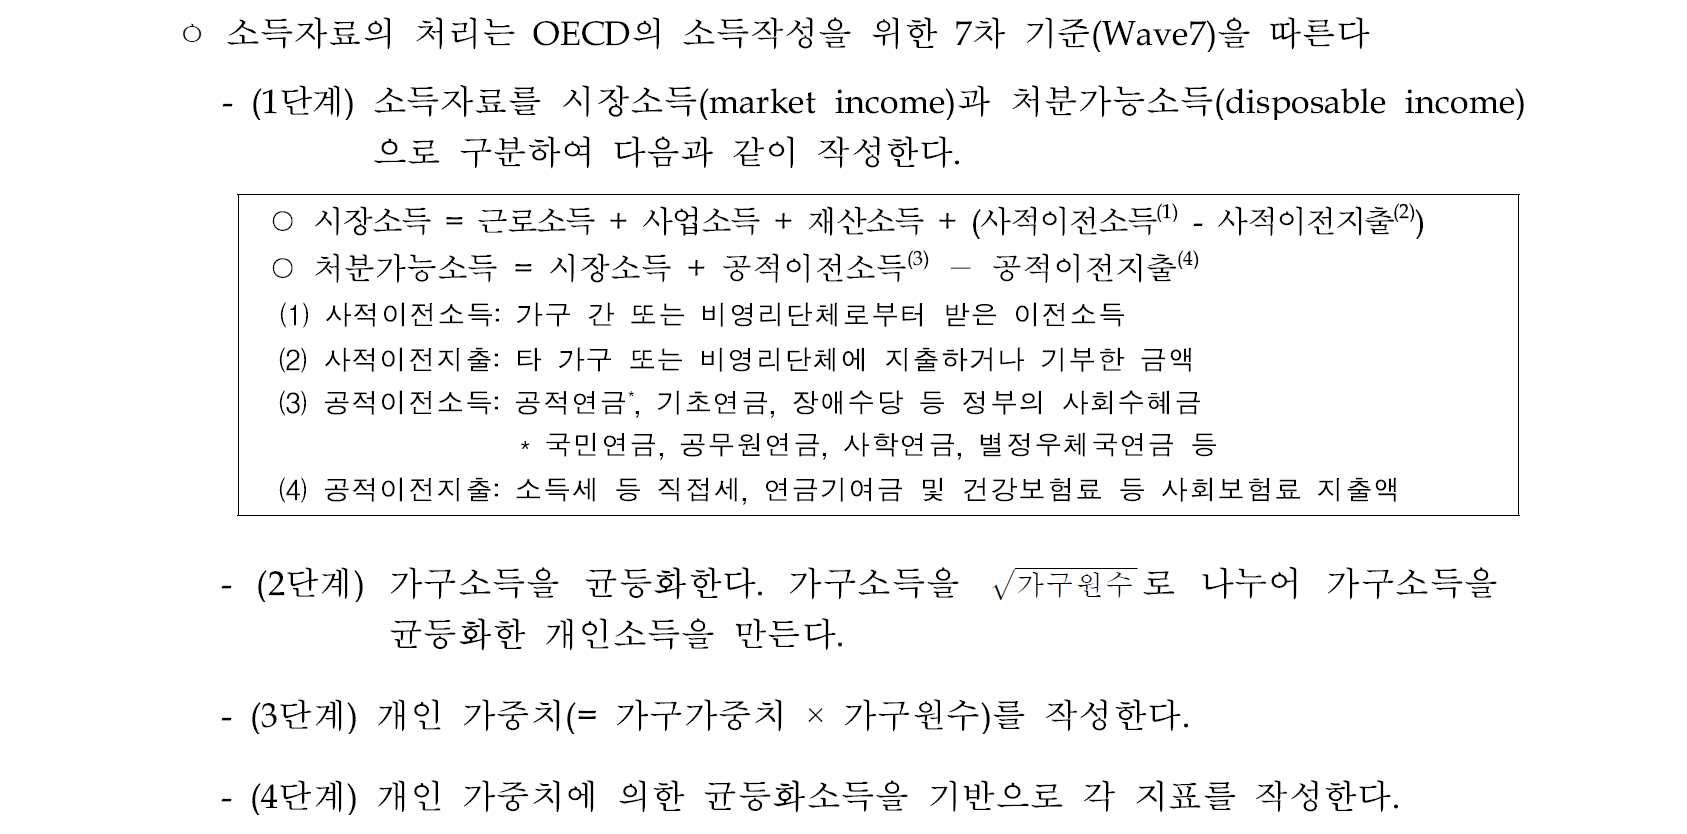
* p.5
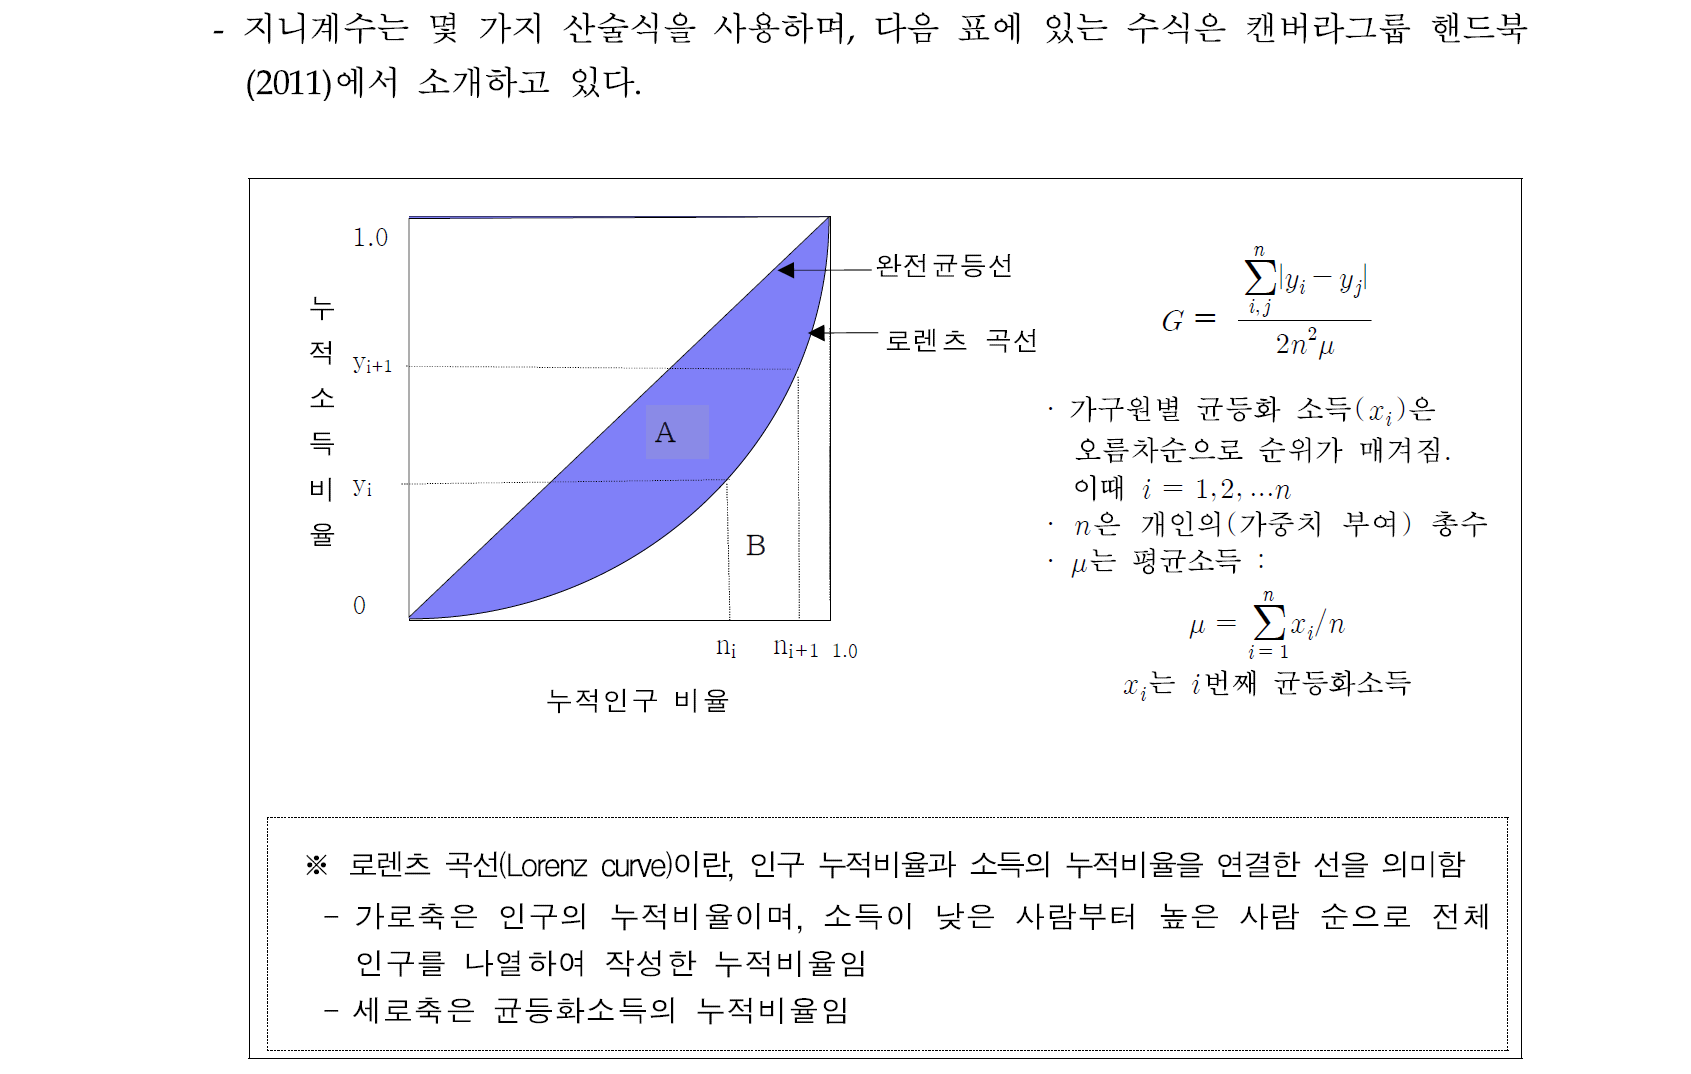

### 균등화 재산 지니 계수

In [105]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '비균등화', '균등화'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)

    # 가구원수 지정
    n = df_year['가구원수']
    
    # 가중치
    weight = df_year['가중값']
    weight_equiv = df_year['가중값']*n
    
    # 지니 계수 계산
    non_equiv_gini = weighted_gini(x, weight)
    equiv_gini = weighted_gini(x/n**(0.5), weight_equiv)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], 
                                          '비균등화': [non_equiv_gini], 
                                          '균등화': [equiv_gini]})],
                           ignore_index=True)

# 결과를 출력
gini_table

연도      비균등화       균등화
0   2010  0.643432  0.611416
1   2011  0.632480  0.597328
2   2012  0.624853  0.592594
3   2013  0.612701  0.580851
4   2014  0.598822  0.566694
5   2015  0.595184  0.563813
6   2016  0.591519  0.557552
7   2017  0.588894  0.554134
8   2018  0.593258  0.558331
9   2019  0.602468  0.566682
10  2020  0.608496  0.572678
11  2021  0.607872  0.569037
12  2022  0.609923  0.566033

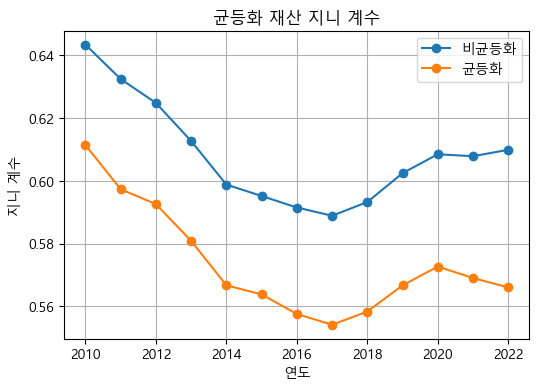

In [106]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
non_equiv_gini = gini_table['비균등화']
equiv_gini = gini_table['균등화']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, non_equiv_gini, marker='o', linestyle='-', label='비균등화')
plt.plot(years, equiv_gini, marker='o', linestyle='-', label='균등화')
plt.title('균등화 재산 지니 계수')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

### 균등화 소득 지니 계수

In [107]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '비균등화', '균등화'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 가구원수 지정
    n = df_year['가구원수']
    
    # 가중치
    weight = df_year['가중값']
    weight_equiv = df_year['가중값']*n
    
    # 지니 계수 계산
    non_equiv_gini = weighted_gini(x, weight)
    equiv_gini = weighted_gini(x/n**(0.5), weight_equiv)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], 
                                          '비균등화': [non_equiv_gini], 
                                          '균등화': [equiv_gini]})],
                           ignore_index=True)

# 결과를 출력
gini_table

연도      비균등화       균등화
0   2010  0.433686  0.371533
1   2011  0.453805  0.393312
2   2012  0.427650  0.363424
3   2013  0.422294  0.359348
4   2014  0.417371  0.352706
5   2015  0.413415  0.346935
6   2016  0.411177  0.343195
7   2017  0.425839  0.356554
8   2018  0.425811  0.356709
9   2019  0.419805  0.346225
10  2020  0.416496  0.340299
11  2021  0.406417  0.332595
12  2022  0.408877  0.333403

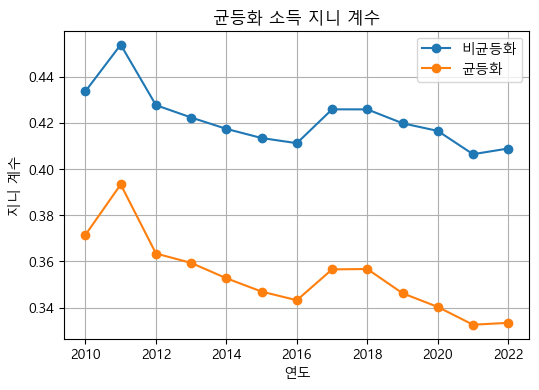

In [108]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니 계수 열을 추출
years = gini_table['연도']
non_equiv_gini = gini_table['비균등화']
equiv_gini = gini_table['균등화']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, non_equiv_gini, marker='o', linestyle='-', label='비균등화')
plt.plot(years, equiv_gini, marker='o', linestyle='-', label='균등화')
plt.title('균등화 소득 지니 계수')
plt.xlabel('연도')
plt.ylabel('지니 계수')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### 참고: 2022년 균등화 시장소득 지니 계수

In [109]:
y1 = df_2022['경상소득(보완)']
y2 = df_2022['경상소득_근로소득(보완)']
y3 = df_2022['경상소득_사업소득(보완)']
y4 = df_2022['경상소득_재산소득(보완)']
y5 = df_2022['경상소득_공적이전소득(보완)']
y6 = df_2022['경상소득_사적이전소득(조사)']
y7 = df_2022['처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]']
weight = df_2022['가중값']
e1 = df_2022['지출_비소비지출(보완)']
e2 = df_2022['지출_비소비지출_세금(보완)']
e3 = df_2022['지출_비소비지출_공적연금사회보험료(보완)']
e4 = df_2022['지출_비소비지출_가구간이전지출(조사)']
e5 = df_2022['지출_비소비지출_비영리단체이전지출(조사)']
e6 = df_2022['지출_비소비지출_연간지급이자(조사)']

In [110]:
# 시장소득(근로소득 + 사업소득 + 재산소득 + 사적이전소득 - 사적이전지출(가구간 및 비영리단체 이전지출))
x1 = y2+y3+y4+y6-(e4+e5)

# 가구원수 지정
n = df_2022['가구원수']

# 가중치
weight = df_2022['가중값']
weight_equiv = df_2022['가중값']*n
    
# 지니 계수 계산
non_equiv_gini = weighted_gini(x1, weight)
equiv_gini = weighted_gini(x1/n**(0.5), weight_equiv)

print('시장소득 지니 계수:', non_equiv_gini)
print('균등화 시장소득 지니 계수:', equiv_gini)

시장소득 지니 계수: 0.4851817453904762
균등화 시장소득 지니 계수: 0.4051233238953859


#### 참고: 2022년 균등화 소득 지니 계수(통계당국 자료)
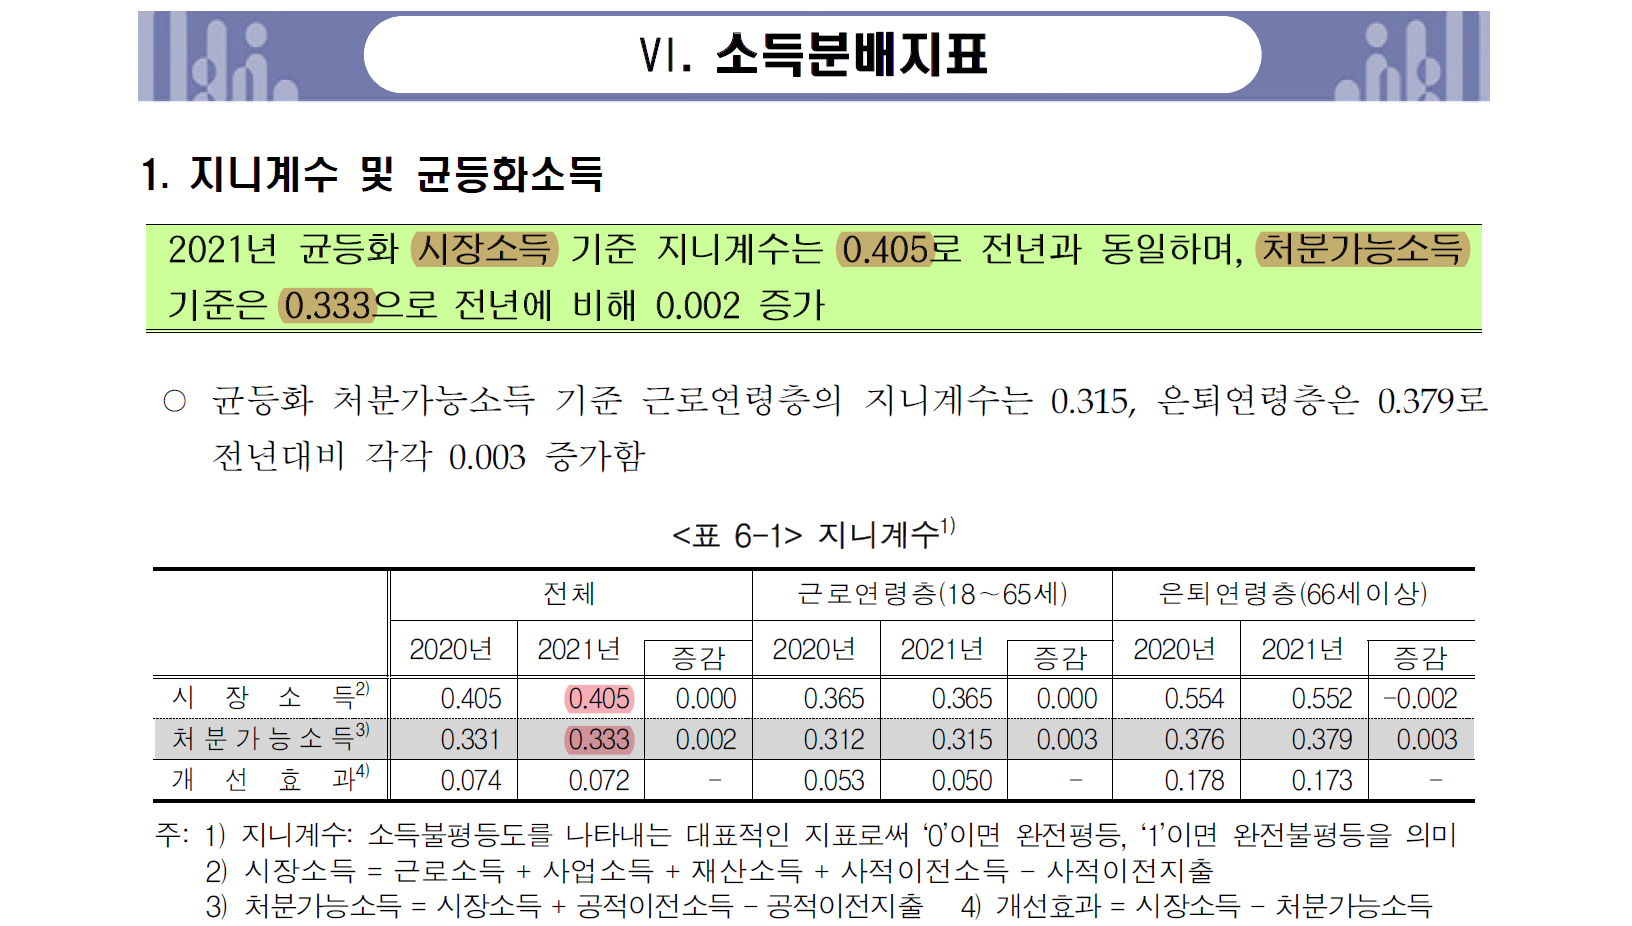

## 8. 분위별 재산 및 소득의 성장

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

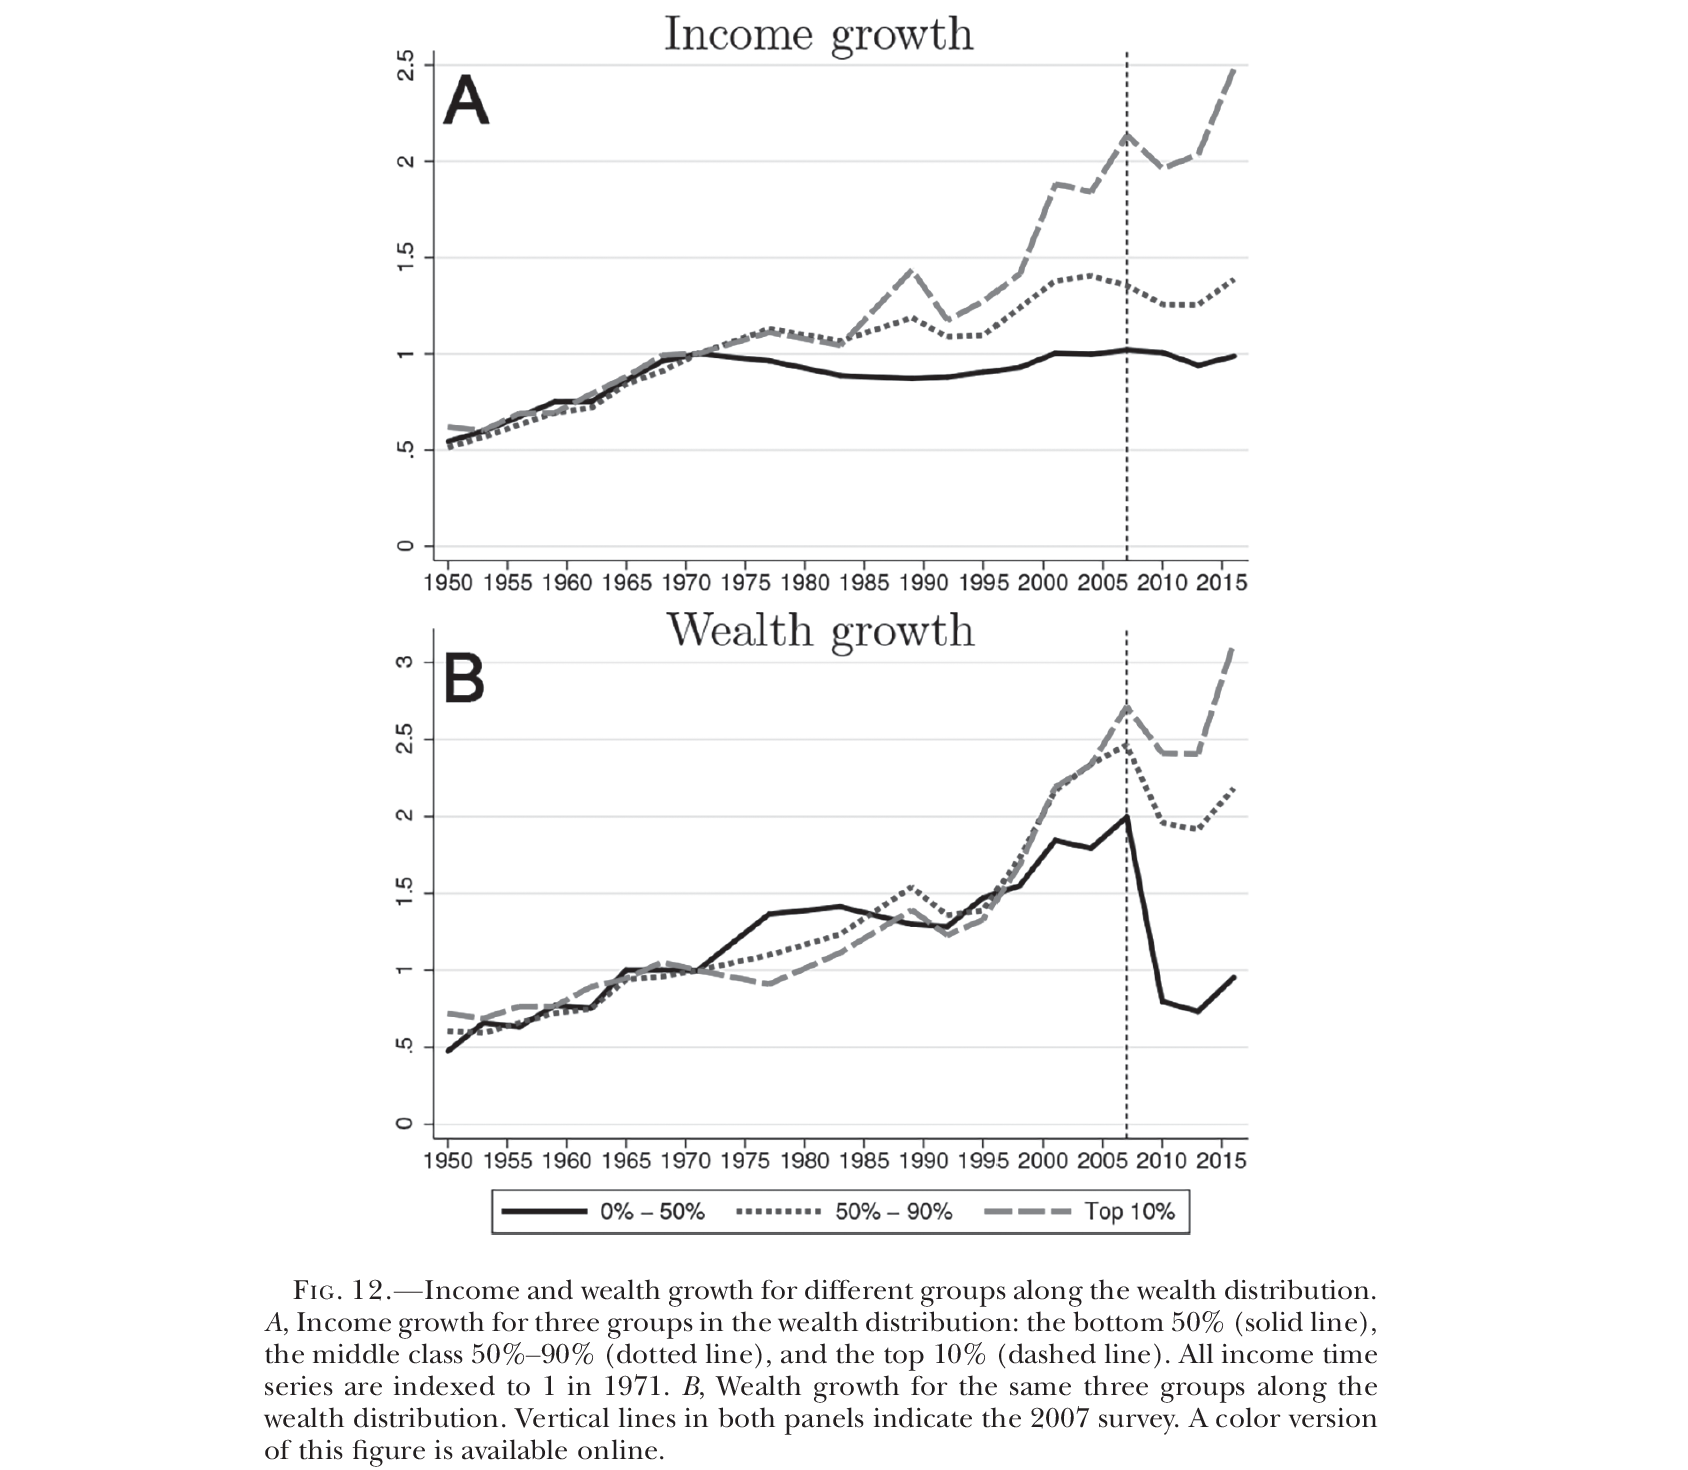

### 재산 분위별 성장

#### A. Without Weights

In [111]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
sub_growth_table = pd.DataFrame(columns=['연도', '0%-50%', '50%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 백분위수 계산
    p_0 = np.percentile(x, 0)
    p_50 = np.percentile(x, 50)
    p_90 = np.percentile(x, 90)
    p_100 = np.percentile(x, 100)
    
    # sub-group 값의 평균 계산
    sub_0_50 = x[(x >= p_0) & (x <= p_50)].mean()
    sub_50_90 = x[(x >= p_50) & (x <= p_90)].mean()
    sub_90_100 = x[(x >= p_90) & (x <= p_100)].mean()

    # 결과를 데이터프레임에 추가
    sub_growth_table = pd.concat([sub_growth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '0%-50%': [sub_0_50], 
                                                '50%-90%': [sub_50_90],
                                                '최상위 10%': [sub_90_100]})],
                                 ignore_index=True)

# 결과를 출력
sub_growth_table

연도     0%-50%     50%-90%      최상위 10%
0   2010  48.099033  319.305437  1485.953782
1   2011  51.096600  327.568423  1423.731018
2   2012  52.940325  320.821746  1441.940297
3   2013  55.429850  322.802486  1373.776036
4   2014  59.193445  328.286775  1319.435504
5   2015  60.328236  335.690007  1337.311985
6   2016  62.498068  354.866277  1390.889791
7   2017  63.992081  363.385087  1409.612023
8   2018  67.135649  383.941278  1525.577718
9   2019  65.762630  382.198297  1549.795178
10  2020  65.086181  384.649932  1548.221140
11  2021  68.341041  426.653551  1707.821510
12  2022  69.901687  454.420011  1827.579066

In [112]:
# 금액을 2010년 대비 배수로 만들기
sub_growth_table_10 = sub_growth_table.copy()

for column in sub_growth_table_10.columns[1:]:
    sub_growth_table_10[column] = sub_growth_table_10[column] /\
    sub_growth_table_10.iloc[0][column]

# 결과를 출력
sub_growth_table_10

연도    0%-50%   50%-90%   최상위 10%
0   2010  1.000000  1.000000  1.000000
1   2011  1.062321  1.025878  0.958126
2   2012  1.100653  1.004749  0.970380
3   2013  1.152411  1.010952  0.924508
4   2014  1.230658  1.028128  0.887938
5   2015  1.254250  1.051313  0.899969
6   2016  1.299362  1.111369  0.936025
7   2017  1.330423  1.138049  0.948624
8   2018  1.395780  1.202426  1.026666
9   2019  1.367234  1.196968  1.042963
10  2020  1.353170  1.204646  1.041904
11  2021  1.420840  1.336193  1.149310
12  2022  1.453287  1.423151  1.229903

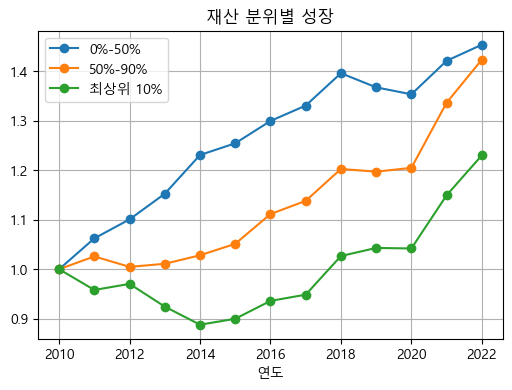

In [113]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = sub_growth_table_10['연도']
sub_0_50 = sub_growth_table_10['0%-50%']
sub_50_90 = sub_growth_table_10['50%-90%']
sub_90_100 = sub_growth_table_10['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, sub_0_50, marker='o', linestyle='-', label='0%-50%')
plt.plot(years, sub_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, sub_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('재산 분위별 성장')
plt.xlabel('연도')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### (2) With Weights

In [114]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
sub_growth_table = pd.DataFrame(columns=['연도', '0%-50%', '50%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # x 값을 계산
    x = df_year['순자산'] / 100
    x = x / (cpi_year / 100)
    
    # 가중치 지정
    weight = df_year['가중값']
    
    # 백분위수 계산
    p_0 = weighted_percentile(x, weight, 0)
    p_50 = weighted_percentile(x, weight, 50)
    p_90 = weighted_percentile(x, weight, 90)
    p_100 = weighted_percentile(x, weight, 100)
    
    # 두 배열 생성
    data = {'x': x, 'w': weight}
    df = pd.DataFrame(data)

    # sub-group 값의 가중평균 계산
    subset_df = df[(df['x'] >= p_0) & (df['x'] < p_50)]
    sub_0_50 = weighted_mean(subset_df['x'], subset_df['w'])
    subset_df = df[(df['x'] >= p_50) & (df['x'] < p_90)]
    sub_50_90 = weighted_mean(subset_df['x'], subset_df['w'])
    subset_df = df[(df['x'] >= p_90) & (df['x'] <= p_100)]
    sub_90_100 = weighted_mean(subset_df['x'], subset_df['w'])

    # 결과를 데이터프레임에 추가
    sub_growth_table = pd.concat([sub_growth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '0%-50%': [sub_0_50], 
                                                '50%-90%': [sub_50_90],
                                                '최상위 10%': [sub_90_100]})],
                                 ignore_index=True)

# 결과를 출력
sub_growth_table

연도     0%-50%     50%-90%      최상위 10%
0   2010  45.715935  295.022371  1260.410196
1   2011  48.796057  307.494946  1259.254513
2   2012  55.872336  324.048098  1350.601499
3   2013  58.044594  326.256157  1288.938582
4   2014  62.883894  334.696342  1264.731827
5   2015  65.334164  346.049837  1285.315241
6   2016  68.118976  366.597257  1316.201725
7   2017  70.894246  381.728044  1350.974774
8   2018  74.952662  406.548081  1467.225023
9   2019  73.744473  410.313168  1536.212395
10  2020  72.963361  419.299577  1586.096938
11  2021  79.844778  473.648307  1749.946139
12  2022  80.694309  501.876308  1821.798670

In [115]:
# 금액을 첫 해 대비 배수로 만들기
sub_growth_table_10 = sub_growth_table.copy()

for column in sub_growth_table_10.columns[1:]:
    sub_growth_table_10[column] = sub_growth_table_10[column] /\
    sub_growth_table_10.iloc[0][column]

# 결과를 출력
sub_growth_table_10

연도    0%-50%   50%-90%   최상위 10%
0   2010  1.000000  1.000000  1.000000
1   2011  1.067375  1.042277  0.999083
2   2012  1.222163  1.098385  1.071557
3   2013  1.269680  1.105869  1.022634
4   2014  1.375536  1.134478  1.003429
5   2015  1.429133  1.172961  1.019759
6   2016  1.490049  1.242608  1.044265
7   2017  1.550756  1.293895  1.071853
8   2018  1.639530  1.378025  1.164085
9   2019  1.613102  1.390787  1.218819
10  2020  1.596016  1.421247  1.258397
11  2021  1.746542  1.605466  1.388394
12  2022  1.765124  1.701147  1.445401

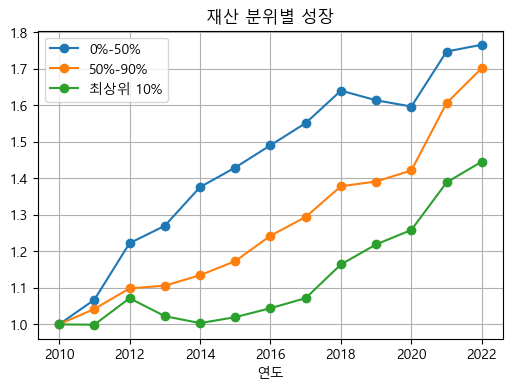

In [116]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = sub_growth_table_10['연도']
sub_0_50 = sub_growth_table_10['0%-50%']
sub_50_90 = sub_growth_table_10['50%-90%']
sub_90_100 = sub_growth_table_10['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, sub_0_50, marker='o', linestyle='-', label='0%-50%')
plt.plot(years, sub_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, sub_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('재산 분위별 성장')
plt.xlabel('연도')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

### 소득 분위별 성장

#### A. Without Weights

In [117]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
sub_growth_table = pd.DataFrame(columns=['연도', '0%-50%', '50%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 백분위수 계산
    p_0 = np.percentile(x, 0)
    p_50 = np.percentile(x, 50)
    p_90 = np.percentile(x, 90)
    p_100 = np.percentile(x, 100)
    
    # sub-group 값의 평균 계산
    sub_0_50 = x[(x >= p_0) & (x <= p_50)].mean()
    sub_50_90 = x[(x >= p_50) & (x <= p_90)].mean()
    sub_90_100 = x[(x >= p_90) & (x <= p_100)].mean()

    # 결과를 데이터프레임에 추가
    sub_growth_table = pd.concat([sub_growth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '0%-50%': [sub_0_50], 
                                                '50%-90%': [sub_50_90],
                                                '최상위 10%': [sub_90_100]})],
                                 ignore_index=True)

# 결과를 출력
sub_growth_table

연도     0%-50%    50%-90%     최상위 10%
0   2010  15.496185  48.167034  121.094787
1   2011  15.130460  48.698275  127.534706
2   2012  16.210221  49.722726  123.190538
3   2013  16.237504  50.913511  124.665367
4   2014  16.777848  52.399573  123.852560
5   2015  16.934832  53.052817  123.288092
6   2016  17.061917  53.599088  123.821509
7   2017  17.566429  57.736256  138.484920
8   2018  17.721433  57.727537  139.019328
9   2019  18.138771  58.327406  135.743906
10  2020  18.756613  59.198504  134.896702
11  2021  18.956445  57.933193  133.263573
12  2022  18.561415  57.419462  135.778246

In [118]:
# 금액을 첫 해 대비 배수로 만들기
sub_growth_table_10 = sub_growth_table.copy()

for column in sub_growth_table_10.columns[1:]:
    sub_growth_table_10[column] = sub_growth_table_10[column] /\
    sub_growth_table_10.iloc[0][column]

# 결과를 출력
sub_growth_table_10

연도    0%-50%   50%-90%   최상위 10%
0   2010  1.000000  1.000000  1.000000
1   2011  0.976399  1.011029  1.053181
2   2012  1.046078  1.032298  1.017307
3   2013  1.047839  1.057020  1.029486
4   2014  1.082708  1.087872  1.022774
5   2015  1.092839  1.101434  1.018112
6   2016  1.101040  1.112775  1.022517
7   2017  1.133597  1.198667  1.143608
8   2018  1.143600  1.198486  1.148021
9   2019  1.170531  1.210940  1.120972
10  2020  1.210402  1.229025  1.113976
11  2021  1.223298  1.202756  1.100490
12  2022  1.197805  1.192090  1.121256

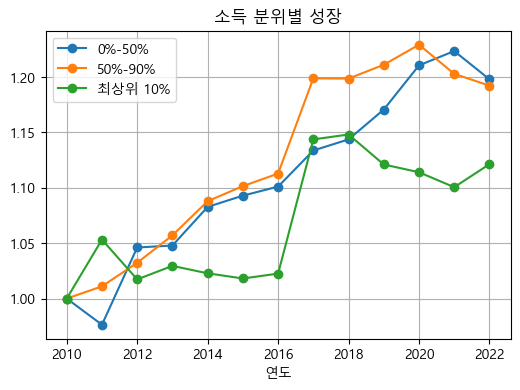

In [119]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = sub_growth_table_10['연도']
sub_0_50 = sub_growth_table_10['0%-50%']
sub_50_90 = sub_growth_table_10['50%-90%']
sub_90_100 = sub_growth_table_10['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, sub_0_50, marker='o', linestyle='-', label='0%-50%')
plt.plot(years, sub_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, sub_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('소득 분위별 성장')
plt.xlabel('연도')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### B. With Weights

In [120]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
sub_growth_table = pd.DataFrame(columns=['연도', '0%-50%', '50%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income_column] + df_year[interest_payment]

    # x 값을 계산
    x = x / 100
    x = x / (cpi_year / 100)
    
    # 가중치 지정
    weight = df_year['가중값']
    
    # 백분위수 계산
    p_0 = weighted_percentile(x, weight, 0)
    p_50 = weighted_percentile(x, weight, 50)
    p_90 = weighted_percentile(x, weight, 90)
    p_100 = weighted_percentile(x, weight, 100)
    
    # 두 배열 생성
    data = {'x': x, 'w': weight}
    df = pd.DataFrame(data)

    # sub-group 값의 가중평균 계산
    subset_df = df[(df['x'] >= p_0) & (df['x'] < p_50)]
    sub_0_50 = weighted_mean(subset_df['x'], subset_df['w'])
    subset_df = df[(df['x'] >= p_50) & (df['x'] < p_90)]
    sub_50_90 = weighted_mean(subset_df['x'], subset_df['w'])
    subset_df = df[(df['x'] >= p_90) & (df['x'] <= p_100)]
    sub_90_100 = weighted_mean(subset_df['x'], subset_df['w'])

    # 결과를 데이터프레임에 추가
    sub_growth_table = pd.concat([sub_growth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '0%-50%': [sub_0_50], 
                                                '50%-90%': [sub_50_90],
                                                '최상위 10%': [sub_90_100]})],
                                 ignore_index=True)

# 결과를 출력
sub_growth_table

연도     0%-50%    50%-90%     최상위 10%
0   2010  15.172611  46.659063  111.956557
1   2011  14.943736  47.680510  122.321262
2   2012  16.499978  49.434422  117.923620
3   2013  17.374819  51.517740  120.167146
4   2014  18.104493  53.171865  121.551889
5   2015  18.528964  54.469039  121.512865
6   2016  18.883036  55.370631  122.320879
7   2017  19.724683  60.793092  138.504512
8   2018  20.138816  61.808184  141.462715
9   2019  20.655980  62.744599  140.476805
10  2020  21.109086  63.512575  141.703486
11  2021  22.102657  63.677755  141.625182
12  2022  21.848274  63.537138  141.428820

In [121]:
# 금액을 첫 해 대비 배수로 만들기
sub_growth_table_10 = sub_growth_table.copy()

for column in sub_growth_table_10.columns[1:]:
    sub_growth_table_10[column] = sub_growth_table_10[column] /\
    sub_growth_table_10.iloc[0][column]

# 결과를 출력
sub_growth_table_10

연도    0%-50%   50%-90%   최상위 10%
0   2010  1.000000  1.000000  1.000000
1   2011  0.984915  1.021892  1.092578
2   2012  1.087484  1.059482  1.053298
3   2013  1.145144  1.104131  1.073337
4   2014  1.193235  1.139583  1.085706
5   2015  1.221211  1.167384  1.085357
6   2016  1.244548  1.186707  1.092574
7   2017  1.300019  1.302921  1.237127
8   2018  1.327314  1.324677  1.263550
9   2019  1.361399  1.344746  1.254744
10  2020  1.391263  1.361206  1.265701
11  2021  1.456747  1.364746  1.265001
12  2022  1.439981  1.361732  1.263247

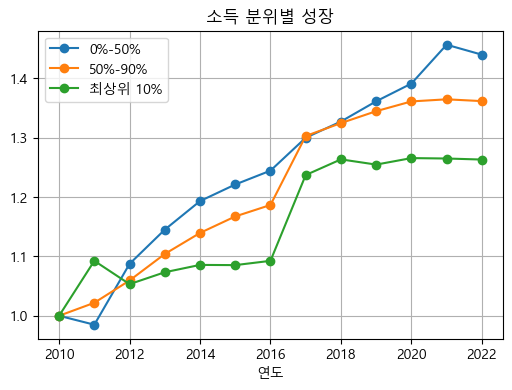

In [122]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = sub_growth_table_10['연도']
sub_0_50 = sub_growth_table_10['0%-50%']
sub_50_90 = sub_growth_table_10['50%-90%']
sub_90_100 = sub_growth_table_10['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, sub_0_50, marker='o', linestyle='-', label='0%-50%')
plt.plot(years, sub_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, sub_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('소득 분위별 성장')
plt.xlabel('연도')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

### 재산 분위별 소득의 성장

#### A. Without Weights

In [123]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
sub_growth_table = pd.DataFrame(columns=['연도', '0%-50%', '50%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # x1 값을 계산
    x1 = df_year['순자산'] / 100
    x1 = x1 / (cpi_year / 100)
    
    # x2 값을 계산(통계당국 처분가능소득 계산)
    x2 = df_year[income_column] + df_year[interest_payment]
    x2 = x2 / 100
    x2 = x2 / (cpi_year / 100)    

    # 백분위수 계산
    p_0 = np.percentile(x1, 0)
    p_50 = np.percentile(x1, 50)
    p_90 = np.percentile(x1, 90)
    p_100 = np.percentile(x1, 100)
    
    # sub-group 값의 평균 계산
    sub_0_50 = x2[(x1 >= p_0) & (x1 < p_50)].mean()
    sub_50_90 = x2[(x1 >= p_50) & (x1 < p_90)].mean()
    sub_90_100 = x2[(x1 >= p_90) & (x1 <= p_100)].mean()

    # 결과를 데이터프레임에 추가
    sub_growth_table = pd.concat([sub_growth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '0%-50%': [sub_0_50], 
                                                '50%-90%': [sub_50_90],
                                                '최상위 10%': [sub_90_100]})],
                                 ignore_index=True)

# 결과를 출력
sub_growth_table

연도     0%-50%    50%-90%    최상위 10%
0   2010  24.907781  46.593970  80.329061
1   2011  25.211824  47.237398  82.993805
2   2012  24.144115  47.905152  90.794248
3   2013  24.689255  48.847064  90.694063
4   2014  25.523684  50.258011  88.727399
5   2015  25.920801  50.568820  88.268432
6   2016  25.849682  51.195771  89.494217
7   2017  27.955395  54.917879  97.825482
8   2018  28.211387  55.006181  97.455919
9   2019  28.850840  55.331383  94.187628
10  2020  29.686506  55.929532  93.292274
11  2021  29.606990  55.004212  91.680655
12  2022  29.056848  54.938485  93.203141

In [124]:
# 금액을 첫 해 대비 배수로 만들기
sub_growth_table_10 = sub_growth_table.copy()

for column in sub_growth_table_10.columns[1:]:
    sub_growth_table_10[column] = sub_growth_table_10[column] /\
    sub_growth_table_10.iloc[0][column]

# 결과를 출력
sub_growth_table_10

연도    0%-50%   50%-90%   최상위 10%
0   2010  1.000000  1.000000  1.000000
1   2011  1.012207  1.013809  1.033173
2   2012  0.969340  1.028141  1.130279
3   2013  0.991227  1.048356  1.129032
4   2014  1.024727  1.078638  1.104549
5   2015  1.040671  1.085308  1.098836
6   2016  1.037815  1.098764  1.114095
7   2017  1.122356  1.178648  1.217809
8   2018  1.132633  1.180543  1.213209
9   2019  1.158306  1.187522  1.172522
10  2020  1.191857  1.200360  1.161376
11  2021  1.188664  1.180501  1.141314
12  2022  1.166577  1.179090  1.160267

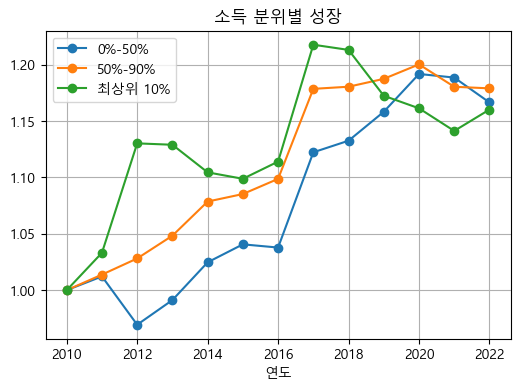

In [125]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = sub_growth_table_10['연도']
sub_0_50 = sub_growth_table_10['0%-50%']
sub_50_90 = sub_growth_table_10['50%-90%']
sub_90_100 = sub_growth_table_10['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, sub_0_50, marker='o', linestyle='-', label='0%-50%')
plt.plot(years, sub_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, sub_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('소득 분위별 성장')
plt.xlabel('연도')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

#### B. With Weights

In [126]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
sub_growth_table = pd.DataFrame(columns=['연도', '0%-50%', '50%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # x1 값을 계산
    x1 = df_year['순자산'] / 100
    x1 = x1 / (cpi_year / 100)
    
    # x2 값을 계산(통계당국 처분가능소득 계산)
    x2 = df_year[income_column] + df_year[interest_payment]
    x2 = x2 / 100
    x2 = x2 / (cpi_year / 100)    
    
    # 가중치 지정
    weight = df_year['가중값']
    
    # 백분위수 계산
    p_0 = weighted_percentile(x1, weight, 0)
    p_50 = weighted_percentile(x1, weight, 50)
    p_90 = weighted_percentile(x1, weight, 90)
    p_100 = weighted_percentile(x1, weight, 100)
    
    # 세 배열 생성
    data = {'x1': x1, 'x2': x2, 'w': weight}
    df = pd.DataFrame(data)

    # sub-group 값의 가중평균 계산
    subset_df = df[(df['x1'] >= p_0) & (df['x1'] < p_50)]
    sub_0_50 = weighted_mean(subset_df['x2'], subset_df['w'])
    subset_df = df[(df['x1'] >= p_50) & (df['x1'] < p_90)]
    sub_50_90 = weighted_mean(subset_df['x2'], subset_df['w'])
    subset_df = df[(df['x1'] >= p_90) & (df['x1'] <= p_100)]
    sub_90_100 = weighted_mean(subset_df['x2'], subset_df['w'])

    # 결과를 데이터프레임에 추가
    sub_growth_table = pd.concat([sub_growth_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '0%-50%': [sub_0_50], 
                                                '50%-90%': [sub_50_90],
                                                '최상위 10%': [sub_90_100]})],
                                 ignore_index=True)

# 결과를 출력
sub_growth_table

연도     0%-50%    50%-90%    최상위 10%
0   2010  24.457240  44.940890  72.451537
1   2011  24.871495  45.958560  79.751831
2   2012  24.710924  47.327822  85.407446
3   2013  25.941697  49.297254  86.234830
4   2014  26.874927  50.901051  86.879457
5   2015  27.682468  51.916831  85.953760
6   2016  27.946046  52.980844  86.647170
7   2017  30.581797  57.646015  96.806010
8   2018  31.137346  58.972352  97.897882
9   2019  31.999676  59.530513  96.783611
10  2020  32.654257  59.774381  98.971502
11  2021  33.645859  60.118621  98.173665
12  2022  33.114525  60.477681  97.311970

In [127]:
# 금액을 첫 해 대비 배수로 만들기
sub_growth_table_10 = sub_growth_table.copy()

for column in sub_growth_table_10.columns[1:]:
    sub_growth_table_10[column] = sub_growth_table_10[column] /\
    sub_growth_table_10.iloc[0][column]

# 결과를 출력
sub_growth_table_10

연도    0%-50%   50%-90%   최상위 10%
0   2010  1.000000  1.000000  1.000000
1   2011  1.016938  1.022645  1.100761
2   2012  1.010373  1.053113  1.178822
3   2013  1.060696  1.096935  1.190242
4   2014  1.098854  1.132622  1.199139
5   2015  1.131872  1.155225  1.186362
6   2016  1.142649  1.178901  1.195933
7   2017  1.250419  1.282707  1.336148
8   2018  1.273134  1.312220  1.351219
9   2019  1.308393  1.324640  1.335839
10  2020  1.335157  1.330067  1.366037
11  2021  1.375701  1.337727  1.355025
12  2022  1.353976  1.345716  1.343132

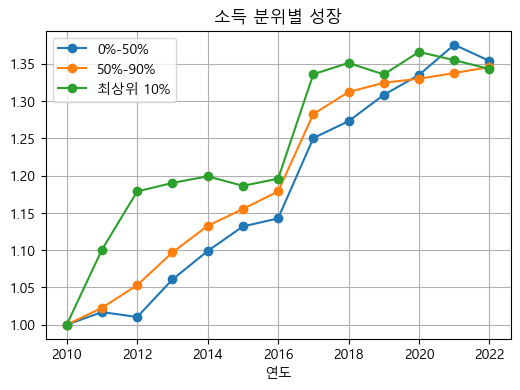

In [128]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = sub_growth_table_10['연도']
sub_0_50 = sub_growth_table_10['0%-50%']
sub_50_90 = sub_growth_table_10['50%-90%']
sub_90_100 = sub_growth_table_10['최상위 10%']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, sub_0_50, marker='o', linestyle='-', label='0%-50%')
plt.plot(years, sub_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, sub_90_100, marker='o', linestyle='-', label='최상위 10%')
plt.title('소득 분위별 성장')
plt.xlabel('연도')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

## 9. 재산 분위별 재산/소득 배율

#### 관련 자료

- Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

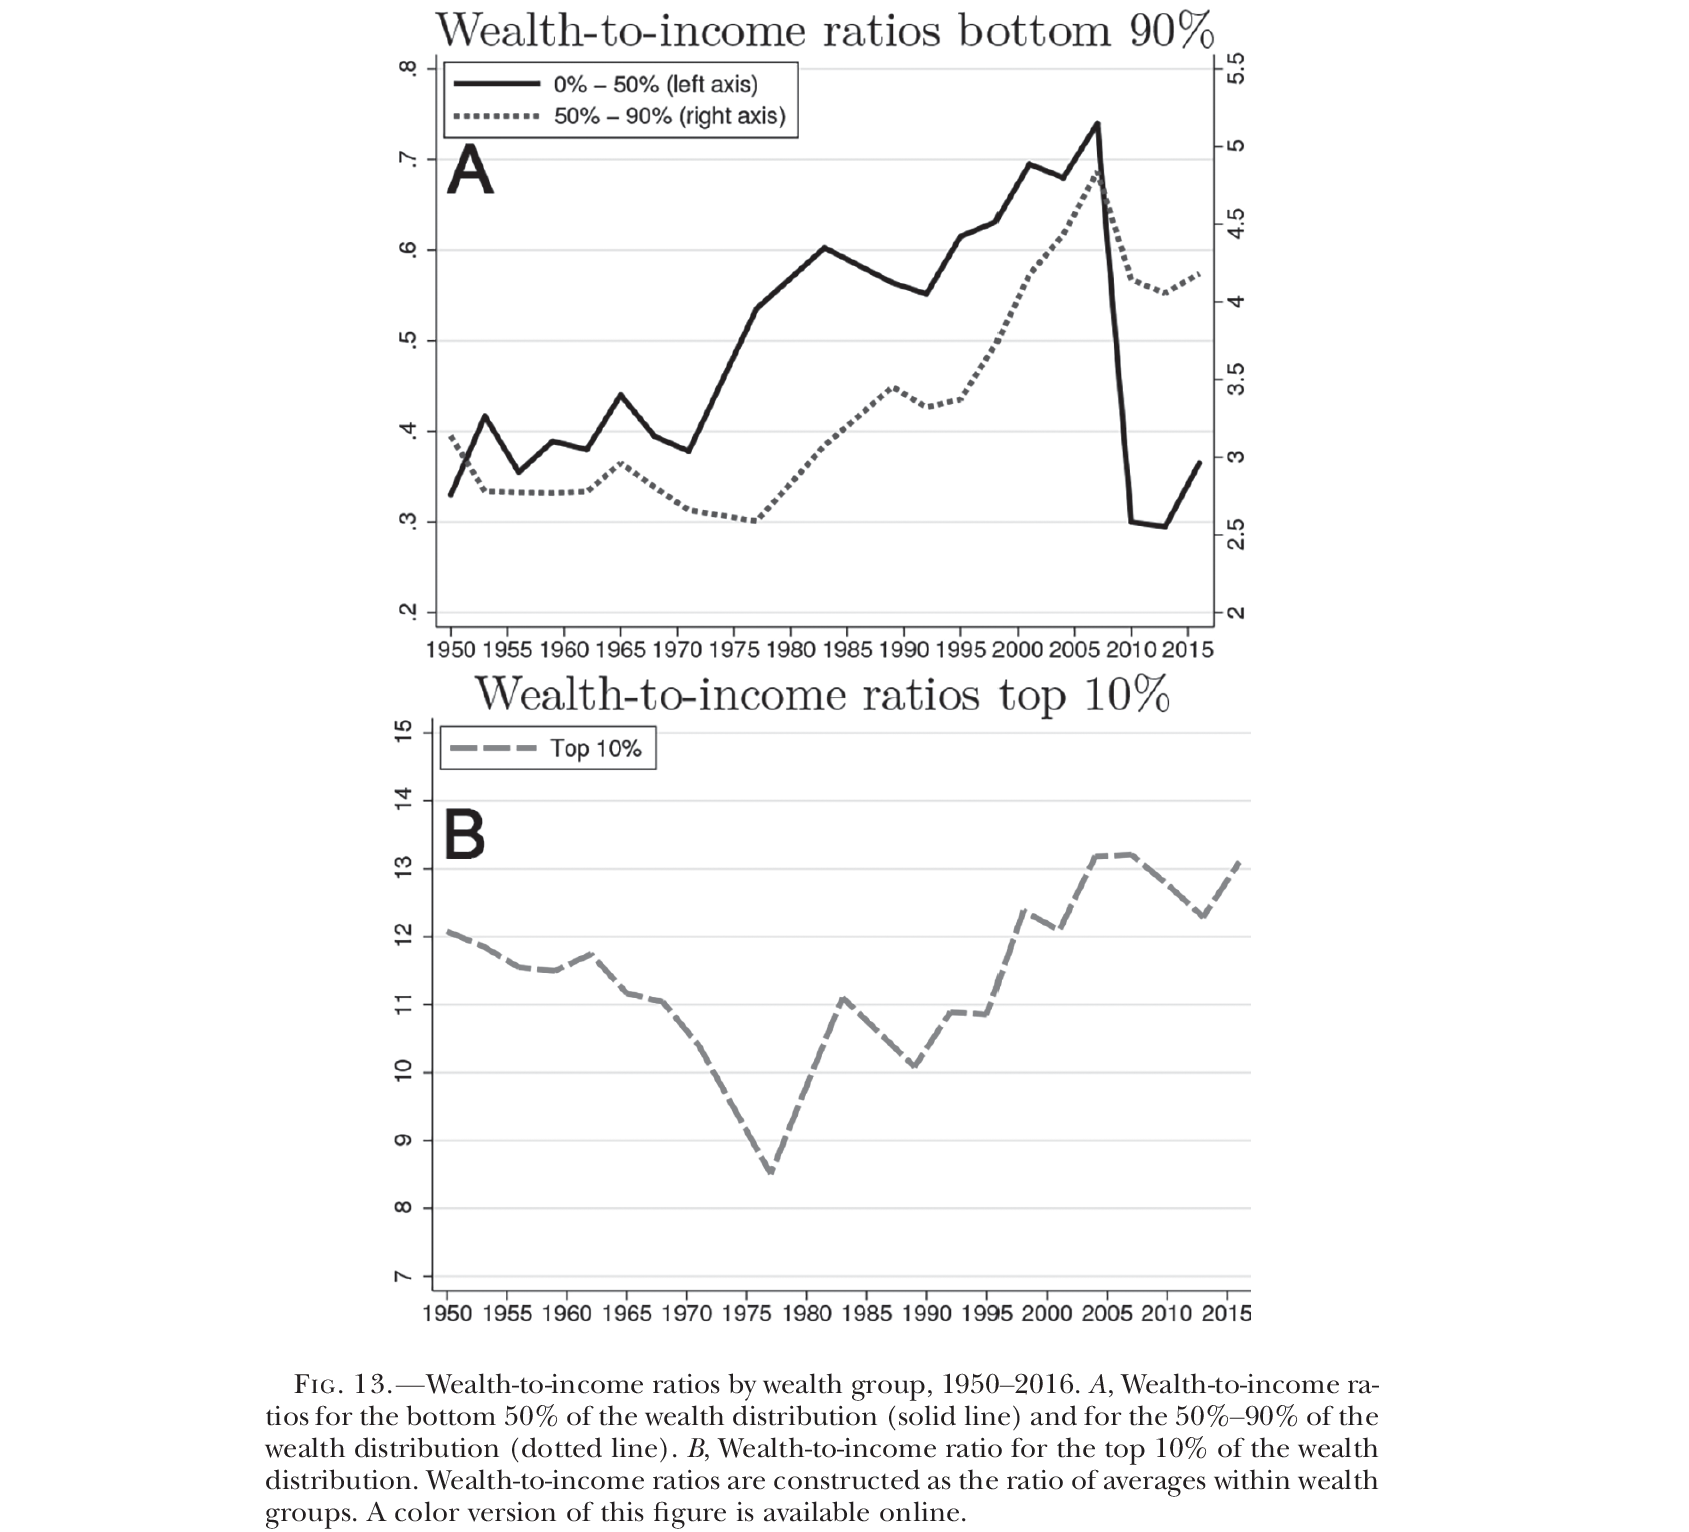

### 재산 분위별 재산/소득 배율

#### A. Without Weights

In [129]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
sub_ratio_table = pd.DataFrame(columns=['연도', '0%-50%', '50%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # x1 값을 계산
    x1 = df_year['순자산'] / 100
    x1 = x1 / (cpi_year / 100)
    
    # x2 값을 계산(통계당국 처분가능소득 계산)
    x2 = df_year[income_column] + df_year[interest_payment]
    x2 = x2 / 100
    x2 = x2 / (cpi_year / 100)    

    # 백분위수 계산
    p_0 = np.percentile(x1, 0)
    p_50 = np.percentile(x1, 50)
    p_90 = np.percentile(x1, 90)
    p_100 = np.percentile(x1, 100)
    
    # sub-group 평균값의 비율 계산
    sub_0_50 = (x1[(x1 >= p_0) & (x1 < p_50)].mean()
                /x2[(x1 >= p_0) & (x1 < p_50)].mean())
    sub_50_90 = (x1[(x1 >= p_50) & (x1 < p_90)].mean()
                /x2[(x1 >= p_50) & (x1 < p_90)].mean())
    sub_90_100 = (x1[(x1 >= p_90) & (x1 <= p_100)].mean()
                  /x2[(x1 >= p_90) & (x1 <= p_100)].mean())

    # 결과를 데이터프레임에 추가
    sub_ratio_table = pd.concat([sub_ratio_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '0%-50%': [sub_0_50], 
                                                '50%-90%': [sub_50_90],
                                                '최상위 10%': [sub_90_100]})],
                                 ignore_index=True)

# 결과를 출력
sub_ratio_table

연도    0%-50%   50%-90%    최상위 10%
0   2010  1.931085  6.852935  18.498334
1   2011  2.025184  6.934514  17.154666
2   2012  2.192680  6.697020  15.881406
3   2013  2.245100  6.608432  15.147364
4   2014  2.318278  6.532029  14.870666
5   2015  2.326959  6.637386  15.150513
6   2016  2.416812  6.931554  15.541672
7   2017  2.288196  6.616881  14.409456
8   2018  2.379736  6.979966  15.654028
9   2019  2.278085  6.907442  16.454339
10  2020  2.189371  6.877403  16.595384
11  2021  2.307806  7.756743  18.627937
12  2022  2.404178  8.271433  19.608557

**<span style="font-size: 1.7em; ">Q</span>** &nbsp;&nbsp;

>**아래 3개의 선그래프에서 처음 두 개는 왼쪽 축을 사용하고, 마지막 그래프는 오른쪽 축을 사용하라. 왼쪽 축의 범위는 0에서 10이고, 오른쪽 축은 10에서 20까지이다. 세 그래프의 레전드가 하나의 박스 안에 모두 나오게 하라.**
>
>```
plt.plot(years, sub_0_50, marker='o', linestyle='-', label='0%-50%')
plt.plot(years, sub_50_90, marker='o', linestyle='-', label='50%-90%')
plt.plot(years, sub_90_100, marker='o', linestyle='-', label='최상위 10%')
>```

**<span style="font-size: 1.7em; color: mediumseagreen;">A</span>** &nbsp;&nbsp; 

> 아래 코드는 처음 두 개의 그래프가 왼쪽 축을 사용하고, 마지막 그래프는 오른쪽 축을 사용하며, 레전드가 하나의 박스 안에 모두 표시됩니다. 왼쪽 축의 범위는 0에서 10, 오른쪽 축은 10에서 20으로 설정되어 있습니다.
>
>```python
import matplotlib.pyplot as plt
>
># 데이터 준비
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
sub_0_50 = [8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3]
sub_50_90 = [9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2]
sub_90_100 = [15.0, 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16.0, 16.1, 16.2]
>
># 그래프 생성
fig, ax1 = plt.subplots()
>
># 왼쪽 축 (ax1) 설정
ax1.set_xlabel('연도')
ax1.set_ylabel('0%-50%', color='tab:blue')
ax1.plot(years, sub_0_50, marker='o', linestyle='-', label='0%-50%', color='tab:blue')
ax1.plot(years, sub_50_90, marker='o', linestyle='-', label='50%-90%', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
>
># 오른쪽 축 (ax2) 설정
ax2 = ax1.twinx()
ax2.set_ylabel('최상위 10%', color='tab:green')
ax2.plot(years, sub_90_100, marker='o', linestyle='-', label='최상위 10%', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
>
># 레전드 표시
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
>
># 그래프 출력
plt.title('세 부분별 그래프')
plt.show()
>```
>
>이 코드를 실행하면 세 개의 선 그래프가 하나의 그래프에 표시됩니다. 첫 두 그래프는 왼쪽 축을 사용하고, 세 번째 그래프는 오른쪽 축을 사용하며, 레전드는 하나의 박스 안에 모두 표시됩니다.

**<span style="font-size: 1.7em; ">Q</span>** &nbsp;&nbsp;

>**위 코드의 ax2.legend(lines + lines2, labels + labels2, loc=0)에서 loc=0은 무엇을 의미하는가?**

**<span style="font-size: 1.7em; color: mediumseagreen;">A</span>** &nbsp;&nbsp; 

> `ax2.legend(lines + lines2, labels + labels2, loc=0)`에서 `loc=0`은 레전드(legend)의 위치를 의미합니다. `loc` 매개변수는 레전드의 위치를 제어하는 데 사용됩니다. `loc=0`은 "best" 위치로 설정됩니다. 이것은 Matplotlib에게 가장 적절한 위치를 자동으로 선택하도록 하는 옵션이며, Matplotlib은 그래프 내에서 데이터를 가리지 않으면서 가장 좋은 위치를 선택합니다.
>
>"best" 위치는 레전드가 데이터와 겹치지 않고 가장 적절한 위치에 표시되도록 선택됩니다. 따라서 `loc=0`를 사용하면 Matplotlib이 레전드의 최적 위치를 자동으로 결정합니다.
>
>여러 다른 `loc` 값을 사용하여 레전드를 원하는 위치에 직접 배치할 수 있습니다. 이러한 위치 코드는 `loc` 값에 따라 다양한 위치(예: 우측 상단, 좌측 하단, 중앙 등)에 레전드를 배치할 수 있습니다.

**<span style="font-size: 1.7em; ">Q</span>** &nbsp;&nbsp;

>**아래 코딩에서 왼쪽 축을 0에서 16까지로 하되, 틱 레이블은 0, 2, 4, 6, 8, 10만 표시되고, 12, 14, 16은 나타나지 않게 하고 싶다.**
>
>```
># 왼쪽 축 (ax1) 설정
ax1.set_xlabel('연도')
ax1.plot(years, sub_50_90, marker='o', linestyle='-',
         label='50%-90% (좌축)', color='tab:orange')
ax1.plot(years, sub_0_50, marker='o', linestyle='-', 
         label='0%-50% (좌축)', color='tab:blue')
plt.ylim(0, 16)
>```

**<span style="font-size: 1.7em; color: mediumseagreen;">A</span>** &nbsp;&nbsp; 

> 아래와 같이 코드를 수정하여 특정 틱 레이블만 표시하고 나머지는 숨길 수 있습니다.
>
>```python
># 왼쪽 축 (ax1) 설정
ax1.set_xlabel('연도')
ax1.plot(years, sub_50_90, marker='o', linestyle='-', 
         label='50%-90% (좌축)', color='tab:orange')
ax1.plot(years, sub_0_50, marker='o', linestyle='-', 
         label='0%-50% (좌축)', color='tab:blue')
ax1.set_yticks([0, 2, 4, 6, 8, 10])
plt.ylim(0, 16)
>```
>
>위 코드에서 `ax1.set_yticks([0, 2, 4, 6, 8, 10])` 라인은 왼쪽 축의 틱 레이블을 0, 2, 4, 6, 8, 10으로 설정하여 12, 14, 16을 나타나지 않게 합니다.

<span style="font-weight: bold; color: blue">
    코드 실행 결과:
</span>

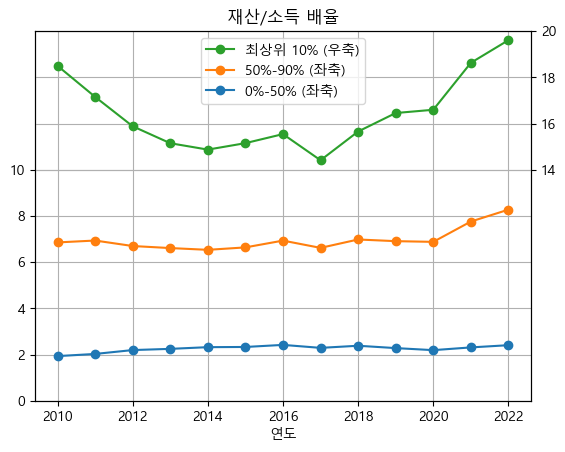

In [130]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = sub_ratio_table['연도']
sub_0_50 = sub_ratio_table['0%-50%']
sub_50_90 = sub_ratio_table['50%-90%']
sub_90_100 = sub_ratio_table['최상위 10%']

# 그래프 생성
fig, ax1 = plt.subplots()

# 왼쪽 축 (ax1) 설정
ax1.set_xlabel('연도')
ax1.plot(years, sub_50_90, marker='o', linestyle='-', 
         label='50%-90% (좌축)', color='tab:orange')
ax1.plot(years, sub_0_50, marker='o', linestyle='-', 
         label='0%-50% (좌축)', color='tab:blue')
ax1.set_yticks([0, 2, 4, 6, 8, 10])
plt.ylim(0, 16)
plt.grid(True)

# 오른쪽 축 (ax2) 설정
ax2 = ax1.twinx()
ax2.plot(years, sub_90_100, marker='o', linestyle='-', 
         label='최상위 10% (우축)', color='tab:green')
ax2.set_yticks([14, 16, 18, 20])
plt.ylim(4, 20)
plt.grid(True)

# 레전드 표시
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=9)

# 그래프 출력
plt.title('재산/소득 배율')
plt.xlabel('연도')

# 그래프 표시
plt.show()

#### B. With Weights

In [131]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
sub_ratio_table = pd.DataFrame(columns=['연도', '0%-50%', '50%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # x1 값을 계산
    x1 = df_year['순자산'] / 100
    x1 = x1 / (cpi_year / 100)
    
    # x2 값을 계산(통계당국 처분가능소득 계산)
    x2 = df_year[income_column] + df_year[interest_payment]
    x2 = x2 / 100
    x2 = x2 / (cpi_year / 100)    
    
    # 가중치 지정
    weight = df_year['가중값']

    # 백분위수 계산
    p_0 = weighted_percentile(x1, weight, 0)
    p_50 = weighted_percentile(x1, weight, 50)
    p_90 = weighted_percentile(x1, weight, 90)
    p_100 = weighted_percentile(x1, weight, 100)
    
    # 세 배열 생성
    data = {'x1': x1, 'x2': x2, 'w': weight}
    df = pd.DataFrame(data)

    # sub-group 값의 가중평균 계산
    subset_df = df[(df['x1'] >= p_0) & (df['x1'] < p_50)]
    sub_0_50 = (weighted_mean(subset_df['x1'], subset_df['w'])
                /weighted_mean(subset_df['x2'], subset_df['w']))
    subset_df = df[(df['x1'] >= p_50) & (df['x1'] < p_90)]
    sub_50_90 = (weighted_mean(subset_df['x1'], subset_df['w'])
                 /weighted_mean(subset_df['x2'], subset_df['w']))
    subset_df = df[(df['x1'] >= p_90) & (df['x1'] <= p_100)]
    sub_90_100 = (weighted_mean(subset_df['x1'], subset_df['w'])
                  /weighted_mean(subset_df['x2'], subset_df['w']))

    # 결과를 데이터프레임에 추가
    sub_ratio_table = pd.concat([sub_ratio_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '0%-50%': [sub_0_50], 
                                                '50%-90%': [sub_50_90],
                                                '최상위 10%': [sub_90_100]})],
                                 ignore_index=True)

# 결과를 출력
sub_ratio_table

연도    0%-50%   50%-90%    최상위 10%
0   2010  1.869219  6.564676  17.396597
1   2011  1.961927  6.690700  15.789663
2   2012  2.261038  6.846884  15.813627
3   2013  2.237502  6.618141  14.946844
4   2014  2.339872  6.575431  14.557317
5   2015  2.360128  6.665465  14.953566
6   2016  2.437517  6.919430  15.190360
7   2017  2.318184  6.621933  13.955485
8   2018  2.407163  6.893876  14.987301
9   2019  2.304538  6.892485  15.872650
10  2020  2.234421  7.014704  16.025794
11  2021  2.373094  7.878562  17.825006
12  2022  2.436825  8.298538  18.721219

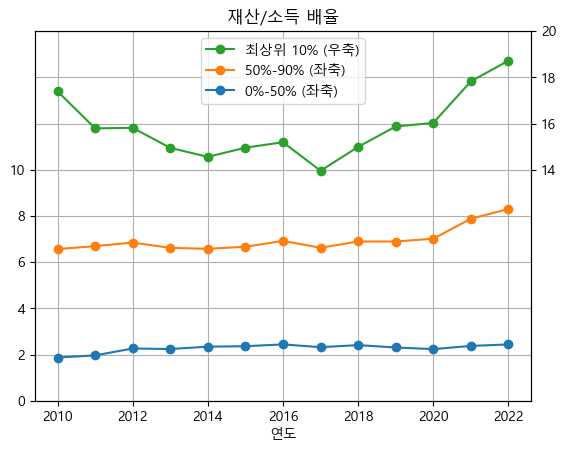

In [132]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = sub_ratio_table['연도']
sub_0_50 = sub_ratio_table['0%-50%']
sub_50_90 = sub_ratio_table['50%-90%']
sub_90_100 = sub_ratio_table['최상위 10%']

# 그래프 생성
fig, ax1 = plt.subplots()

# 왼쪽 축 (ax1) 설정
ax1.set_xlabel('연도')
ax1.plot(years, sub_50_90, marker='o', linestyle='-', 
         label='50%-90% (좌축)', color='tab:orange')
ax1.plot(years, sub_0_50, marker='o', linestyle='-', 
         label='0%-50% (좌축)', color='tab:blue')
ax1.set_yticks([0, 2, 4, 6, 8, 10])
plt.ylim(0, 16)
plt.grid(True)

# 오른쪽 축 (ax2) 설정
ax2 = ax1.twinx()
ax2.plot(years, sub_90_100, marker='o', linestyle='-', 
         label='최상위 10% (우축)', color='tab:green')
ax2.set_yticks([14, 16, 18, 20])
plt.ylim(4, 20)
plt.grid(True)

# 레전드 표시
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=9)

# 그래프 출력
plt.title('재산/소득 배율')
plt.xlabel('연도')

# 그래프 표시
plt.show()

### 연령대별 자산/소득 배율(연습)

In [208]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
sub_ratio_table = pd.DataFrame(columns=['연도', '0%-50%', '50%-90%', '최상위 10%'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income_column = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
#    df_year_G1 = df_year[df_year['가구주연령_10세단위코드'] == 'G2']
#    df_year_G1 = df_year[df_year['가구주연령_10세단위코드'].isin(['G1', 'G2'])]
#    df_year_G1 = df_year[df_year['수도권여부'].isin(['G1', 'G2'])]
    df_year_G1 = df_year[df_year['입주형태통합코드'].isin(['G1'])]
    print(len(df_year_G1))
    
    # x1 값을 계산
    x1 = df_year_G1['순자산'] / 100
    x1 = x1 / (cpi_year / 100)
    
    # x2 값을 계산(통계당국 처분가능소득 계산)
    x2 = df_year_G1[income_column] + df_year_G1[interest_payment]
    x2 = x2 / 100
    x2 = x2 / (cpi_year / 100)    

    # 백분위수 계산
    p_0 = np.percentile(x1, 0)
    p_50 = np.percentile(x1, 50)
    p_90 = np.percentile(x1, 90)
    p_99 = np.percentile(x1, 99)
    p_100 = np.percentile(x1, 100)
    
    # sub-group 평균값의 비율 계산
    sub_0_50 = (x1[(x1 >= p_0) & (x1 < p_50)].mean()
                /x2[(x1 >= p_0) & (x1 < p_50)].mean())
    sub_50_90 = (x1[(x1 >= p_50) & (x1 < p_90)].mean()
                /x2[(x1 >= p_50) & (x1 < p_90)].mean())
    sub_90_100 = (x1[(x1 >= p_90) & (x1 <= p_100)].mean()
                  /x2[(x1 >= p_90) & (x1 <= p_100)].mean())

    # 결과를 데이터프레임에 추가
    sub_ratio_table = pd.concat([sub_ratio_table, 
                                  pd.DataFrame({'연도': [year], 
                                                '0%-50%': [sub_0_50], 
                                                '50%-90%': [sub_50_90],
                                                '최상위 10%': [sub_90_100]})],
                                 ignore_index=True)

# 결과를 출력
sub_ratio_table

5839
5980
11430
10866
10659
10906
11148
11367
11549
11414
11223
11277
11069


연도    0%-50%    50%-90%    최상위 10%
0   2010  4.014710   8.638236  21.003983
1   2011  4.213669   8.574111  19.816926
2   2012  4.265537   8.200505  17.959915
3   2013  4.198909   7.996973  16.883119
4   2014  4.233457   7.808716  16.916157
5   2015  4.274773   7.845839  16.930131
6   2016  4.483421   8.152051  17.285974
7   2017  4.172856   7.729959  15.958484
8   2018  4.309001   8.223797  17.191926
9   2019  4.150502   8.155652  18.548076
10  2020  4.079504   8.158773  18.634027
11  2021  4.450291   9.476787  20.281920
12  2022  4.787447  10.095615  21.871380

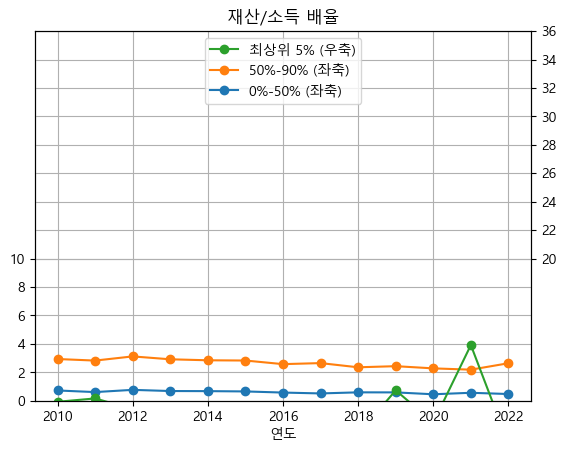

In [189]:
import matplotlib.pyplot as plt

# 데이터프레임에서 열을 추출
years = sub_ratio_table['연도']
sub_0_50 = sub_ratio_table['0%-50%']
sub_50_90 = sub_ratio_table['50%-90%']
sub_90_100 = sub_ratio_table['최상위 5%']

# 그래프 생성
fig, ax1 = plt.subplots()

# 왼쪽 축 (ax1) 설정
ax1.set_xlabel('연도')
ax1.plot(years, sub_50_90, marker='o', linestyle='-', 
         label='50%-90% (좌축)', color='tab:orange')
ax1.plot(years, sub_0_50, marker='o', linestyle='-', 
         label='0%-50% (좌축)', color='tab:blue')
ax1.set_yticks([0, 2, 4, 6, 8, 10])
plt.ylim(0, 26)
plt.grid(True)

# 오른쪽 축 (ax2) 설정
ax2 = ax1.twinx()
ax2.plot(years, sub_90_100, marker='o', linestyle='-', 
         label='최상위 5% (우축)', color='tab:green')
ax2.set_yticks([20, 22, 24, 26, 28, 30, 32, 34, 36])
plt.ylim(10, 36)
plt.grid(True)

# 레전드 표시
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=9)

# 그래프 출력
plt.title('재산/소득 배율')
plt.xlabel('연도')

# 그래프 표시
plt.show()

## 10. 재산의 구성

### 2022년 자산 및 부채의 구성 검토

### 가계금융복지조사 자산 및 부채 항목

#### 자산
- 자산_금융자산
   - 자산_금융자산_저축금액
      - 자산_금융자산_저축_적립예치식저축금액
      - 자산_금융자산_저축_적립예치식저축_수시적립예치식저축금액
      - 자산_금융자산_저축_적립예치식저축_저축성보장성보험금액
      - **자산_금융자산_저축_적립예치식저축_주식채권펀드금액**
      - 자산_금융자산_저축_기타저축금액
   - 자산_금융자산_현거주지전월세보증금
- 자산_실물자산	
   - **자산_실물자산_부동산금액**
      - 자산_실물자산_부동산_거주주택금액
      - 자산_실물자산_부동산_거주주택이외부동산금액
      - 자산_실물자산_부동산_계약금중도금납입금액
   - **자산_실물자산_기타실물자산**
      - 자산_실물자산_기타실물자산_자동차금액
      - 자산_실물자산_기타실물자산_기타금액
      - 자산_실물자산_기타실물자산_기타_자동차이외기타실물자산
      - 자산_실물자산_기타실물자산_기타_권리금

#### 부채
- 부채_금융부채
   - 부채_금융부채_담보대출금액
      - 부채_금융부채_담보대출_대출용도_거주주택구입금액
      - 부채_금융부채_담보대출_대출용도_거주주택이외부동산구입금액
      - 부채_금융부채_담보대출_대출용도_전월세보증금마련금액
      - 부채_금융부채_담보대출_대출용도_부채상환금액
      - 부채_금융부채_담보대출_대출용도_사업자금마련금액
      - 부채_금융부채_담보대출_대출용도_생활비마련금액
      - 부채_금융부채_담보대출_대출용도_기타용도금액
      - 부채_금융부채_담보대출_대출기관_은행금액(2010년은 농수협 중앙회 제외)
      - 부채_금융부채_담보대출_대출기관_저축은행금액
      - 부채_금융부채_담보대출_대출기관_비은행금융기관금액(2010년은 농수협중앙회 포함)
      - 부채_금융부채_담보대출_대출기관_보험회사금액
      - 부채_금융부채_담보대출_대출기관_기타기관금액
      - 부채_금융부채_담보대출_상환방법_만기일시금액
      - 부채_금융부채_담보대출_상환방법_원금분할상환금액
      - 부채_금융부채_담보대출_상환방법_원리금분할상환금액
      - 부채_금융부채_담보대출_상환방법_원리금분할일부만기상환금액
      - 부채_금융부채_담보대출_상환방법_기타상환방법금액
      - 부채_금융부채_담보대출_담보형태_거주주택금액
      - 부채_금융부채_담보대출_담보형태_거주주택이외부동산금액
      - 부채_금융부채_담보대출_담보형태_예적금보험펀드채권금액
      - 부채_금융부채_담보대출_담보형태_기타금액
      - **부채_금융부채_담보대출_부동산담보대출금액**
      - 부채_금융부채_담보대출_부동산이외담보대출금액
   - 부채_금융부채_신용대출금액
      - 부채_금융부채_신용대출_대출용도_거주주택구입금액
      - 부채_금융부채_신용대출_대출용도_거주주택이외부동산구입금액
      - 부채_금융부채_신용대출_대출용도_전월세보증금마련금액
      - 부채_금융부채_신용대출_대출용도_부채상환금액
      - 부채_금융부채_신용대출_대출용도_사업자금마련금액
      - 부채_금융부채_신용대출_대출용도_생활비마련금액
      - 부채_금융부채_신용대출_대출용도_기타용도금액
      - 부채_금융부채_신용대출_대출기관_은행금액(2010년은 농수협 중앙회 제외)
      - 부채_금융부채_신용대출_대출기관_저축은행금액
      - 부채_금융부채_신용대출_대출기관_비은행금융기관금액(2010년은 농수협중앙회 포함)
      - 부채_금융부채_신용대출_대출기관_보험회사금액
      - 부채_금융부채_신용대출_대출기관_기타기관금액
      - 부채_금융부채_신용대출_상환방법_만기일시금액
      - 부채_금융부채_신용대출_상환방법_원금분할상환금액
      - 부채_금융부채_신용대출_상환방법_원리금분할상환금액
      - 부채_금융부채_신용대출_상환방법_원리금분할일부만기상환금액
      - 부채_금융부채_신용대출_상환방법_기타상환방법금액
      - 부채_금융부채_신용대출_대출종류_신용대출금액
      - 부채_금융부채_신용대출_대출종류_마이너스통장금액
   - 부채_금융부채_신용카드관련대출금액
   - 부채_금융부채_외상할부미상환금액
   - 부채_금융부채_계탄후불입금액
   - 부채_금융부채_개인직장빌린금액(2017년~)
- 부채_임대보증금

In [133]:
wealth = df_2022['순자산']
weight = df_2022['가중값']

asset = df_2022['자산']
asset_financial = df_2022['자산_금융자산']
asset_stock = df_2022['자산_금융자산_저축_적립예치식저축_주식채권펀드금액']
asset_fin_others = asset_financial - asset_stock
asset_real = df_2022['자산_실물자산_부동산금액']
asset_real_others = df_2022['자산_실물자산_기타실물자산']

debt = df_2022['부채']
debt_house = df_2022['부채_금융부채_담보대출_부동산담보대출금액']
debt_others = debt - debt_house

print('자산:', round(asset.mean()))
print('자산(부동산):', round(asset_real.mean()))
print('자산(기타실물):', round(asset_real_others.mean()))
print('자산(주식채권펀드):', round(asset_stock.mean()))
print('자산(기타금융):', round(asset_fin_others.mean()))

print('\n부채:', round(debt.mean()))
print('부채(부동산담보대출):', round(debt_house.mean()))
print('부채(기타):', round(debt_others.mean()))

print('\n순자산:', round(wealth.mean()))

자산: 50485
자산(부동산): 37537
자산(기타실물): 2236
자산(주식채권펀드): 1541
자산(기타금융): 9171

부채: 7450
부채(부동산담보대출): 3737
부채(기타): 3713

순자산: 43035


- 자산 및 부채에 대한 소분류에 오류가 없는 것을 확인할 수 있다.

In [134]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
table1 = pd.DataFrame(columns=['연도', '순자산', '부동산', '기타실물', '금융자산', 
                               '부동산담보대출', '기타부채'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    selected_columns = ['가중값', '자산', '자산_금융자산', 
                        '자산_실물자산_부동산금액', '자산_실물자산_기타실물자산',
                        '부채', '부채_금융부채_담보대출_부동산담보대출금액', '순자산']

    df = df_year[selected_columns]/100
    df = df / (cpi_year / 100)

    # 변수명 지정
    df = df.rename(columns={'자산_금융자산': '금융자산'})
    df = df.rename(columns={'자산_실물자산_부동산금액': '부동산'})
    df = df.rename(columns={'자산_실물자산_기타실물자산': '기타실물'})
    
    df = df.rename(columns={'부채_금융부채_담보대출_부동산담보대출금액': '부동산담보대출'})
    df['기타부채'] = df['부채'] - df['부동산담보대출']
    wealth = df['순자산']
    weight = df['가중값']
    
    # 백분위수 계산
    p_0 = np.percentile(wealth, 0)
    p_50 = np.percentile(wealth, 50)
    p_90 = np.percentile(wealth, 90)
    p_100 = np.percentile(wealth, 100)
    
    # sub-group 평균값 계산
    sub_0_50 = (df[(wealth >= p_0) & (wealth < p_50)].mean())
    sub_50_90 = (df[(wealth >= p_50) & (wealth < p_90)].mean())
    sub_90_100 = (df[(wealth >= p_90) & (wealth <= p_100)].mean())

    # 결과를 데이터프레임에 추가
    table1 = pd.concat([table1,
                        pd.DataFrame({'연도': [year],
                                      '순자산': [sub_0_50['순자산']],
                                      '부동산': [sub_0_50['부동산']],
                                      '기타실물': [sub_0_50['기타실물']],
                                      '금융자산': [sub_0_50['금융자산']],
                                      '부동산담보대출': [-sub_0_50['부동산담보대출']], 
                                      '기타부채': [-sub_0_50['기타부채']]})],
                       ignore_index=True)

# 결과를 출력
table1

연도        순자산        부동산      기타실물       금융자산    부동산담보대출       기타부채
0   2010  48.099033  38.736726  3.986644  30.886680 -11.634244 -13.876772
1   2011  51.058592  41.727180  4.835615  33.224882 -12.616433 -16.112652
2   2012  52.940325  38.613043  6.395978  30.851408  -9.934752 -12.985353
3   2013  55.429850  42.263413  6.917476  32.380507 -11.944609 -14.186937
4   2014  59.171007  44.850957  7.048867  33.760273 -12.501907 -13.987183
5   2015  60.316638  46.252611  7.239443  33.866946 -13.109666 -13.932696
6   2016  62.473808  48.833805  7.260266  34.055523 -13.658457 -14.017330
7   2017  63.967411  51.554340  7.296131  34.578196 -14.208181 -15.253076
8   2018  67.135649  53.502309  7.912956  35.729312 -14.117632 -15.891297
9   2019  65.724679  51.864473  7.910702  36.869777 -13.745055 -17.175219
10  2020  64.994765  51.469783  7.786558  38.014163 -13.783624 -18.492115
11  2021  68.327185  51.227761  7.925574  40.230605 -12.169681 -18.887074
12  2022  69.857834  50.169704  7.815885  40.361731 -10.673149 -17.816337

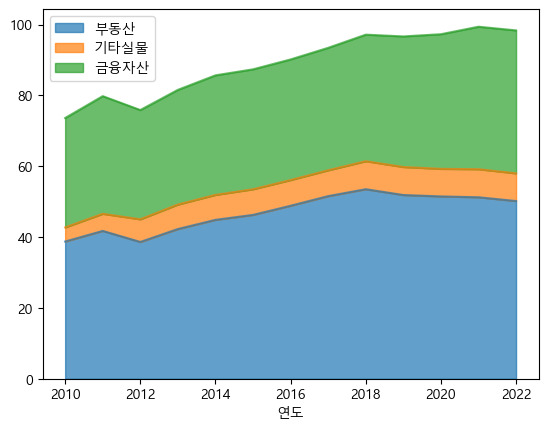

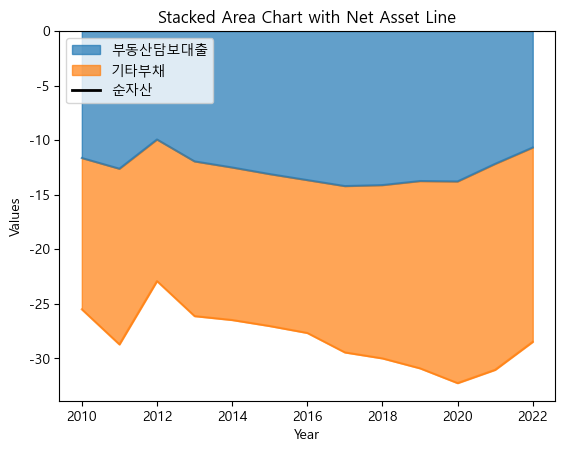

In [135]:
table = table1

import matplotlib.pyplot as plt

# 데이터프레임 'table'에서 필요한 열 선택
data = table[['연도', '부동산', '기타실물', '금융자산', '부동산담보대출', '기타부채', '순자산']]

# 연도를 인덱스로 설정
data.set_index('연도', inplace=True)

# Stacked area chart 그리기
data[['부동산', '기타실물', '금융자산']].plot.area(stacked=True, alpha=0.7)

# 부동산담보대출과 기타부채는 마이너스 쪽으로 Stacked area chart 그리기
data[['부동산담보대출', '기타부채']].plot.area(stacked=True, alpha=0.7)

# 순자산은 선 그래프로 그리기
data['순자산'].plot(color='black', linewidth=2)

# 그래프 제목, 축 레이블 설정
plt.title('Stacked Area Chart with Net Asset Line')
plt.xlabel('Year')
plt.ylabel('Values')

# 범례 추가
plt.legend(loc='upper left')

# 0의 수평선 그리기
plt.axhline(0, color='gray', linestyle='--')

# 그래프 표시
plt.show()


C:\Users\pilsu\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1594: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


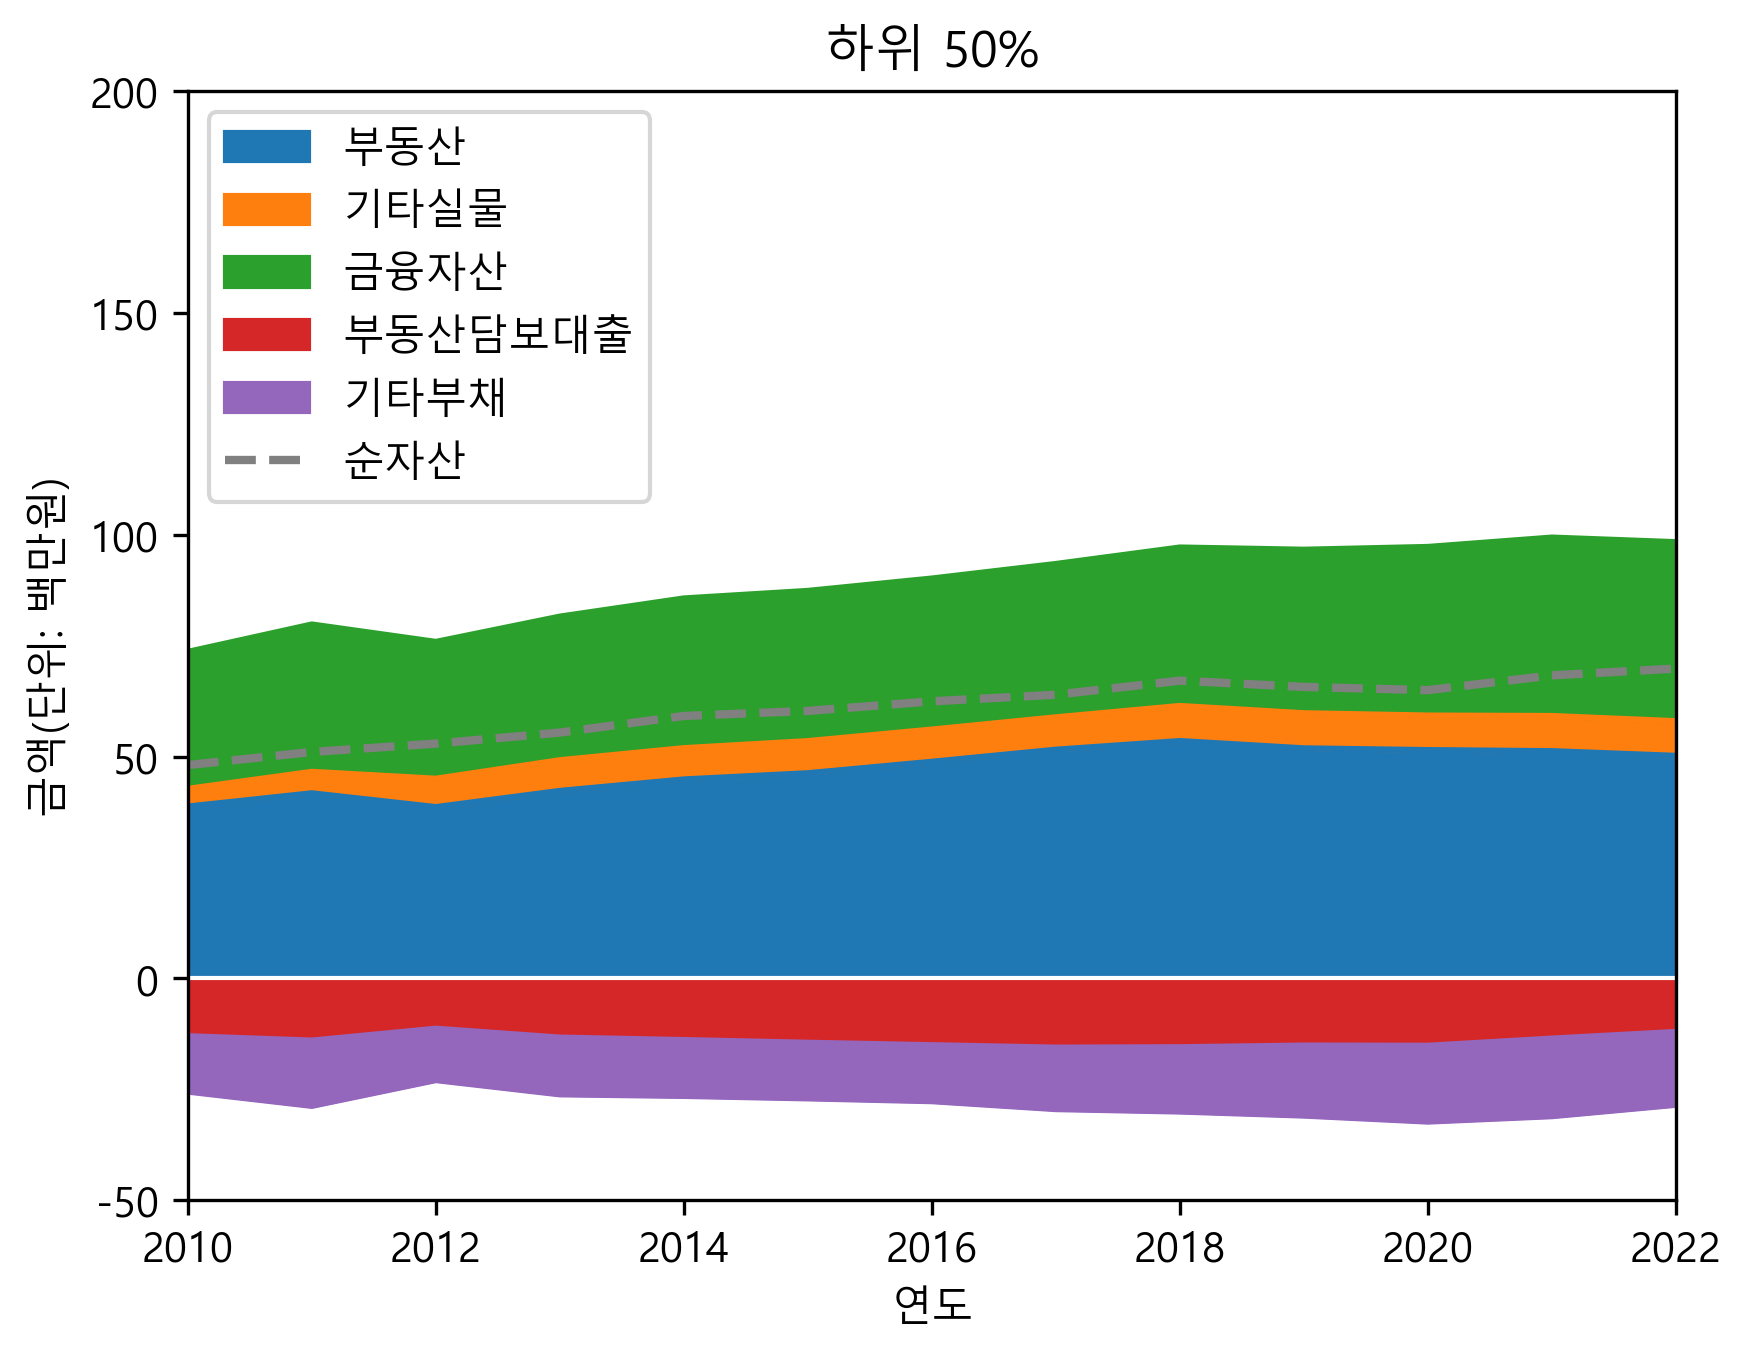

In [136]:
table = table1

import matplotlib.pyplot as plt

# 데이터프레임 'table'에서 필요한 열 선택
data = table[['연도', '부동산', '기타실물', '금융자산', '부동산담보대출', '기타부채', '순자산']]

# 연도를 인덱스로 설정
data.set_index('연도', inplace=True)

# 새로운 figure 및 subplot 생성
fig, ax = plt.subplots(dpi=300)

# Stacked area chart 그리기
data[['부동산', '기타실물', '금융자산']].plot.area(stacked=True, alpha=1, ax=ax)

# 부동산담보대출과 기타부채는 마이너스 쪽으로 Stacked area chart 그리기
data[['부동산담보대출', '기타부채']].plot.area(stacked=True, alpha=1, ax=ax)

# 순자산은 선 그래프로 그리기
data['순자산'].plot(color='gray', linestyle='--', linewidth=2, ax=ax)

# 그래프 제목, 축 레이블 설정
plt.title('하위 50%')
plt.xlabel('연도')
plt.ylabel('금액(단위: 백만원)')

# 범례 추가
ax.legend(loc='upper left')

# 0의 수평선 그리기
plt.axhline(0, color='white', linewidth=1)

# 세로축 범위 설정
plt.ylim(-50, 200)
plt.xlim(2010, 2022)

# 그래프 표시
plt.show()

In [137]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
table2 = pd.DataFrame(columns=['연도', '순자산', '부동산', '기타실물', '금융자산', 
                               '부동산담보대출', '기타부채'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    selected_columns = ['가중값', '자산', '자산_금융자산', 
                        '자산_실물자산_부동산금액', '자산_실물자산_기타실물자산',
                        '부채', '부채_금융부채_담보대출_부동산담보대출금액', '순자산']

    df = df_year[selected_columns]/100
    df = df / (cpi_year / 100)

    # 변수명 지정
    df = df.rename(columns={'자산_금융자산': '금융자산'})
    df = df.rename(columns={'자산_실물자산_부동산금액': '부동산'})
    df = df.rename(columns={'자산_실물자산_기타실물자산': '기타실물'})
    
    df = df.rename(columns={'부채_금융부채_담보대출_부동산담보대출금액': '부동산담보대출'})
    df['기타부채'] = df['부채'] - df['부동산담보대출']
    wealth = df['순자산']
    weight = df['가중값']
    
    # 백분위수 계산
    p_0 = np.percentile(wealth, 0)
    p_50 = np.percentile(wealth, 50)
    p_90 = np.percentile(wealth, 90)
    p_100 = np.percentile(wealth, 100)
    
    # sub-group 평균값 계산
    sub_0_50 = (df[(wealth >= p_0) & (wealth < p_50)].mean())
    sub_50_90 = (df[(wealth >= p_50) & (wealth < p_90)].mean())
    sub_90_100 = (df[(wealth >= p_90) & (wealth <= p_100)].mean())

    # 결과를 데이터프레임에 추가
    table2 = pd.concat([table2,
                        pd.DataFrame({'연도': [year],
                                      '순자산': [sub_50_90['순자산']],
                                      '부동산': [sub_50_90['부동산']],
                                      '기타실물': [sub_50_90['기타실물']],
                                      '금융자산': [sub_50_90['금융자산']],
                                      '부동산담보대출': [-sub_50_90['부동산담보대출']], 
                                      '기타부채': [-sub_50_90['기타부채']]})],
                       ignore_index=True)

# 결과를 출력
table2

연도         순자산         부동산       기타실물        금융자산    부동산담보대출       기타부채
0   2010  319.305437  284.543535  11.251751   85.612975 -32.214401 -29.888423
1   2011  327.568423  287.107906  12.696898   92.584067 -34.492429 -30.328018
2   2012  320.821746  261.268029  25.784957   96.226048 -32.343027 -30.114261
3   2013  322.802486  259.094679  26.133690  102.521487 -33.087997 -31.859373
4   2014  328.286775  265.381866  26.454932  104.014664 -35.719032 -31.845656
5   2015  335.644759  272.511668  26.712803  104.867536 -37.555792 -30.891455
6   2016  354.866277  294.751041  27.194426  106.501731 -40.906408 -32.674514
7   2017  363.385087  302.957051  26.348407  106.826578 -40.668140 -32.078809
8   2018  383.941278  321.196153  27.835543  110.878770 -41.577736 -34.391452
9   2019  382.198297  322.131849  27.198434  109.215623 -42.486474 -33.861135
10  2020  384.649932  331.174149  25.535843  108.351761 -44.416947 -35.994874
11  2021  426.653551  371.671227  26.840268  109.095248 -46.306681 -34.646511
12  2022  454.420011  395.496585  26.839700  112.903415 -45.475434 -35.344255

C:\Users\pilsu\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1594: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


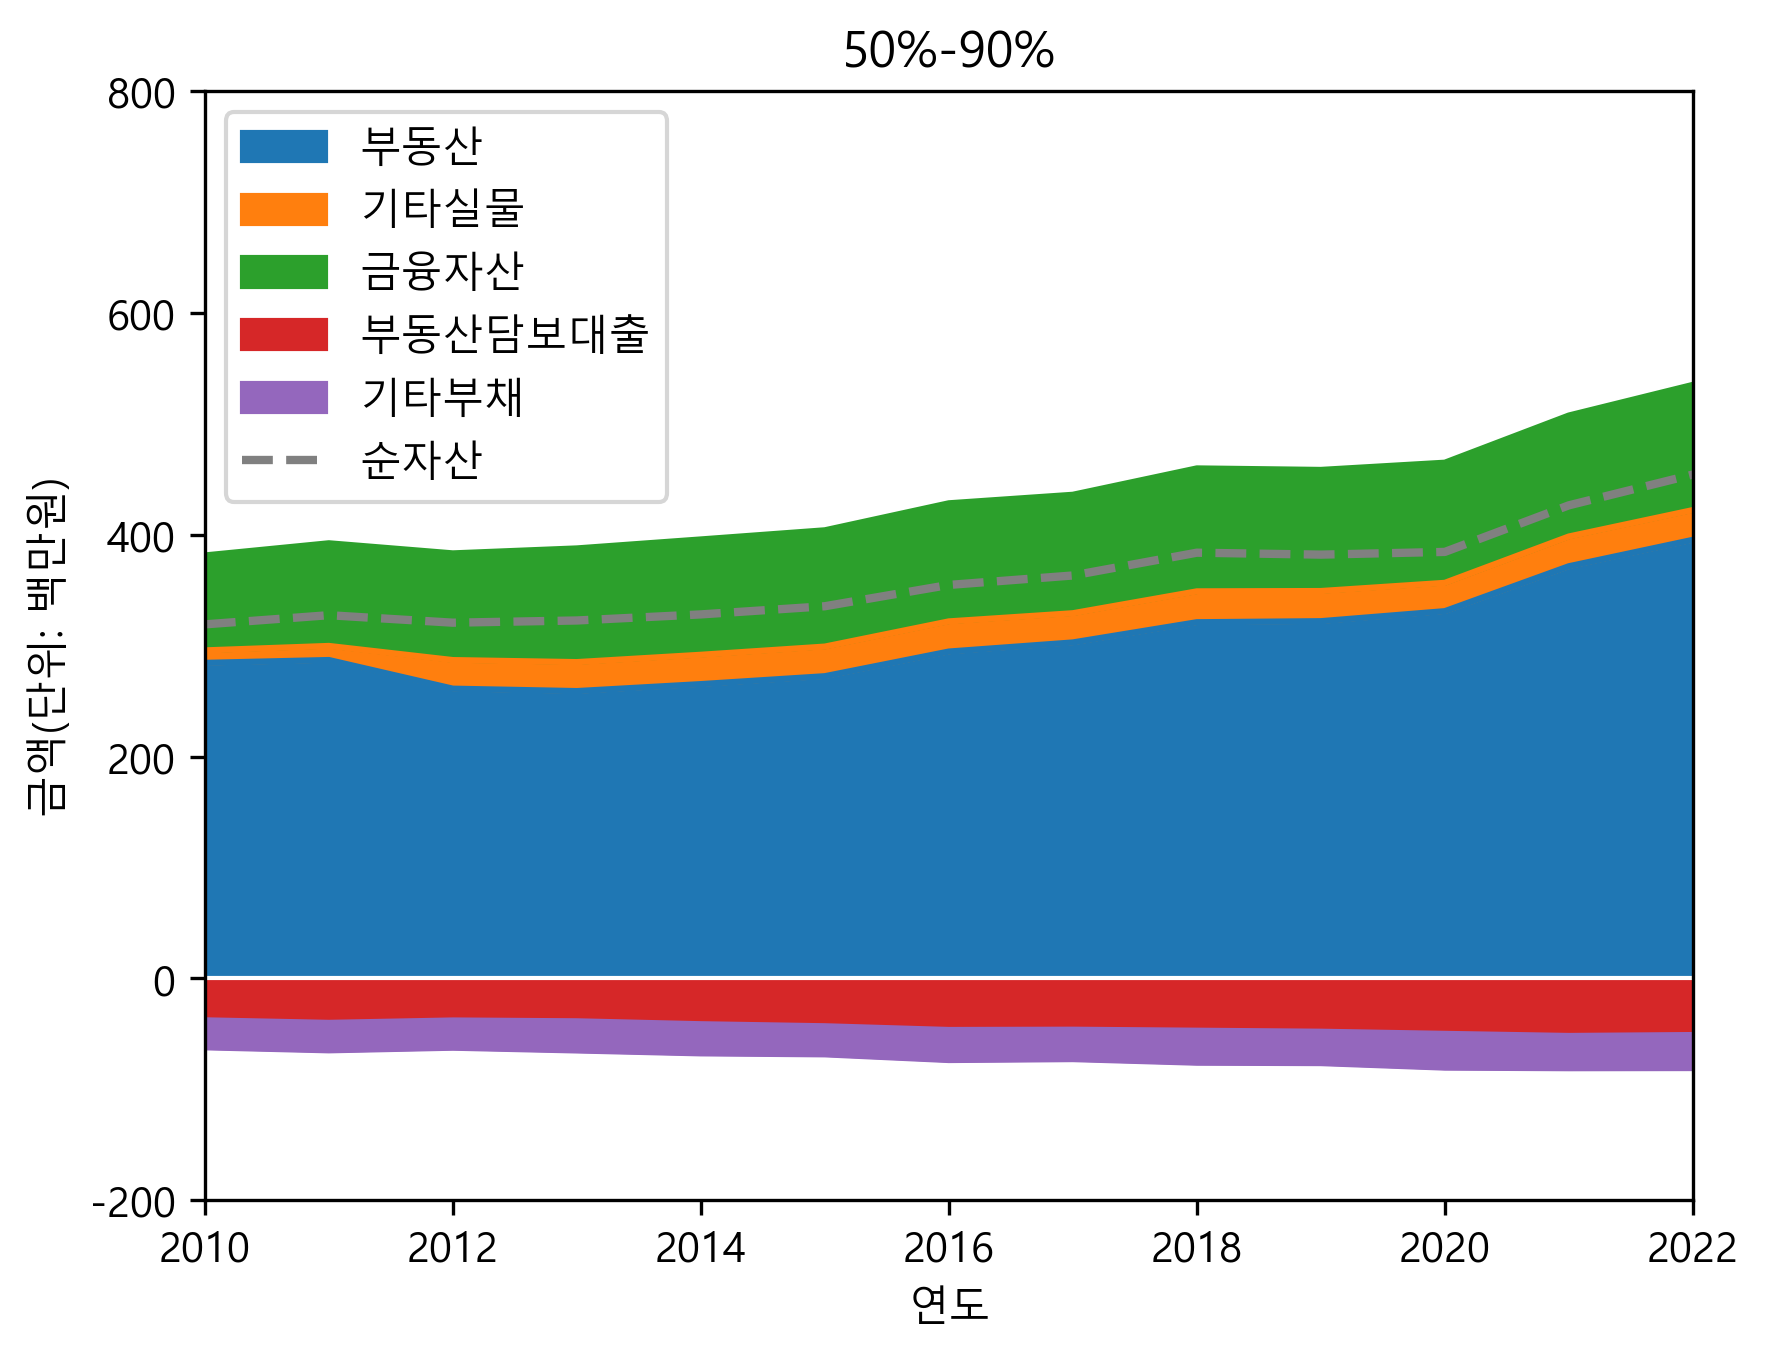

In [138]:
table = table2

import matplotlib.pyplot as plt

# 데이터프레임 'table'에서 필요한 열 선택
data = table[['연도', '부동산', '기타실물', '금융자산', '부동산담보대출', '기타부채', '순자산']]

# 연도를 인덱스로 설정
data.set_index('연도', inplace=True)

# 새로운 figure 및 subplot 생성
fig, ax = plt.subplots(dpi=300)

# Stacked area chart 그리기
data[['부동산', '기타실물', '금융자산']].plot.area(stacked=True, alpha=1, ax=ax)

# 부동산담보대출과 기타부채는 마이너스 쪽으로 Stacked area chart 그리기
data[['부동산담보대출', '기타부채']].plot.area(stacked=True, alpha=1, ax=ax)

# 순자산은 선 그래프로 그리기
data['순자산'].plot(color='gray', linestyle='--', linewidth=2, ax=ax)

# 그래프 제목, 축 레이블 설정
plt.title('50%-90%')
plt.xlabel('연도')
plt.ylabel('금액(단위: 백만원)')

# 범례 추가
ax.legend(loc='upper left')

# 0의 수평선 그리기
plt.axhline(0, color='white', linewidth=1)

# 세로축 범위 설정
plt.ylim(-200, 800)
plt.xlim(2010, 2022)

# 그래프 표시
plt.show()

In [139]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
table3 = pd.DataFrame(columns=['연도', '순자산', '부동산', '기타실물', '금융자산', 
                               '부동산담보대출', '기타부채'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    selected_columns = ['가중값', '자산', '자산_금융자산', 
                        '자산_실물자산_부동산금액', '자산_실물자산_기타실물자산',
                        '부채', '부채_금융부채_담보대출_부동산담보대출금액', '순자산']

    df = df_year[selected_columns]/100
    df = df / (cpi_year / 100)

    # 변수명 지정
    df = df.rename(columns={'자산_금융자산': '금융자산'})
    df = df.rename(columns={'자산_실물자산_부동산금액': '부동산'})
    df = df.rename(columns={'자산_실물자산_기타실물자산': '기타실물'})
    
    df = df.rename(columns={'부채_금융부채_담보대출_부동산담보대출금액': '부동산담보대출'})
    df['기타부채'] = df['부채'] - df['부동산담보대출']
    wealth = df['순자산']
    weight = df['가중값']
    
    # 백분위수 계산
    p_0 = np.percentile(wealth, 0)
    p_50 = np.percentile(wealth, 50)
    p_90 = np.percentile(wealth, 90)
    p_100 = np.percentile(wealth, 100)
    
    # sub-group 평균값 계산
    sub_0_50 = (df[(wealth >= p_0) & (wealth < p_50)].mean())
    sub_50_90 = (df[(wealth >= p_50) & (wealth < p_90)].mean())
    sub_90_100 = (df[(wealth >= p_90) & (wealth <= p_100)].mean())

    # 결과를 데이터프레임에 추가
    table3 = pd.concat([table3,
                        pd.DataFrame({'연도': [year],
                                      '순자산': [sub_90_100['순자산']],
                                      '부동산': [sub_90_100['부동산']],
                                      '기타실물': [sub_90_100['기타실물']],
                                      '금융자산': [sub_90_100['금융자산']],
                                      '부동산담보대출': [-sub_90_100['부동산담보대출']], 
                                      '기타부채': [-sub_90_100['기타부채']]})],
                       ignore_index=True)

# 결과를 출력
table3

연도          순자산          부동산        기타실물        금융자산     부동산담보대출  \
0   2010  1485.953782  1414.616813   39.189863  248.159517 -109.816355   
1   2011  1423.731018  1322.728682   40.365311  290.192971 -119.099608   
2   2012  1441.940297  1234.702760   99.843177  326.733893 -108.483054   
3   2013  1373.776036  1160.331060  102.781976  326.836483 -107.919879   
4   2014  1319.435504  1110.723885  101.019287  312.950247  -97.160089   
5   2015  1337.311985  1138.084616   90.628490  314.013822 -103.308170   
6   2016  1390.889791  1197.781016   85.931037  335.511330 -119.756779   
7   2017  1409.612023  1231.143782   79.479709  339.294565 -124.620305   
8   2018  1525.577718  1333.158908   86.195152  353.844238 -128.373419   
9   2019  1549.795178  1352.173873   76.853947  357.960564 -116.532310   
10  2020  1548.221140  1380.266137   66.630885  329.793702 -117.509402   
11  2021  1707.821510  1523.191510   65.677754  345.482256 -111.560530   
12  2022  1827.579066  1651.392804   61.082318  340.968019 -111.612913   

          기타부채  
0  -106.196057  
1  -110.456337  
2  -110.856479  
3  -108.253604  
4  -108.097825  
5  -102.106774  
6  -108.576813  
7  -115.685729  
8  -119.247162  
9  -120.660896  
10 -110.960183  
11 -114.969479  
12 -114.251163

C:\Users\pilsu\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1594: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


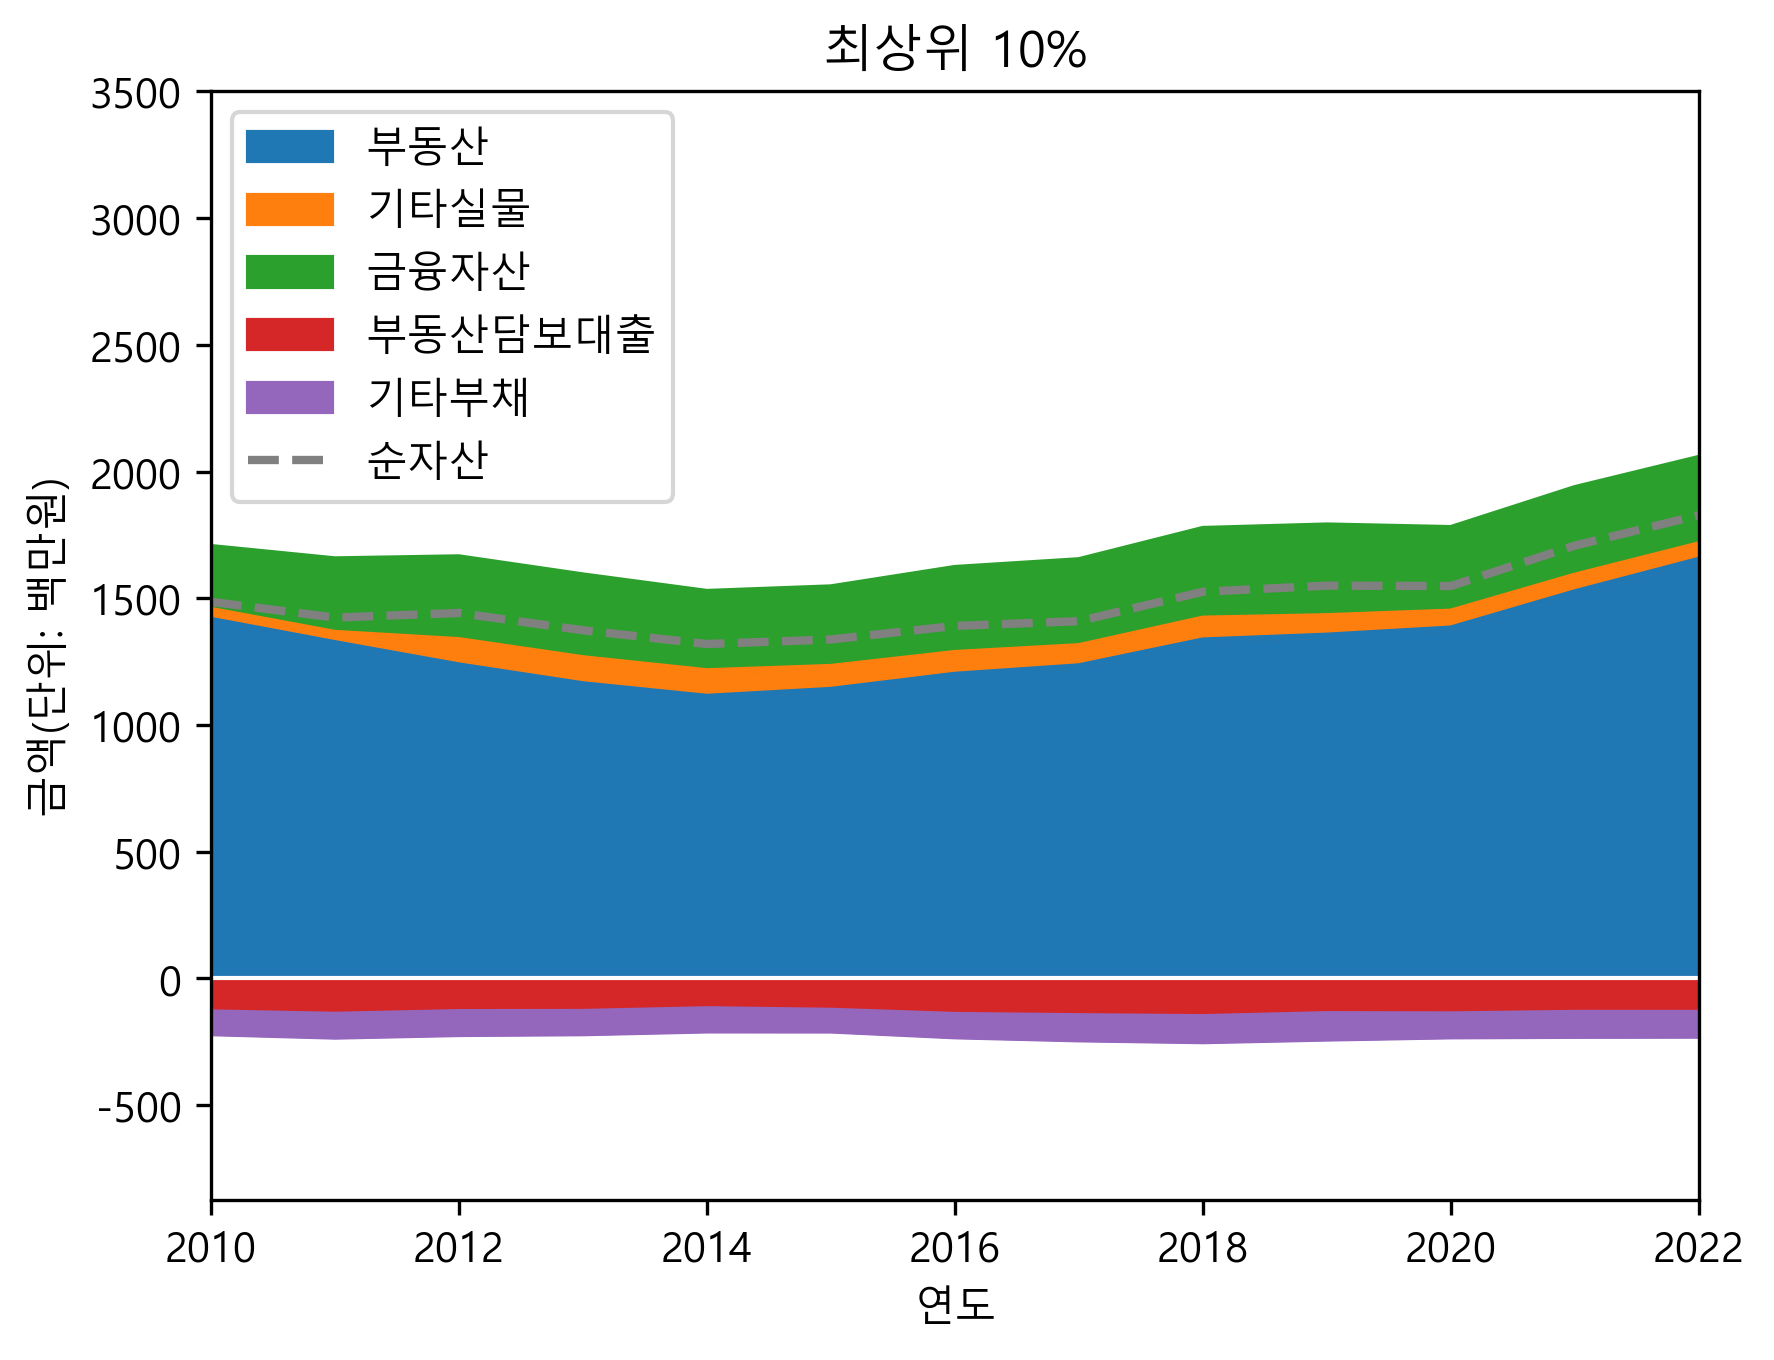

In [140]:
table = table3

import matplotlib.pyplot as plt

# 데이터프레임 'table'에서 필요한 열 선택
data = table[['연도', '부동산', '기타실물', '금융자산', '부동산담보대출', '기타부채', '순자산']]

# 연도를 인덱스로 설정
data.set_index('연도', inplace=True)

# 새로운 figure 및 subplot 생성
fig, ax = plt.subplots(dpi=300)

# Stacked area chart 그리기
data[['부동산', '기타실물', '금융자산']].plot.area(stacked=True, alpha=1, ax=ax)

# 부동산담보대출과 기타부채는 마이너스 쪽으로 Stacked area chart 그리기
data[['부동산담보대출', '기타부채']].plot.area(stacked=True, alpha=1, ax=ax)

# 순자산은 선 그래프로 그리기
data['순자산'].plot(color='gray', linestyle='--', linewidth=2, ax=ax)

# 그래프 제목, 축 레이블 설정
plt.title('최상위 10%')
plt.xlabel('연도')
plt.ylabel('금액(단위: 백만원)')

# 범례 추가
ax.legend(loc='upper left')

# 0의 수평선 그리기
plt.axhline(0, color='white', linewidth=1)

# 세로축 범위 설정
plt.ylim(-875, 3500)
plt.xlim(2010, 2022)

# 그래프 표시
plt.show()


In [141]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
table4 = pd.DataFrame(columns=['연도', '순자산', '부동산', '기타실물', '금융자산', 
                               '부동산담보대출', '기타부채'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df, CPI 지정
    df_year = globals()[f'df_{year}']
    cpi_year = globals()[f'CPI_{year}']
    
    selected_columns = ['가중값', '자산', '자산_금융자산', 
                        '자산_실물자산_부동산금액', '자산_실물자산_기타실물자산',
                        '부채', '부채_금융부채_담보대출_부동산담보대출금액', '순자산']

    df = df_year[selected_columns]/100
    df = df / (cpi_year / 100)

    # 변수명 지정
    df = df.rename(columns={'자산_금융자산': '금융자산'})
    df = df.rename(columns={'자산_실물자산_부동산금액': '부동산'})
    df = df.rename(columns={'자산_실물자산_기타실물자산': '기타실물'})
    
    df = df.rename(columns={'부채_금융부채_담보대출_부동산담보대출금액': '부동산담보대출'})
    df['기타부채'] = df['부채'] - df['부동산담보대출']
    wealth = df['순자산']
    weight = df['가중값']
    
    # 백분위수 계산
    p_0 = np.percentile(wealth, 0)
    p_50 = np.percentile(wealth, 50)
    p_90 = np.percentile(wealth, 90)
    p_100 = np.percentile(wealth, 100)
    
    # sub-group 평균값 계산
    sub_0_50 = (df[(wealth >= p_0) & (wealth < p_50)].mean())
    sub_50_90 = (df[(wealth >= p_50) & (wealth < p_90)].mean())
    sub_90_100 = (df[(wealth >= p_90) & (wealth <= p_100)].mean())
    sub_0_100 = df.mean()

    # 결과를 데이터프레임에 추가
    table4 = pd.concat([table4,
                        pd.DataFrame({'연도': [year],
                                      '순자산': [sub_0_100['순자산']],
                                      '부동산': [sub_0_100['부동산']],
                                      '기타실물': [sub_0_100['기타실물']],
                                      '금융자산': [sub_0_100['금융자산']],
                                      '부동산담보대출': [-sub_0_100['부동산담보대출']], 
                                      '기타부채': [-sub_0_100['기타부채']]})],
                       ignore_index=True)

# 결과를 출력
table4

연도         순자산         부동산       기타실물       금융자산    부동산담보대출       기타부채
0   2010  300.367070  274.647458  10.413009  74.504482 -29.684518 -29.513361
1   2011  298.974181  268.020828  11.534261  82.673823 -32.018603 -31.236128
2   2012  299.026960  247.313591  23.498540  86.596517 -28.755206 -29.626482
3   2013  294.247437  240.831766  24.192885  89.889735 -30.001906 -30.665043
4   2014  292.890137  239.689913  24.211800  89.791181 -30.257633 -30.545124
5   2015  298.205053  245.988913  23.371422  90.294278 -31.911927 -29.537632
6   2016  312.336084  262.150201  23.104894  93.194306 -35.172727 -30.940591
7   2017  318.324005  270.096219  22.136776  93.954909 -35.835454 -32.028445
8   2018  339.702107  288.545507  23.710211  97.600588 -36.527252 -33.626945
9   2019  340.763744  290.039432  22.522246  97.926531 -35.523519 -34.200946
10  2020  341.271205  296.312463  20.775017  95.346193 -36.417046 -34.745422
11  2021  375.638148  326.629326  21.267830  98.307420 -35.765581 -34.800848
12  2022  399.543556  348.503205  20.755318  99.454736 -34.694127 -34.475576

C:\Users\pilsu\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1594: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


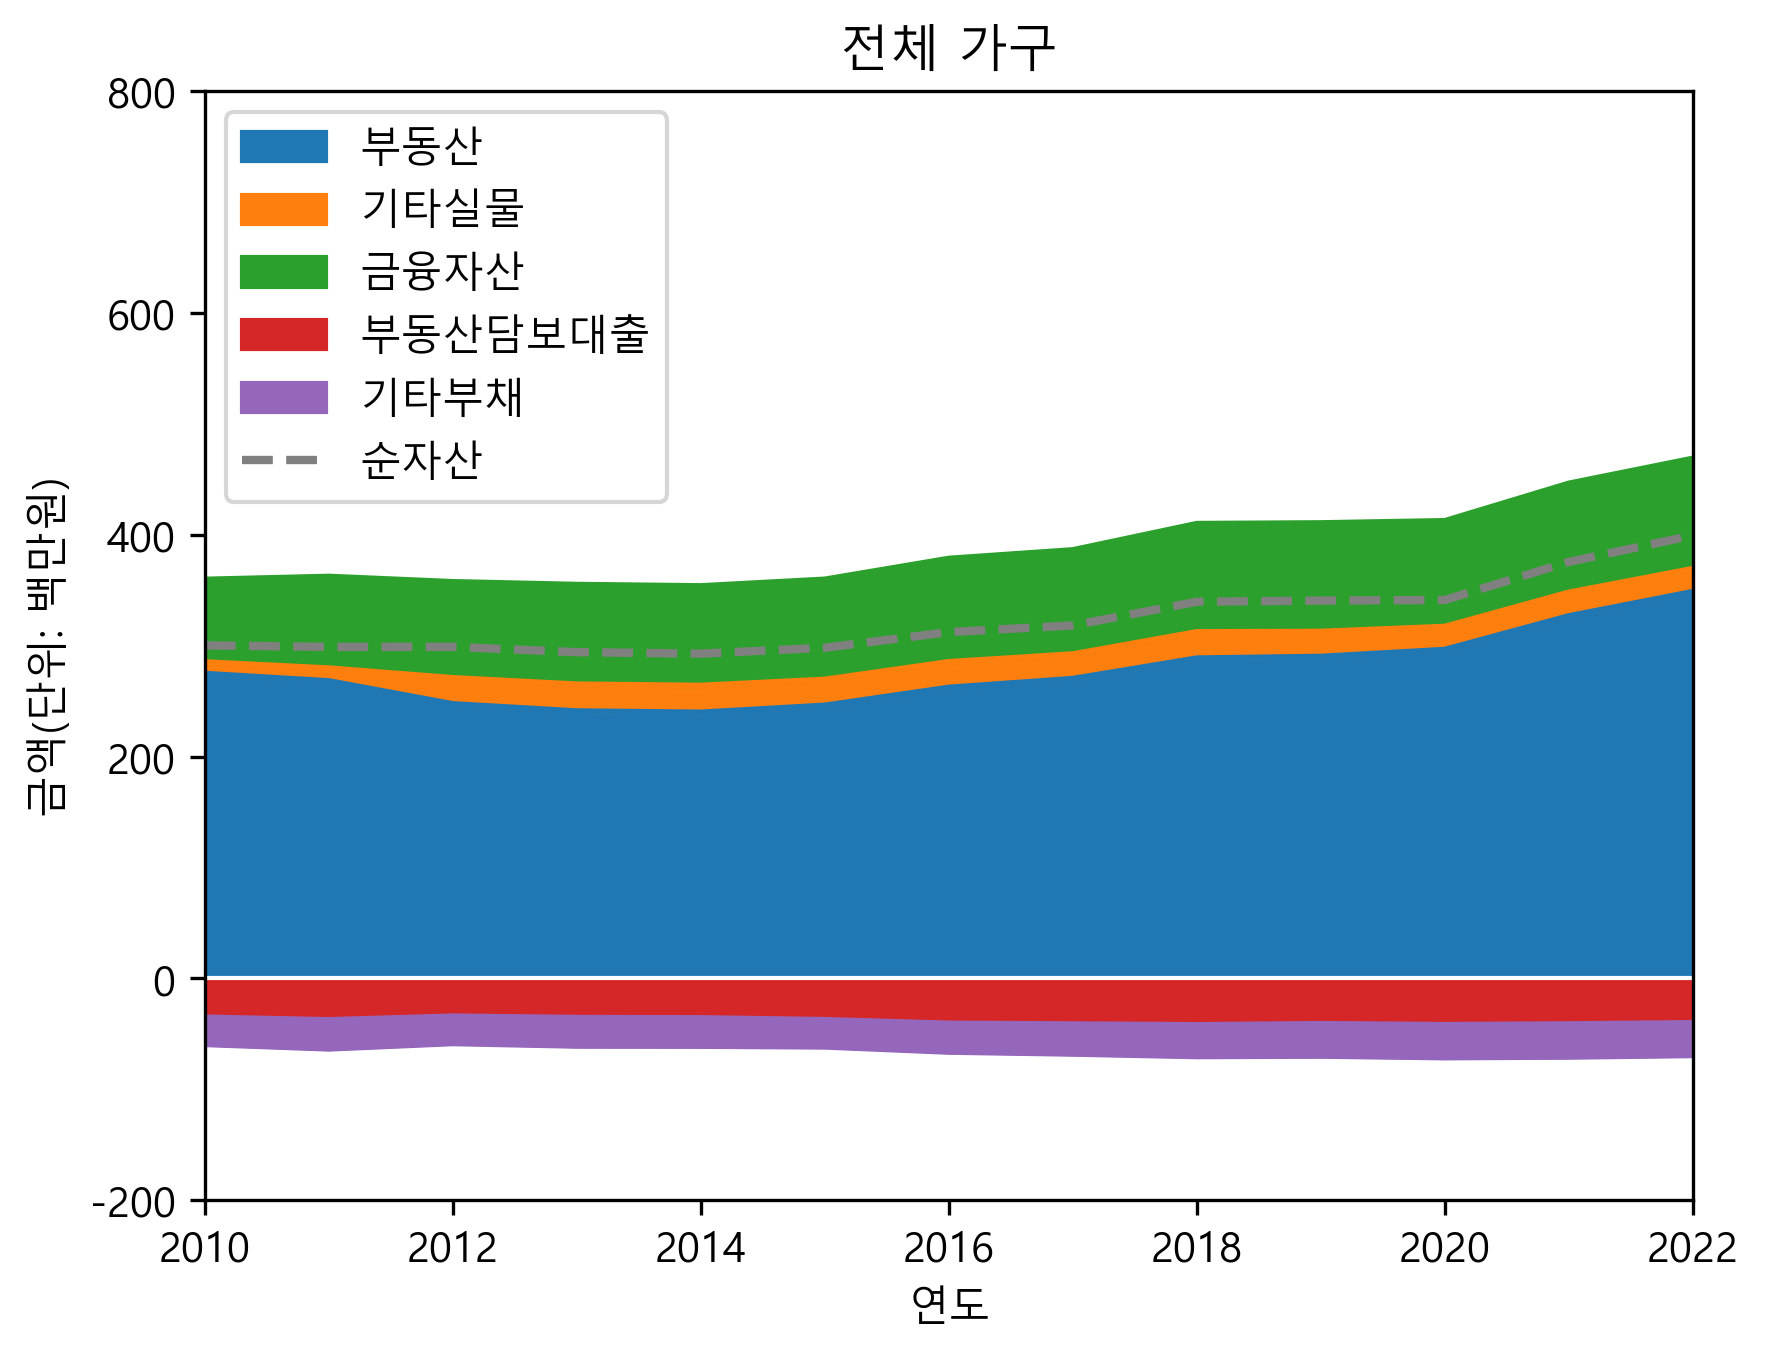

In [142]:
table = table4

import matplotlib.pyplot as plt

# 데이터프레임 'table'에서 필요한 열 선택
data = table[['연도', '부동산', '기타실물', '금융자산', '부동산담보대출', '기타부채', '순자산']]

# 연도를 인덱스로 설정
data.set_index('연도', inplace=True)

# 새로운 figure 및 subplot 생성
fig, ax = plt.subplots(dpi=300)

# Stacked area chart 그리기
data[['부동산', '기타실물', '금융자산']].plot.area(stacked=True, alpha=1, ax=ax)

# 부동산담보대출과 기타부채는 마이너스 쪽으로 Stacked area chart 그리기
data[['부동산담보대출', '기타부채']].plot.area(stacked=True, alpha=1, ax=ax)

# 순자산은 선 그래프로 그리기
data['순자산'].plot(color='gray', linestyle='--', linewidth=2, ax=ax)

# 그래프 제목, 축 레이블 설정
plt.title('전체 가구')
plt.xlabel('연도')
plt.ylabel('금액(단위: 백만원)')

# 범례 추가
ax.legend(loc='upper left')

# 0의 수평선 그리기
plt.axhline(0, color='white', linewidth=1)

# 세로축 범위 설정
plt.ylim(-200, 800)
plt.xlim(2010, 2022)

# 그래프 표시
plt.show()

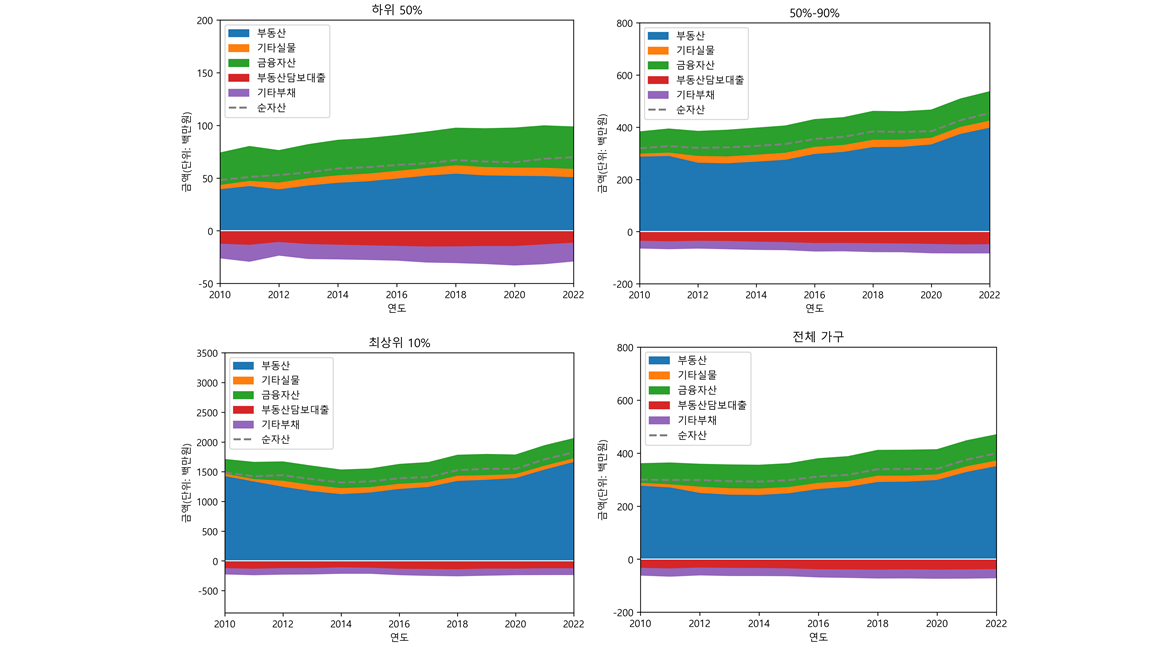

[文정부때 잔뜩 낀 ‘집값 거품’ 사라지자…빈부격차 줄었다](https://www.mk.co.kr/news/economy/10893650)